In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

from scipy.stats import pearsonr

import time


from scipy.stats import boxcox


from matplotlib import cm

import matplotlib.lines as mlines

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

## <font color='red'>  Basic Statistical Analysis of Air Pollution Monitoring Data from EDF </font>

In [49]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.tail()

Longitude   Latitude    NO Value  NO2 Value  BC Value       TimePeriod
21483 -122.034943  37.560076  129.999995  44.778220  3.923761  Jun2015-May2016
21484 -122.034724  37.560164   60.799998  39.027545  1.408693  Jun2015-May2016
21485 -122.034681  37.559830   34.622951  28.816797  2.659885  Jun2015-May2016
21486 -122.034504  37.559958   74.764705  35.735434  1.776353  Jun2015-May2016
21487 -122.034503  37.559957   78.754782  41.062757  2.014664  Jun2015-May2016

### <font color='red'>  Split dataset into Black Carbon and NO2 measurements </font>

In [50]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [51]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

#### <font color='red'>  What does the data say? </font>

In [52]:
BC_df.describe()

Longitude      Latitude      BC Value
count  21488.000000  21488.000000  21488.000000
mean    -122.214966     37.768860      0.726349
std        0.065693      0.052732      0.605508
min     -122.322594     37.559830     -0.516773
25%     -122.276182     37.744525      0.321264
50%     -122.198630     37.773564      0.501429
75%     -122.167735     37.809764      0.985597
max     -122.034503     37.837491      8.154735

In [53]:
NO2_df.describe()

Longitude      Latitude     NO2 Value
count  21488.000000  21488.000000  21488.000000
mean    -122.214966     37.768860     17.191827
std        0.065693      0.052732      9.698447
min     -122.322594     37.559830      3.284827
25%     -122.276182     37.744525      9.835145
50%     -122.198630     37.773564     14.965925
75%     -122.167735     37.809764     22.423004
max     -122.034503     37.837491     60.463163

 -  There are 21,488 measurements taken in the Oakland area; average concentration of Black Carbon between June 2015 - May 2016 is 0.72 ug/m3, average concentration of NO2 is 17.1 ppb. 

 -  The mean BC concentration is roughly the average state-wide concentrations measured back in 2004 - 2005 indicating that the black carbon concentrations are pretty high in the area. The maximum concentration is as high as 8.1 ug/m3 in some areas, indicating that most of the concentration must be from large industrial processes or diesel fueled vehicles. 

 -  The main sources of black carbon are from diesel-fueled vehicles, industrial processes, residential fireplaces and woodstoves. Black Carbon is a component of a type of PM2.5.
 
 - Average concentration of NO2 which is lower than the National Ambient Air quality Standards of 53 ppb and California Ambient Air Quality Standards of 30 ppb. However, the maximum concentration in the area is 60 ppb, indicating the NO2 concentrations in some areas exceed standards. This could be due to proximity of measurement areas of traffic or industrial sources.  



#### <font color='red'>  Identify the location of maximum concentration in both datasets </font>

In [54]:
BC_df[BC_df['BC Value'] == BC_df['BC Value'].max()]



Longitude   Latitude  BC Value       TimePeriod
17144 -122.229828  37.773611  8.154735  Jun2015-May2016

In [55]:
NO2_df[NO2_df['NO2 Value'] == NO2_df['NO2 Value'].max()]

Longitude   Latitude  NO2 Value       TimePeriod
17052 -122.234324  37.775683  60.463163  Jun2015-May2016

### <font color='red'>  Distribution of monitoring data </font>

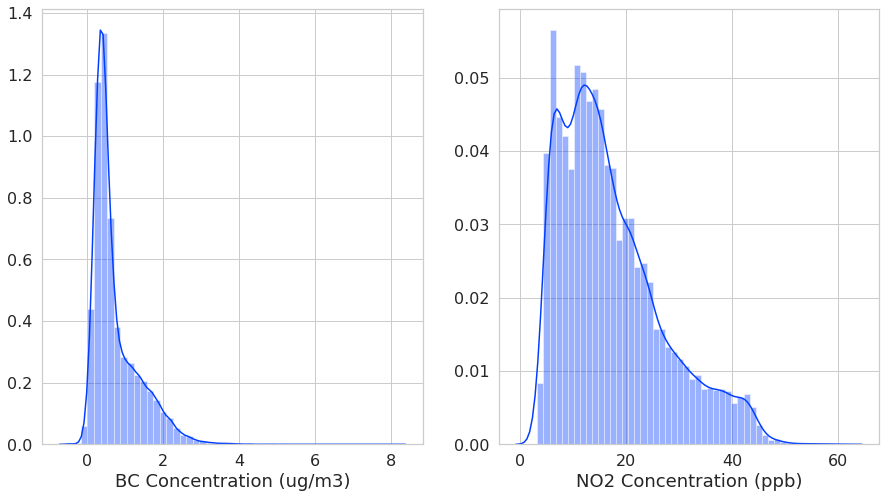

In [56]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.distplot(BC_df['BC Value'], ax = ax1)
ax1.set_xlabel('BC Concentration (ug/m3)', fontsize = 18)
sns.distplot(NO2_df['NO2 Value'], ax = ax2)
ax2.set_xlabel('NO2 Concentration (ppb)', fontsize = 18)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

 -  The distribution of NO2 concentration seems farily normal with BC concentration skewed towards the right indicating that the mean is greater than median - there are some high values in the dataset.

### <font color='red'>  Visualizing the data </font>



In [57]:
geometry_BC = [Point(xy) for xy in zip(BC_df['Longitude'], BC_df['Latitude'])]
geometry_NO2 = [Point(xy) for xy in zip(NO2_df['Longitude'], NO2_df['Latitude'])]

In [58]:
crs = {'init': 'epsg:4326'}

In [59]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_BC = gpd.GeoDataFrame(BC_df, crs = crs, geometry = geometry_BC)
geo_df_NO2 =gpd.GeoDataFrame(NO2_df, crs = crs, geometry = geometry_NO2)

In [60]:
oakl = gpd.read_file('Oakland-shapefile/City of Oakland City Limits/geo_export_8db624a6-e1fa-4921-8dbb-b56e0dce297c.shp')
oakl.crs

{'init': 'epsg:4326'}

In [61]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')
oakl.crs

{'init': 'epsg:4326'}

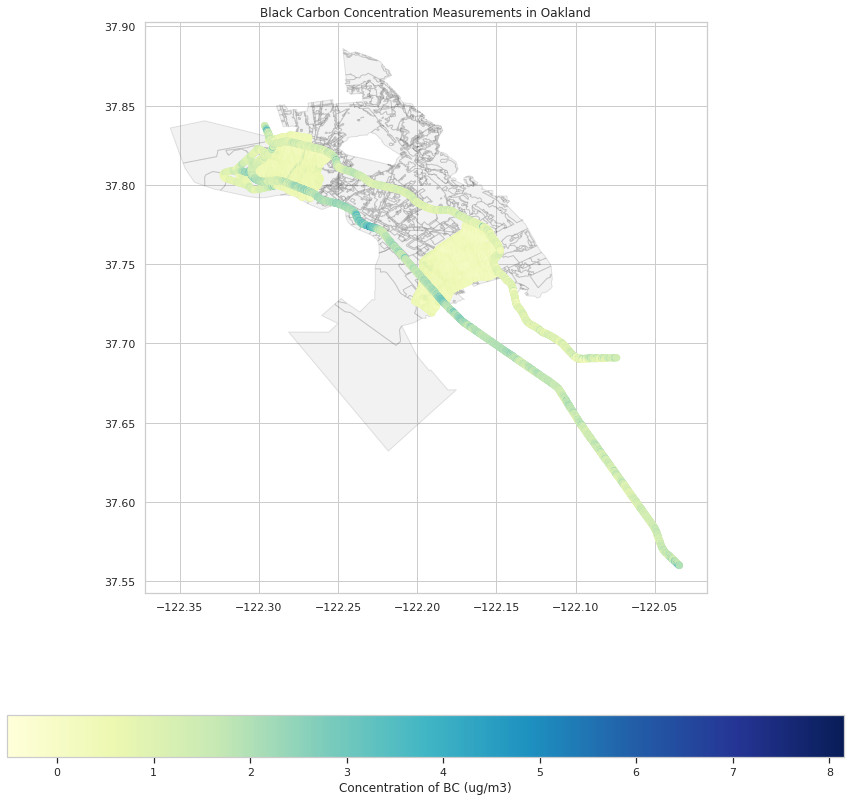

In [62]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df_BC['BC Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df_BC['BC Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df_BC.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'YlGnBu')

sm = cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of BC (ug/m3)')
plt.title("Black Carbon Concentration Measurements in Oakland")
plt.show()

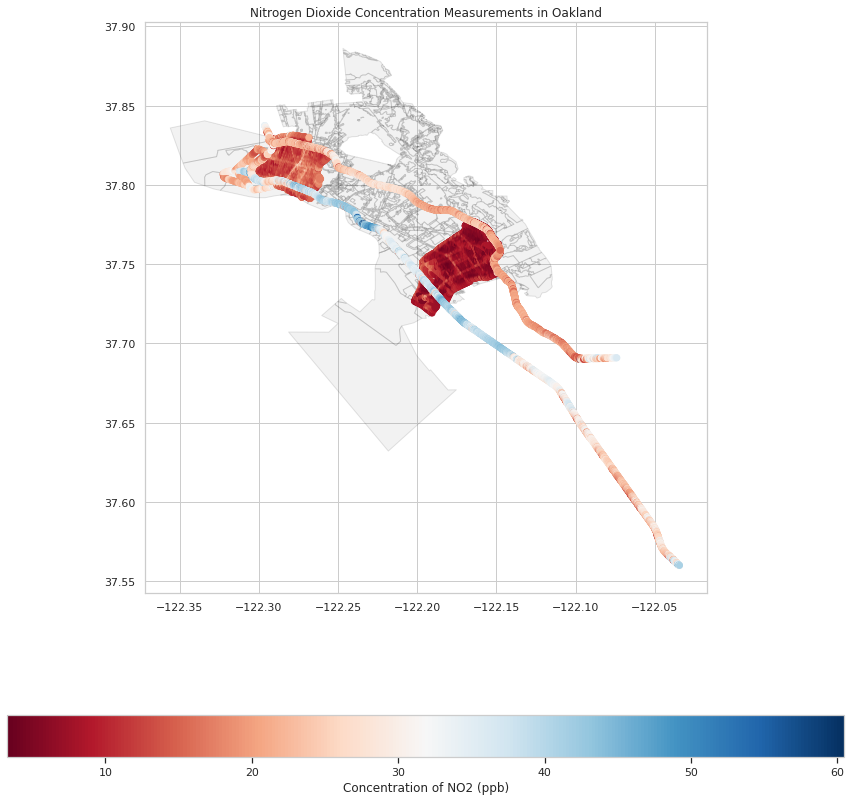

In [63]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df_NO2['NO2 Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df_NO2['NO2 Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df_NO2.plot(ax = ax, column = 'NO2 Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')

sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of NO2 (ppb)')
plt.title("Nitrogen Dioxide Concentration Measurements in Oakland")
plt.show()

### <font color='red'>  Basic Statistical Analysis of Facility Level Data in Oakland </font>



### <font color='red'>  PM2.5 Data </font>

In [66]:
Facility_PM = pd.read_csv("Data/All_PM_Facilities_Final.csv")

In [67]:
Facility_PM.drop(columns = ['Unnamed: 0'], inplace=True)

In [68]:
Facility_PM.tail()

eis facility id  company  source-category   latitude   longitude  \
343         18776511  Unknown    Manufacturing  37.853018 -122.292710   
344         18778911  Unknown        Wholesale  37.712960 -122.188680   
345         18779811  Unknown    Manufacturing  37.707820 -122.185500   
346         18782611  Unknown  Waste-Recycling  37.759959 -122.207782   
347         18787011  Unknown    Manufacturing  37.766939 -122.216336   

            city       PM25       PM10 units      source-type  
343     BERKELEY   0.010500   0.010500   TON    Manufacturing  
344  SAN-LEANDRO  22.124544  22.971518   TON        Wholesale  
345  SAN-LEANDRO   0.000015   0.000015   TON    Manufacturing  
346      OAKLAND   0.992654   1.030213   TON  Waste-Recycling  
347      OAKLAND   0.079014   0.131690   TON    Manufacturing

In [69]:
Facility_PM.describe()[['latitude','longitude','PM25','PM10']]

latitude   longitude          PM25          PM10
count  348.000000  348.000000  3.480000e+02  3.480000e+02
mean    37.785381 -122.239371  4.811451e-01  6.368840e-01
std      0.053832    0.052052  2.289948e+00  2.978462e+00
min     37.674500 -122.319375  4.000000e-09  5.000000e-09
25%     37.742283 -122.278356  1.342943e-04  1.438983e-04
50%     37.795385 -122.259050  6.924440e-04  7.594420e-04
75%     37.817870 -122.196720  2.344960e-02  2.608391e-02
max     37.888535 -122.107740  2.212454e+01  2.626146e+01

In [70]:
Facility_PM.shape

(348, 10)

#### <font color='red'> Histogram of Emissions </font>

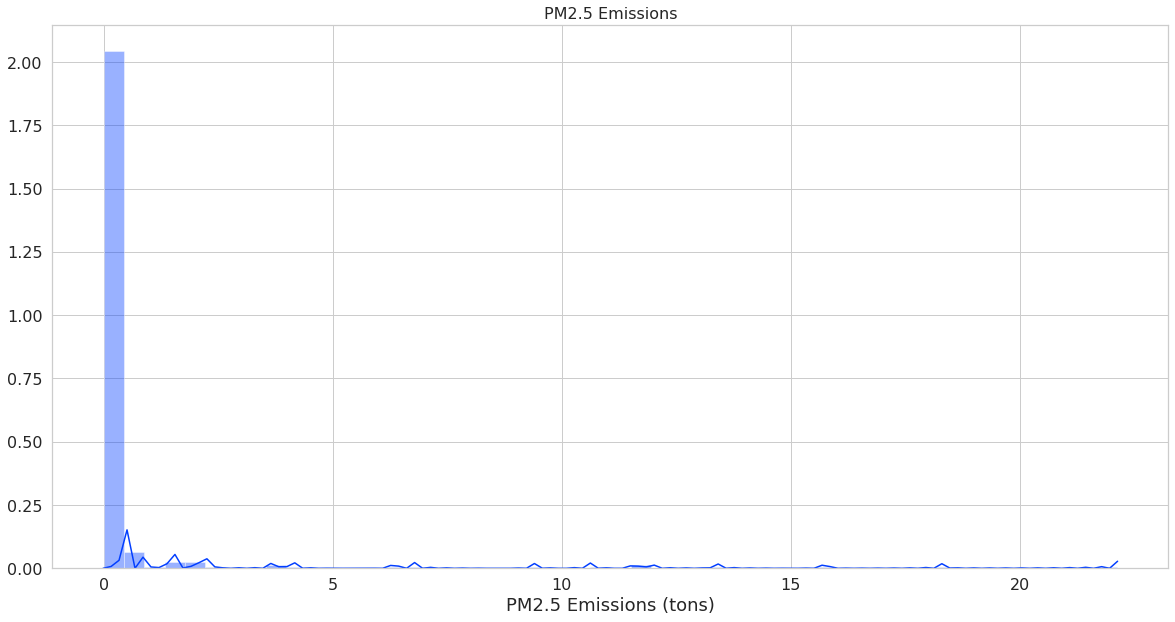

In [71]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(Facility_PM['PM25'], ax = ax)
ax.set_xlabel('PM2.5 Emissions (tons)', fontsize = 18)
ax.set_title('PM2.5 Emissions', fontsize = 16)
ax.tick_params(labelsize=16)


 - Based on the above plot, the emissions data seems to be heavily skewed right, indicating that there are several facilities with very small emissions. Doing a boxcox transformation of the dataset to plot on a log scale

In [72]:
Facility_PM['PM25-transform'] = boxcox(Facility_PM['PM25'], lmbda=0.0)

#### <font color='red'> Histogram of Transformed Data </font>


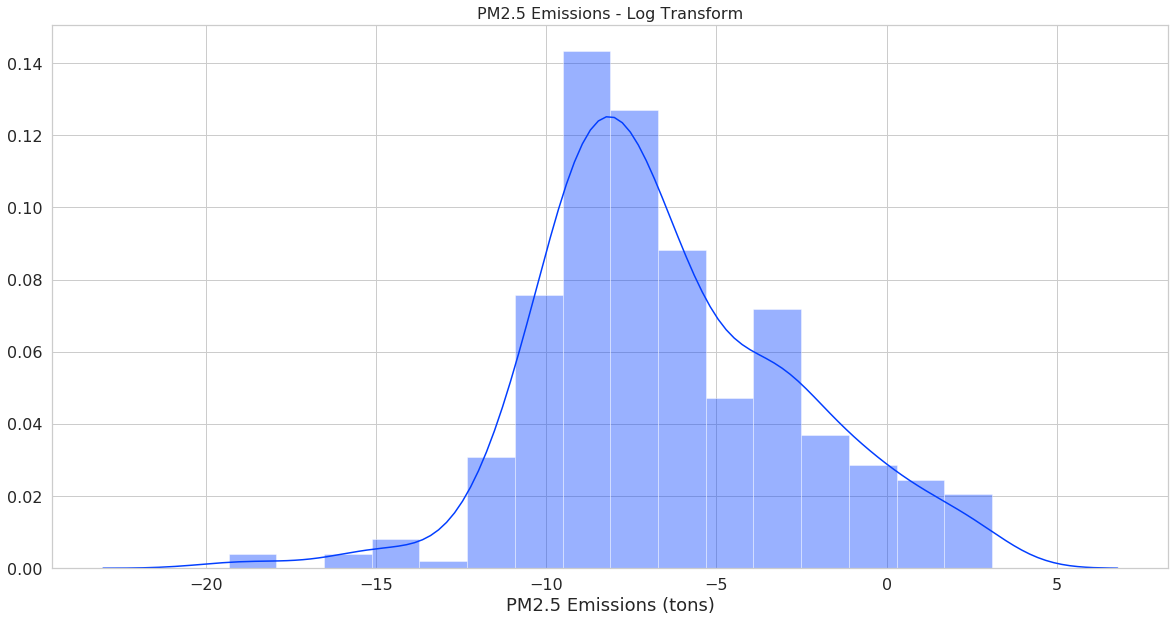

In [73]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(Facility_PM['PM25-transform'], ax = ax)
ax.set_xlabel('PM2.5 Emissions (tons)', fontsize = 18)
ax.set_title('PM2.5 Emissions - Log Transform', fontsize = 16)
ax.tick_params(labelsize=16)


 -  The log transformed data looks more normal than the non-transformed data - we'll use the log transformed data moving forward

#### <font color='red'> Analysis of Data grouped by Source type </font>


In [74]:
### Group-by source type to identify small sources - non-transformed data
Facility_PM.groupby('source-type').describe()['PM25'].sort_values('count')

count      mean        std           min       25%       50%  \
source-type                                                                     
Landfill           1.0  0.877110        NaN  8.771096e-01  0.877110  0.877110   
Bakeries           1.0  0.072196        NaN  7.219629e-02  0.072196  0.072196   
Breweries          1.0  0.086911        NaN  8.691087e-02  0.086911  0.086911   
USCG               1.0  0.000142        NaN  1.424210e-04  0.000142  0.000142   
Stadium            1.0  0.000520        NaN  5.199640e-04  0.000520  0.000520   
DataCenter         1.0  0.003173        NaN  3.173066e-03  0.003173  0.003173   
Solvent            1.0  0.041635        NaN  4.163528e-02  0.041635  0.041635   
FiberGlass         1.0  0.470400        NaN  4.704000e-01  0.470400  0.470400   
PipePlant          1.0  6.331136        NaN  6.331136e+00  6.331136  6.331136   
Pharma             1.0  0.320284        NaN  3.202845e-01  0.320284  0.320284   
Parking            1.0  0.000678        NaN  6.780660e-04  0.000678  0.000678   
AsphaltPlant       3.0  6.837640  10.028562  5.321666e-03  1.081054  2.156786   
GasStation         3.0  0.016705   0.025301  1.643050e-04  0.002142  0.004120   
WWTP               4.0  0.978538   1.954678  3.610070e-04  0.000662  0.001619   
Airport            4.0  0.002723   0.002082  8.222750e-04  0.001143  0.002395   
Foundaries         4.0  4.067754   5.593138  4.396270e-02  0.095538  2.142470   
EGen               4.0  3.819885   6.392309  3.807660e-02  0.315342  0.938171   
Crematory          4.0  0.012230   0.019066  6.680580e-04  0.002078  0.003774   
ConcretePlant      5.0  5.363140   5.345408  1.415459e-02  2.200408  2.363716   
AutoRepair         6.0  0.340711   0.714142  1.960000e-07  0.000584  0.002086   
Waste-Recycling    6.0  0.301820   0.391322  1.963570e-04  0.007719  0.174661   
Port               7.0  0.218861   0.557738  2.190500e-05  0.000230  0.000630   
FoodPlant         11.0  1.459918   2.871027  4.921300e-05  0.021049  0.056062   
Metals            12.0  0.030230   0.062929  4.000000e-09  0.000359  0.001574   
Wholesale         12.0  1.922936   6.363917  3.581400e-05  0.000236  0.006921   
Transportation    14.0  0.000970   0.001457  3.570000e-07  0.000076  0.000205   
Residential       22.0  0.003942   0.012319  1.100000e-08  0.000060  0.000151   
Retail            25.0  0.001699   0.006343  3.440000e-07  0.000013  0.000110   
Manufacturing     32.0  0.600640   2.781110  1.480400e-05  0.000399  0.006765   
Institution      159.0  0.075997   0.553473  7.600000e-08  0.000106  0.000482   

                       75%        max  
source-type                            
Landfill          0.877110   0.877110  
Bakeries          0.072196   0.072196  
Breweries         0.086911   0.086911  
USCG              0.000142   0.000142  
Stadium           0.000520   0.000520  
DataCenter        0.003173   0.003173  
Solvent           0.041635   0.041635  
FiberGlass        0.470400   0.470400  
PipePlant         6.331136   6.331136  
Pharma            0.320284   0.320284  
Parking           0.000678   0.000678  
AsphaltPlant     10.253799  18.350812  
GasStation        0.024975   0.045830  
WWTP              0.979495   3.910555  
Airport           0.003976   0.005282  
Foundaries        6.114686  11.942115  
EGen              4.442713  13.365122  
Crematory         0.013925   0.040705  
ConcretePlant    10.655405  11.582016  
AutoRepair        0.192897   1.783508  
Waste-Recycling   0.431174   0.992654  
Port              0.023877   1.483163  
FoodPlant         1.362632   9.369193  
Metals            0.012422   0.201517  
Wholesale         0.145248  22.124544  
Transportation    0.001262   0.003968  
Residential       0.000294   0.050651  
Retail            0.000481   0.031894  
Manufacturing     0.054333  15.756875  
Institution       0.002887   6.764825

 -  There are a total of 348 stationary sources of black carbon (PM2.5) emissions in Oakland. The maximum emissions from these sources is roughly 22 tons of PM10indicating that one of the facility is large. The largest emittors in this area are Asphalt Plants, Concrete/Pipe manufacturing plants, Concrete batch processing plants, and food manufacturing plants like coffee. 

 -  Looking at this list of sources, there are 159 sources classified as institutions which includ office buildings, schools, hospitals, lab facilities colleges etc. and 32 manufacturing facilities in the area

In [75]:
### Box-plot by source-type to identify and combine sources of emissions that are small
### First melt the data into its long form where the column is the source type and row is the value

#### <font color='red'> Box Plot of PM2.5 Emissions by Source Type </font>


In [76]:
Facility_PM_long = pd.melt(Facility_PM, id_vars='source-type', value_vars = 'PM25')

In [77]:
Facility_PM_long.head()

source-type variable     value
0  Institution     PM25  0.000731
1  Institution     PM25  0.002173
2  Institution     PM25  0.008291
3  Institution     PM25  0.000706
4  Institution     PM25  0.001554

In [78]:
### Before creating box-plot, sort the index by descending order

In [79]:
median_Facility_PM = Facility_PM_long.groupby('source-type').median()
median_Facility_PM.sort_values(by = 'value', ascending=False, inplace=True)
median_Facility_PM.index.values


array(['PipePlant', 'ConcretePlant', 'AsphaltPlant', 'Foundaries', 'EGen',
       'Landfill', 'FiberGlass', 'Pharma', 'Waste-Recycling', 'Breweries',
       'Bakeries', 'FoodPlant', 'Solvent', 'Wholesale', 'Manufacturing',
       'GasStation', 'Crematory', 'DataCenter', 'Airport', 'AutoRepair',
       'WWTP', 'Metals', 'Parking', 'Port', 'Stadium', 'Institution',
       'Transportation', 'Residential', 'USCG', 'Retail'], dtype=object)

Text(0.5, 0, ' ')

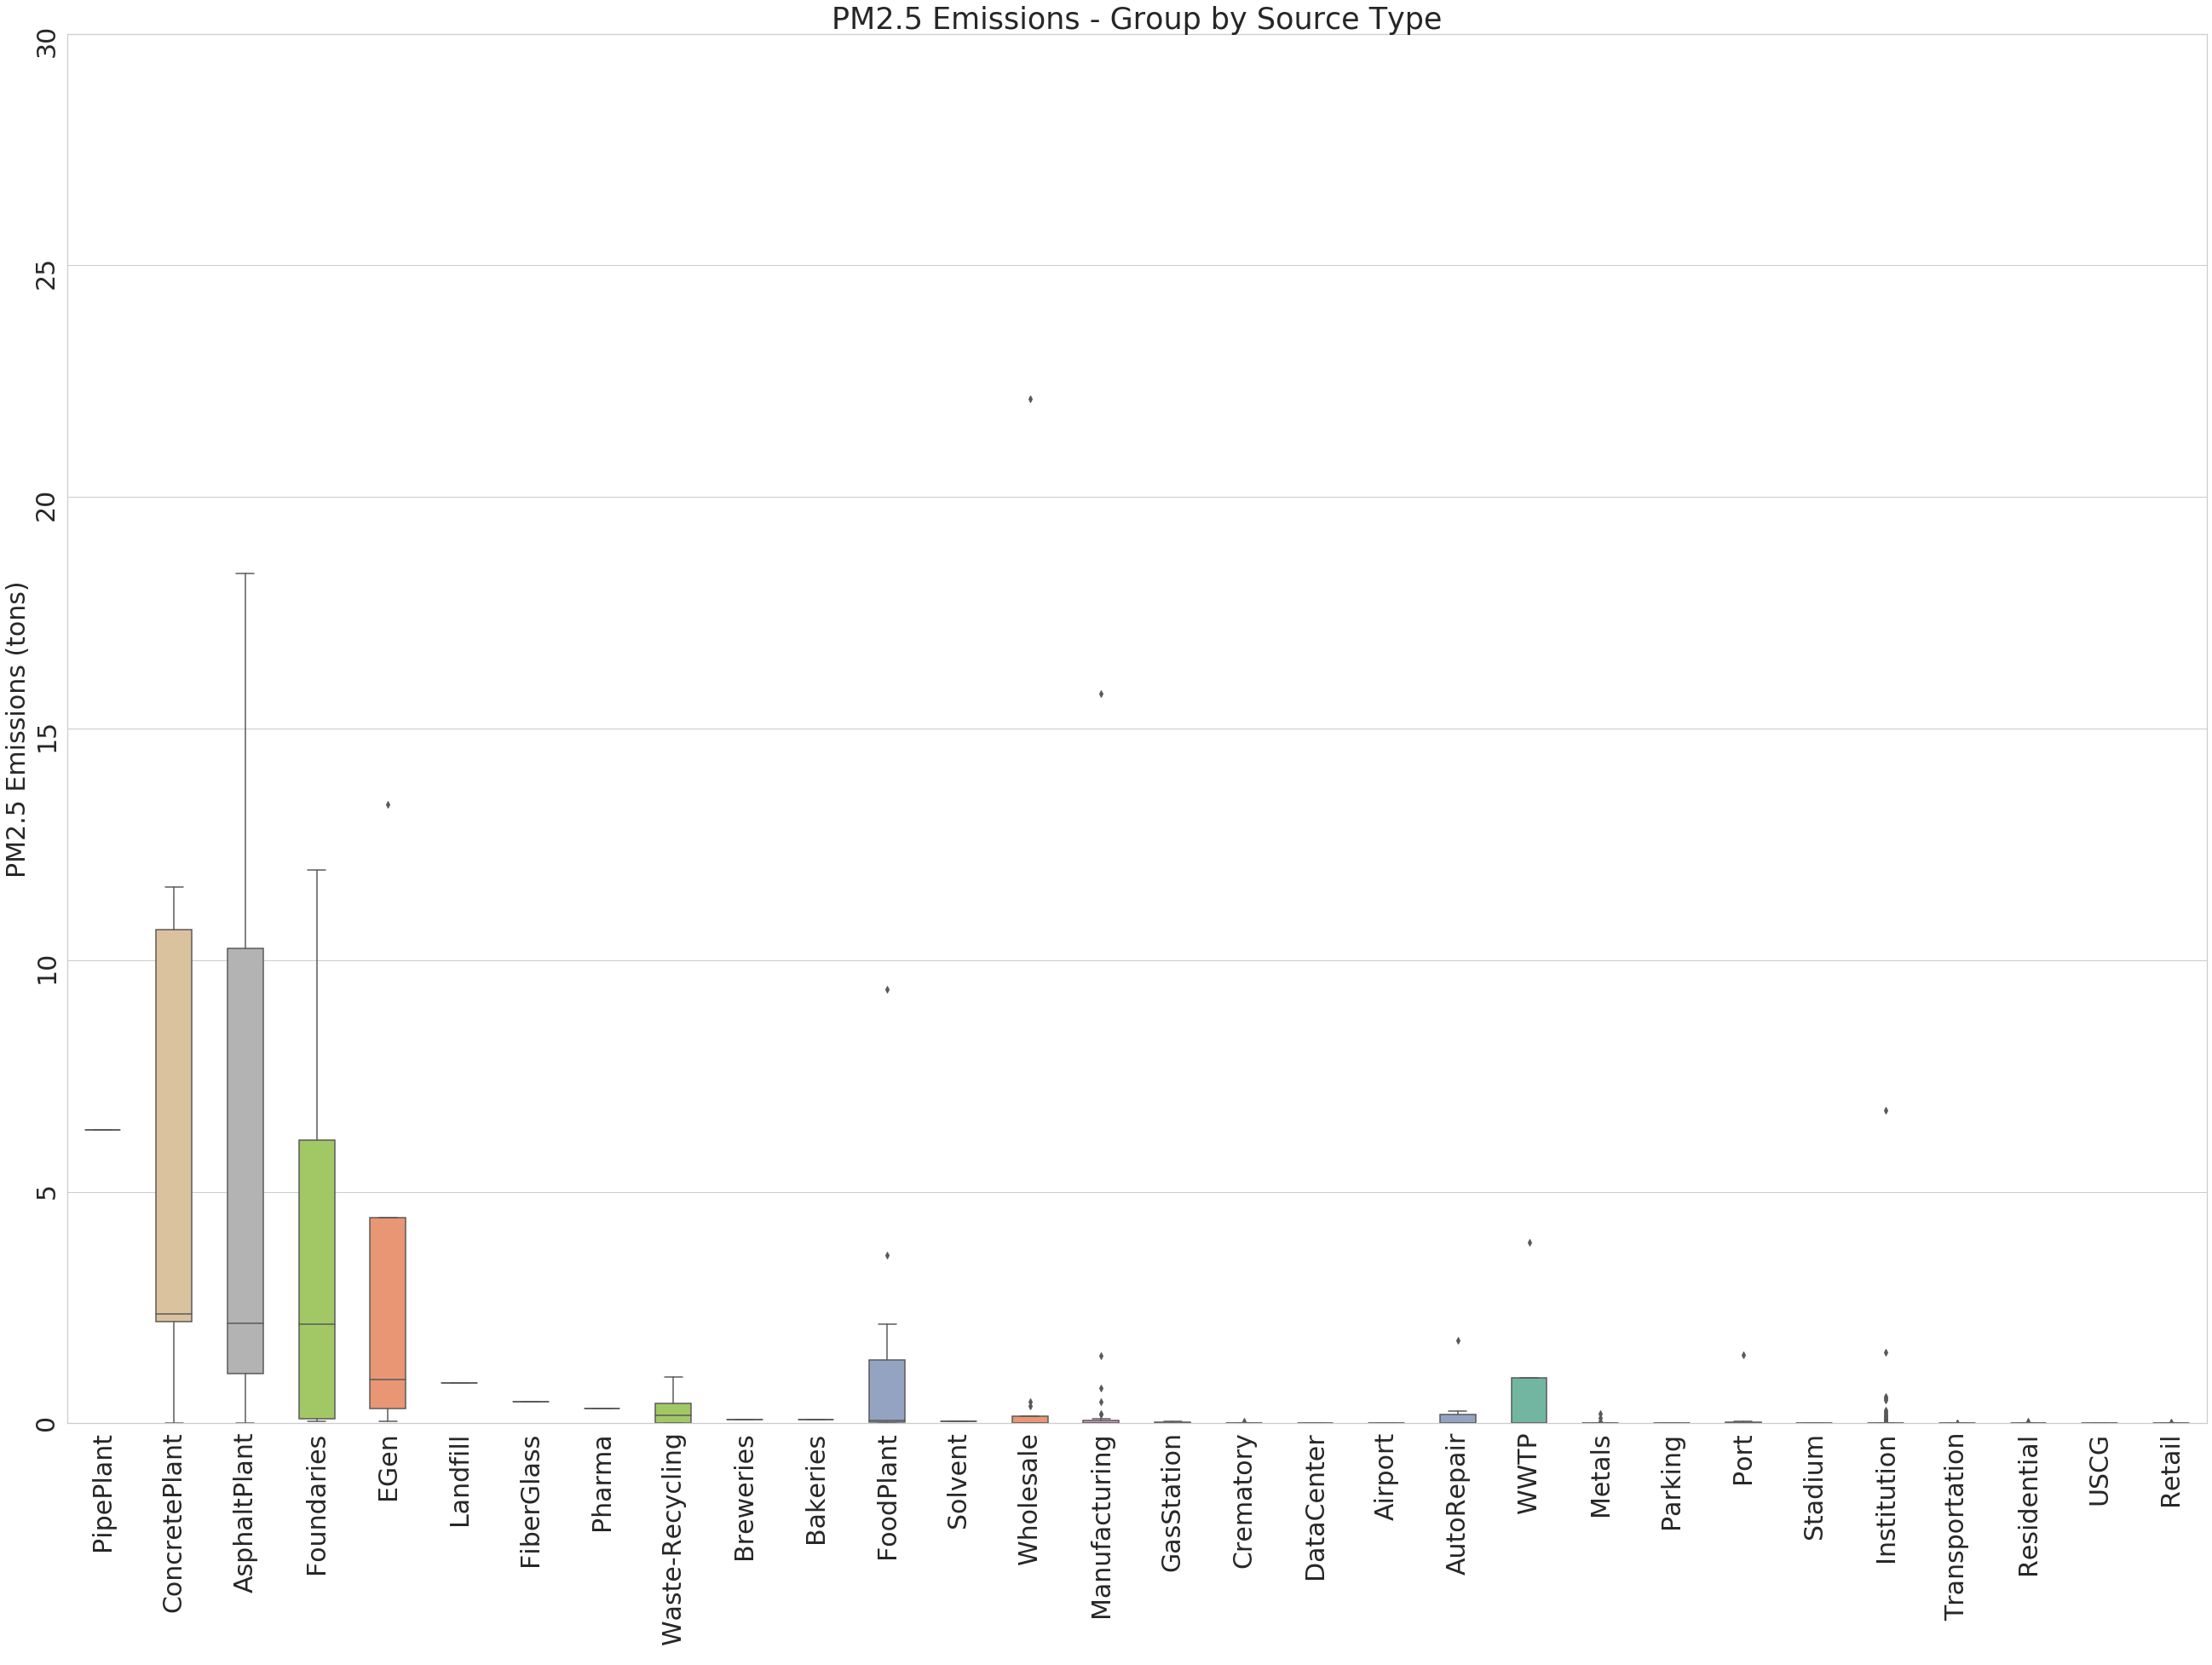

In [80]:
#### Box-plot of PM2.5 data by source type
sns.set(style = 'whitegrid')
sns.set_palette('bright')
fig, ax = plt.subplots(figsize=(45, 30))
sns.boxplot(x="source-type", hue="source-type", y="value", palette="Set2" ,data=Facility_PM_long, width = 0.5, dodge = False,
           order =median_Facility_PM.index.values)
#ax.set_xlabel('Source-Type', fontsize = 18, rotation = 4
ax.set_title('PM2.5 Emissions - Group by Source Type', fontsize = 35)
ax.tick_params(labelsize=30, rotation = 90)
ax.legend_.remove()
ax.set_ylim(0,30)
ax.set_ylabel('PM2.5 Emissions (tons)', fontsize = 30)
ax.set_xlabel(' ')


 -  From the above plot, we see that there are some very large sources of emissions (electricity generating units, concrete plant, asphalt plant, food plants, foundaries, and wholesale). All other sources of emissions are relatively small and can be combined into groups

#### <font color='red'> Combining Source Types to Reduce Number of Distinct Sources </font>


In [81]:
# The following sources can be combined into one single source group
# Transportation <--> Port, Airport, Transportation, Parking, USCG
# Manufacturing <--> Pharma, Manufacturing, FiberGlass, Metals, Solvent, PipePlant
# Eateries <--> Breweries, Bakeries
# Retail-Res <--> Wholesale, retail, Residential
# Waste <--> Waste Recycling, Landfill
# Misc <--> Stadium, DataCenter, GasStation, Crematory


In [82]:
# Transportation <--> Port, Airport, Transportation, Parking, USCG
Facility_PM.loc[(Facility_PM['source-type'] == 'Port') | (Facility_PM['source-type'] == 'Airport')|
                (Facility_PM['source-type'] == 'Parking') | (Facility_PM['source-type'] == 'USCG'),'source-type']='Transportation'


In [83]:
# Manufacturing <--> Pharma, Manufacturing, FiberGlass, Metals, Solvent, PipePlant
Facility_PM.loc[(Facility_PM['source-type'] == 'Pharma') | (Facility_PM['source-type'] == 'Metals')|
                (Facility_PM['source-type'] == 'FiberGlass') | (Facility_PM['source-type'] == 'Solvent') | 
                (Facility_PM['source-type'] == 'PipePlant'),'source-type']='Manufacturing'


In [84]:
# Eateries <--> Breweries, Bakeries
Facility_PM.loc[(Facility_PM['source-type'] == 'Bakeries') | 
                (Facility_PM['source-type'] == 'Breweries') ,'source-type']='Eateries'

In [85]:
# Retail-Res <--> Wholesale, retail, Residential, Institution
Facility_PM.loc[(Facility_PM['source-type'] == 'Residential') | (Facility_PM['source-type'] == 'Retail') | 
                (Facility_PM['source-type'] == 'Wholesale') | (Facility_PM['source-type'] == 'Institution') ,'source-type']='Retail-Res'

In [86]:
# Waste <--> Waste Recycling, Landfill
Facility_PM.loc[(Facility_PM['source-type'] == 'Waste-Recycling') | 
                (Facility_PM['source-type'] == 'Landfill') ,'source-type']='Waste'

In [87]:
# Misc <--> Stadium, DataCenter, GasStation, Crematory
Facility_PM.loc[(Facility_PM['source-type'] == 'Stadium') | (Facility_PM['source-type'] == 'DataCenter') | 
                (Facility_PM['source-type'] == 'Crematory') | (Facility_PM['source-type'] == 'GasStation') ,'source-type']='Misc'


#### <font color='red'> Boxplot of PM2.5 Emissions with Combined Source Groups </font>


In [88]:
Facility_PM_long = pd.melt(Facility_PM, id_vars='source-type', value_vars = 'PM25')

In [89]:
Facility_PM_long.head()

source-type variable     value
0  Retail-Res     PM25  0.000731
1  Retail-Res     PM25  0.002173
2  Retail-Res     PM25  0.008291
3  Retail-Res     PM25  0.000706
4  Retail-Res     PM25  0.001554

In [90]:
### Before creating box-plot, sort the index by descending order
median_Facility_PM = Facility_PM_long.groupby('source-type').median()
median_Facility_PM.sort_values(by = 'value', ascending=False, inplace=True)
median_Facility_PM.index.values

array(['ConcretePlant', 'AsphaltPlant', 'Foundaries', 'EGen', 'Waste',
       'Eateries', 'FoodPlant', 'Manufacturing', 'Misc', 'AutoRepair',
       'WWTP', 'Transportation', 'Retail-Res'], dtype=object)

Text(0.5, 0, ' ')

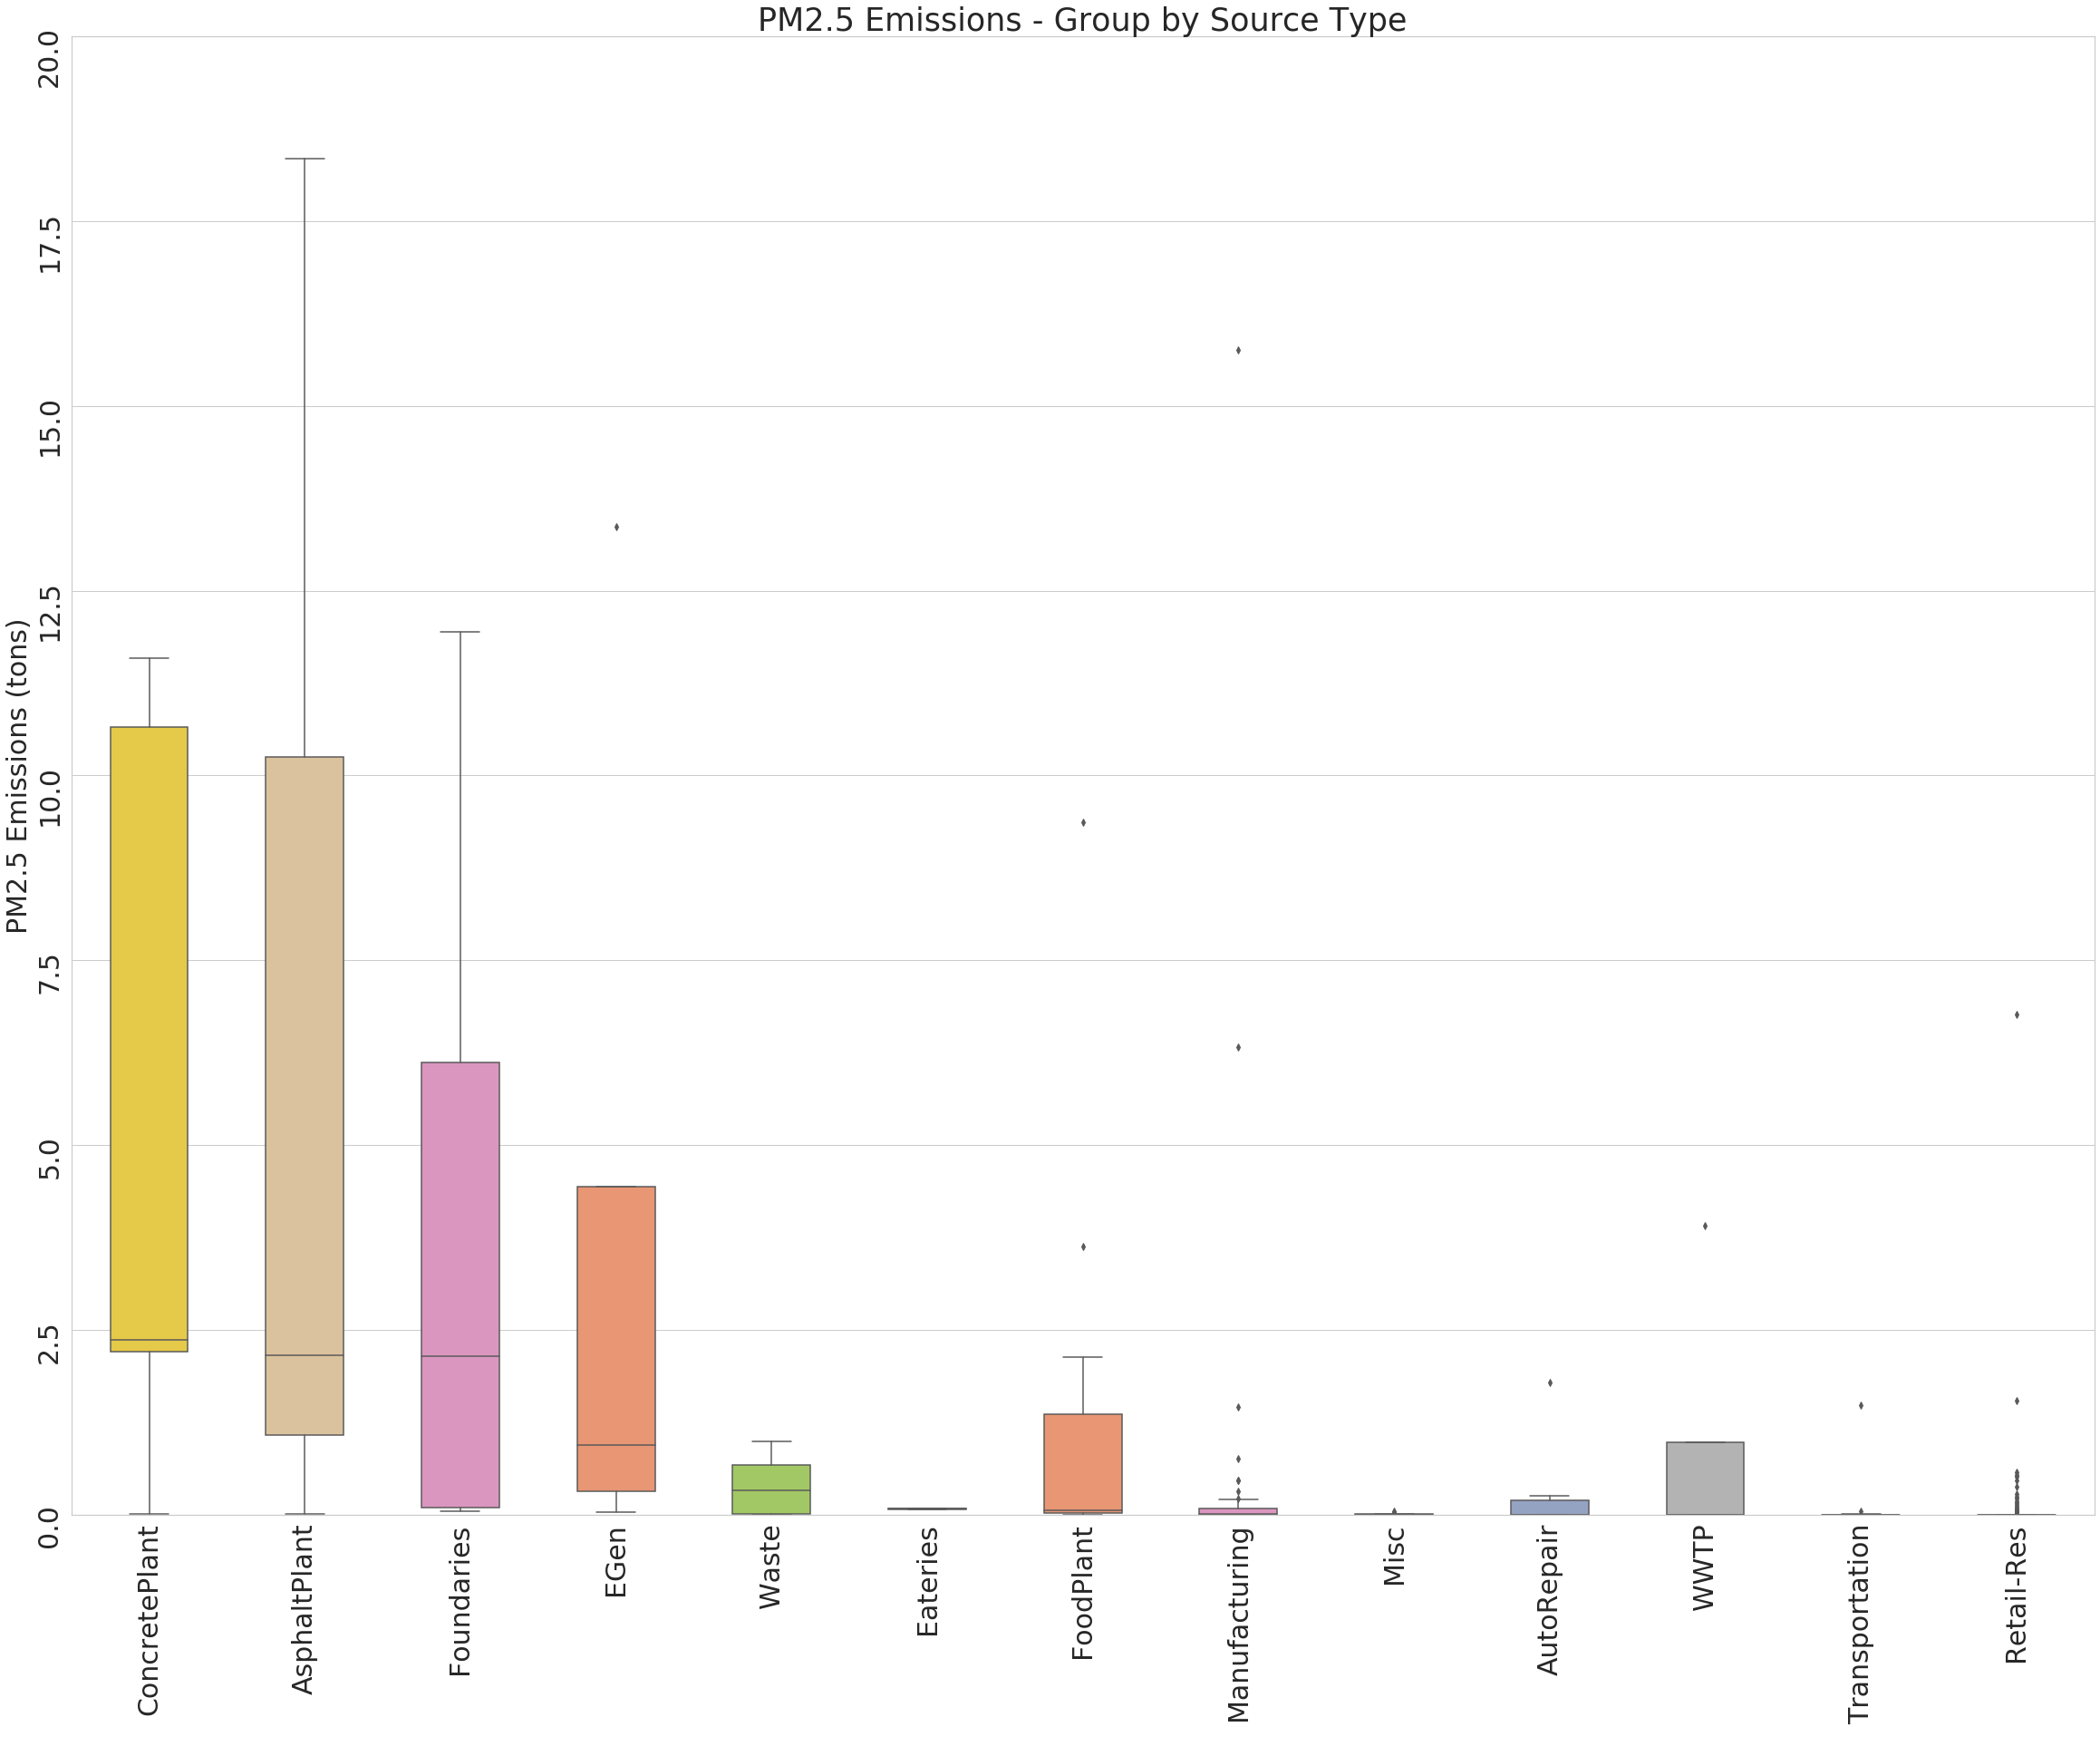

In [91]:
#### Box-plot of PM2.5 data by source type

fig, ax = plt.subplots(figsize=(40, 30))
sns.boxplot(x="source-type", hue="source-type", y="value", palette="Set2" ,data=Facility_PM_long, width = 0.5, dodge = False,
           order =median_Facility_PM.index.values)
#ax.set_xlabel('Source-Type', fontsize = 18, rotation = 4
ax.set_title('PM2.5 Emissions - Group by Source Type', fontsize = 35)
ax.tick_params(labelsize=30, rotation = 90)
ax.legend_.remove()
ax.set_ylim(0,20)
ax.set_ylabel('PM2.5 Emissions (tons)', fontsize = 30)
ax.set_xlabel(' ')


#### Next, categorize each facility as 'Small/Medium/Large' depending on the quantity of emissions. Facilities are classified based on the following categories:
    #### Emissions Lower than first quartile - Low
    #### Emissions Between first and 3rd quartile - Medium
    #### Emissions Above 3rd quartile - High

In [92]:
Facility_PM.groupby('source-type').describe()['PM25'].sort_values('count')

count      mean        std           min       25%       50%  \
source-type                                                                    
Eateries          2.0  0.079554   0.010405  7.219629e-02  0.075875  0.079554   
AsphaltPlant      3.0  6.837640  10.028562  5.321666e-03  1.081054  2.156786   
EGen              4.0  3.819885   6.392309  3.807660e-02  0.315342  0.938171   
Foundaries        4.0  4.067754   5.593138  4.396270e-02  0.095538  2.142470   
WWTP              4.0  0.978538   1.954678  3.610070e-04  0.000662  0.001619   
ConcretePlant     5.0  5.363140   5.345408  1.415459e-02  2.200408  2.363716   
AutoRepair        6.0  0.340711   0.714142  1.960000e-07  0.000584  0.002086   
Waste             7.0  0.384005   0.418199  1.963570e-04  0.010086  0.334503   
Misc              9.0  0.011414   0.018180  1.643050e-04  0.000668  0.003173   
FoodPlant        11.0  1.459918   2.871027  4.921300e-05  0.021049  0.056062   
Transportation   27.0  0.057679   0.285009  3.570000e-07  0.000131  0.000421   
Manufacturing    48.0  0.557223   2.427134  4.000000e-09  0.000438  0.004465   
Retail-Res      218.0  0.161871   1.567935  1.100000e-08  0.000080  0.000378   

                      75%        max  
source-type                           
Eateries         0.083232   0.086911  
AsphaltPlant    10.253799  18.350812  
EGen             4.442713  13.365122  
Foundaries       6.114686  11.942115  
WWTP             0.979495   3.910555  
ConcretePlant   10.655405  11.582016  
AutoRepair       0.192897   1.783508  
Waste            0.670254   0.992654  
Misc             0.004999   0.045830  
FoodPlant        1.362632   9.369193  
Transportation   0.003133   1.483163  
Manufacturing    0.084241  15.756875  
Retail-Res       0.002213  22.124544

In [93]:
Facility_PM.loc[:,'ems-type'] = pd.qcut(Facility_PM['PM25'], q = [0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

In [94]:
Facility_PM.head(50)

eis facility id                         company  \
0            126911                    PACIFIC-BELL   
1            127111                    PACIFIC-BELL   
2            127511                    PACIFIC-BELL   
3            127611                    PACIFIC-BELL   
4            127711                    PACIFIC-BELL   
5            127811                    PACIFIC-BELL   
6            128211                    PACIFIC-BELL   
7            130511               KAISER-PERMANENTE   
8            136511     NORTHERN-CALIF-POWER-AGENCY   
9            137211  KAISER-PERMANENTE-MEDICAL-CENT   
10           138911    PRECISION-TECHNICAL-COATINGS   
11           139211   AGRICULTURAL-RESEARCH-SERVICE   
12           140211   SVC-MANUFACTURING-INC-DBA-PEP   
13           141411     AC-TRANSIT-DISTRICT-CENTRAL   
14           168111  EAST-BAY-DISCHARGERS-AUTHORITY   
15           168411                        CASS-INC   
16           172211                    PACIFIC-BELL   
17           192811       NOR-CAL-METAL-FABRICATORS   
18           193011     HAWKINS-HAWKINS-COMPANY-INC   
19           193511  CEMEX-CONSTRUCTION-MATERIALS-P   
20           194911             AC-TRANSIT-DISTRICT   
21           195711       CONSOLIDATED-PRINTERS-INC   
22           196511  PACIFIC-GAS-AND-ELECTRIC-COMPA   
23           200311        WESTERN-COLLOID-PRODUCTS   
24           200611  ALTA-BATES-SUMMIT-MEDICAL-CENT   
25           203711   CITY-OF-BERKELEY-DEPT-OF-PUBL   
26           203811  SAN-LEANDRO-WATER-POLLUTION-CO   
27           309711  MOUNTAIN-VIEW-CEMETERY-ASSOCIA   
28           310211               HIGHLAND-HOSPITAL   
29           310411                ALAMEDA-HOSPITAL   
30           337111  ELECTRO-COATINGS-OF-CALIFORNIA   
31           338411                   WRE-COLORTECH   
32           338911             ALTA-BATES-HOSPITAL   
33           340611        GHIRARDELLI-CHOCOLATE-CO   
34           343011                     MR-ESPRESSO   
35           375111             TAKARA-SAKE-USA-INC   
36           375611                 WEATHERFORD-BMW   
37           379511  EAST-BAY-MUNICIPAL-UTILITY-DIS   
38           380611    ROLLS-ROYCE-ENGINE-SERVICES-   
39           382111                 A-B-&-I-FOUNDRY   
40           382911              EVERGREEN-CEMETERY   
41           383211       B-&-P-CULTURED-MARBLE-INC   
42           383511      L-A-SMITH-&-SONS-BODY-SHOP   
43           400211  ALTA-BATES-SUMMIT-MEDICAL-CENT   
44           400311  ALTA-BATES-SUMMIT-MEDICAL-CENT   
45           403111  EAST-BAY-MUNICIPAL-UTILITY-DIS   
46           405311       BERKELEY-FORGE-&-TOOL-INC   
47           444911                 PORT-OF-OAKLAND   
48           445511      GEORGIA-PACIFIC-GYPSUM-LLC   
49           446611        EAST-BAY-FIXTURE-COMPANY   

                          source-category   latitude   longitude         city  \
0                             Institution  37.766850 -122.249720      ALAMEDA   
1                             Institution  37.867710 -122.267840     BERKELEY   
2                             Institution  37.806030 -122.269460      OAKLAND   
3                             Institution  37.784220 -122.222410      OAKLAND   
4                             Institution  37.833360 -122.263070      OAKLAND   
5                             Institution  37.811860 -122.198400      OAKLAND   
6                             Institution  37.700140 -122.129970  SAN-LEANDRO   
7                             Institution  37.760530 -122.210670      OAKLAND   
8   Electricity-Generation-via-Combustion  37.786830 -122.291080      ALAMEDA   
9                             Institution  37.822690 -122.257570      OAKLAND   
10      Auto-Body-Painting-or-Repair-Shop  37.878390 -122.303300     BERKELEY   
11                            Institution  37.877790 -122.310000     BERKELEY   
12                          Manufacturing  37.760330 -122.205700      OAKLAND   
13                            Institution  37.737150 -122.165750

### Eateries
Eateries = Facility_PM[Facility_PM['source-type'] == 'Eateries']
Eateries.loc[:,'ems-type'] = pd.qcut(Eateries['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### AsphaltPlant
AsphaltPlant = Facility_PM[Facility_PM['source-type'] == 'AsphaltPlant']
AsphaltPlant.loc[:,'ems-type'] = pd.qcut(AsphaltPlant['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### EGen
EGen = Facility_PM[Facility_PM['source-type'] == 'EGen']
EGen.loc[:,'ems-type'] = pd.qcut(EGen['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Foundaries
Foundaries = Facility_PM[Facility_PM['source-type'] == 'Foundaries']
Foundaries.loc[:,'ems-type'] = pd.qcut(Foundaries['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

### WWTP
WWTP = Facility_PM[Facility_PM['source-type'] == 'WWTP']
WWTP.loc[:, 'ems-type'] = pd.qcut(WWTP['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### ConcretePlant
ConcretePlant = Facility_PM[Facility_PM['source-type'] == 'ConcretePlant']
ConcretePlant.loc[:, 'ems-type'] = pd.qcut(ConcretePlant['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### AutoRepair
AutoRepair = Facility_PM[Facility_PM['source-type'] == 'AutoRepair']
AutoRepair.loc[:, 'ems-type'] = pd.qcut(AutoRepair['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Waste
Waste = Facility_PM[Facility_PM['source-type'] == 'Waste']
Waste.loc[:, 'ems-type'] = pd.qcut(Waste['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])



### Misc
Misc = Facility_PM[Facility_PM['source-type'] == 'Misc']
Misc.loc[:, 'ems-type'] = pd.qcut(Misc['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### FoodPlant
FoodPlant = Facility_PM[Facility_PM['source-type'] == 'FoodPlant']
FoodPlant.loc[:, 'ems-type'] = pd.qcut(FoodPlant['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Transportation
Transportation = Facility_PM[Facility_PM['source-type'] == 'Transportation']
Transportation.loc[:, 'ems-type'] = pd.qcut(Transportation['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Manufacturing
Manufacturing = Facility_PM[Facility_PM['source-type'] == 'Manufacturing']
Manufacturing.loc[:, 'ems-type'] = pd.qcut(Manufacturing['PM25'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Retail - Residential Category
RetailRes = Facility_PM[Facility_PM['source-type'] == 'Retail-Res']
RetailRes.loc[:,'ems-type'] = pd.qcut(RetailRes['PM25'],q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])




#### Combine all the dataframes back into one frame
Facility_PM = AsphaltPlant.append(AutoRepair).append(ConcretePlant).append(Eateries).append(EGen).append(FoodPlant).append(Foundaries).append(Manufacturing).append(Misc).append(RetailRes).append(Transportation).append(Waste).append(WWTP)

##### Write this to a new dataframe
Facility_PM.to_csv("Data/PM_Facility_Data.csv")

#### <font color='red'> Plot of number of sources classified as low, medium and high - Divided by Soruce Group </font>


In [96]:
PM_count_df = Facility_PM.groupby(['ems-type','source-type'])['eis facility id'].count()

In [97]:
PM_count_df = PM_count_df.reset_index()

In [98]:
PM_count_df = PM_count_df.pivot(index = 'ems-type', columns = 'source-type', values = 'eis facility id')

In [99]:
PM_count_df.fillna(0)

source-type  AsphaltPlant  AutoRepair  ConcretePlant  EGen  Eateries  \
ems-type                                                               
low                   0.0         1.0            0.0   0.0       0.0   
medium                1.0         3.0            1.0   0.0       0.0   
high                  2.0         2.0            4.0   4.0       2.0   

source-type  FoodPlant  Foundaries  Manufacturing  Misc  Retail-Res  \
ems-type                                                              
low                1.0         0.0            7.0   0.0        71.0   
medium             2.0         0.0           23.0   7.0       113.0   
high               8.0         4.0           18.0   2.0        34.0   

source-type  Transportation  WWTP  Waste  
ems-type                                  
low                     7.0   0.0    0.0  
medium                 18.0   3.0    3.0  
high                    2.0   1.0    4.0

Text(0.5, 0, 'Emissions Type')

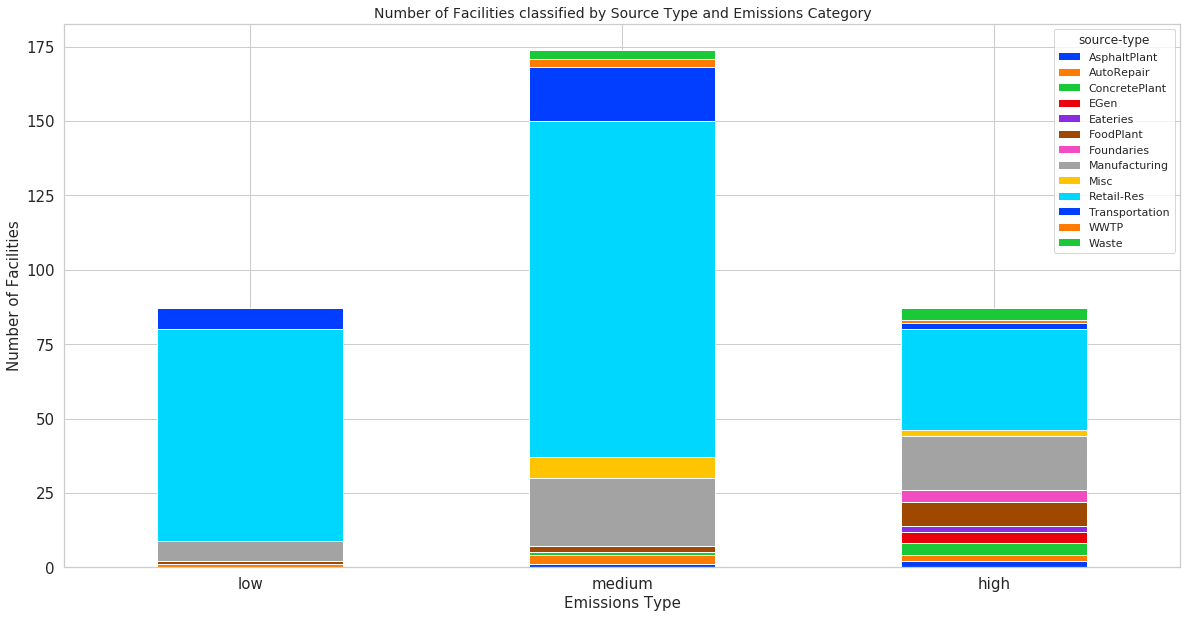

In [100]:
fig, ax = plt.subplots(figsize=(20, 10))
PM_count_df.plot(kind = 'bar', stacked=True, ax = ax)
#PM_count_df.loc[:,['AsphaltPlant','AutoRepair', 'ConcretePlant', 'EGen', 'Eateries', 'FoodPlant', 'Foundaries',
#                  'Manufacturing', 'Misc', 'Retail-Res', 'Transportation', 'WWTP', 'Waste']].plot.bar(stacked=True,  ax = ax)
ax.set_title('Number of Facilities classified by Source Type and Emissions Category', fontsize = 14)
ax.tick_params(labelsize=15, rotation = 0)
ax.set_ylabel('Number of Facilities', fontsize = 15)
ax.set_xlabel('Emissions Type', fontsize = 15)

### <font color='red'>  NO2 Data </font>


In [101]:
Facility_NO2 = pd.read_csv("Data/All_NO2_Facilities_Final.csv")

In [102]:
Facility_NO2.drop(columns = ['Unnamed: 0'], inplace=True)

In [103]:
Facility_NO2.rename(columns = {'total emissions':'NO2'}, inplace=True)

In [104]:
Facility_NO2.shape

(317, 8)

In [105]:
Facility_NO2.describe()[['latitude','longitude','NO2']]

latitude   longitude         NO2
count  317.000000  317.000000  317.000000
mean    37.784917 -122.238598    1.146599
std      0.054163    0.052545    5.263535
min     37.627747 -122.319375    0.000001
25%     37.742080 -122.275210    0.005161
50%     37.796090 -122.259300    0.023459
75%     37.817304 -122.197210    0.205629
max     37.888535 -122.094062   54.110091

#### <font color='red'> Histogram of Emissions </font>

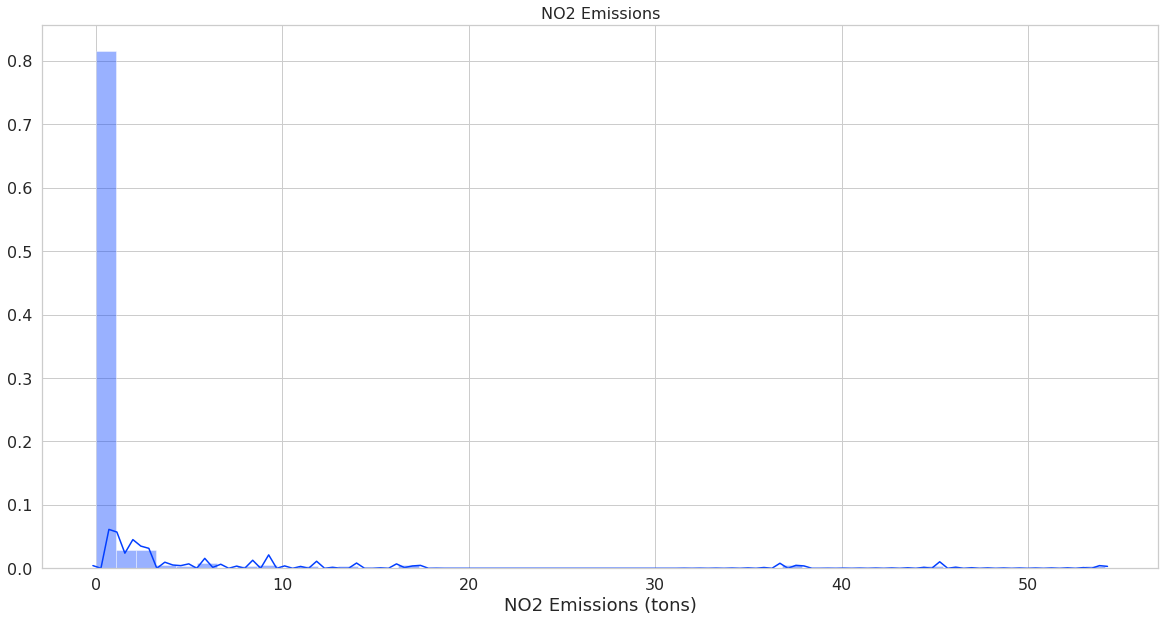

In [106]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(Facility_NO2['NO2'], ax = ax)
ax.set_xlabel('NO2 Emissions (tons)', fontsize = 18)
ax.set_title('NO2 Emissions', fontsize = 16)
ax.tick_params(labelsize=16)


 - Based on the above plot, the emissions data seems to be heavily skewed right, indicating that there are several facilities with very small emissions. Doing a boxcox transformation of the dataset to plot on a log scale

In [107]:
Facility_NO2['NO2-transform'] = boxcox(Facility_NO2['NO2'], lmbda=0.0)

#### <font color='red'> Histogram of Transformed Data </font>


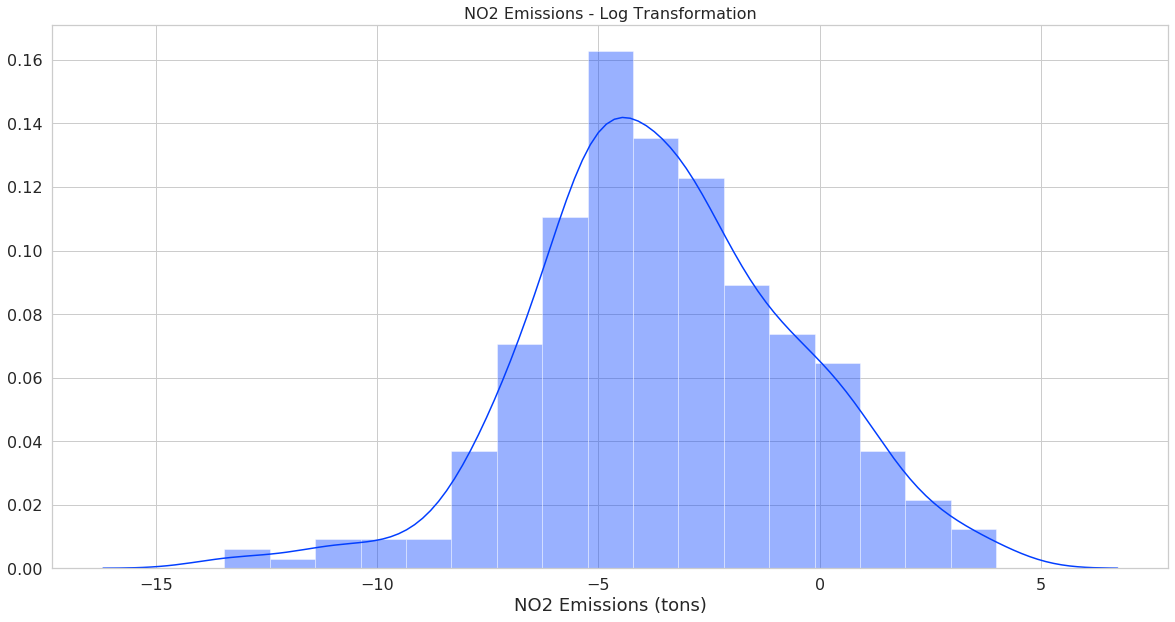

In [108]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(Facility_NO2['NO2-transform'], ax = ax)
ax.set_xlabel('NO2 Emissions (tons)', fontsize = 18)
ax.set_title('NO2 Emissions - Log Transformation', fontsize = 16)
ax.tick_params(labelsize=16)


 -  The log transformed data looks more normal than the non-transformed data - we'll use the log transformed data moving forward

#### <font color='red'> Analysis of Data grouped by Source type </font>


In [109]:
Facility_NO2.groupby('source-type').describe()['NO2'].sort_values('count')

count       mean        std        min        25%        50%  \
source-type                                                                     
Solvent            1.0   1.946185        NaN   1.946185   1.946185   1.946185   
Pharma             1.0  14.049045        NaN  14.049045  14.049045  14.049045   
Parking            1.0   0.050671        NaN   0.050671   0.050671   0.050671   
Bakeries           1.0   0.984748        NaN   0.984748   0.984748   0.984748   
Breweries          1.0   3.772830        NaN   3.772830   3.772830   3.772830   
DataCenter         1.0   0.425762        NaN   0.425762   0.425762   0.425762   
Landfill           1.0   2.586823        NaN   2.586823   2.586823   2.586823   
USCG               1.0   0.008888        NaN   0.008888   0.008888   0.008888   
Stadium            1.0   0.022925        NaN   0.022925   0.022925   0.022925   
Waste-Recycling    2.0   0.063171   0.085356   0.002815   0.032993   0.063171   
GasStation         2.0   0.525343   0.742926   0.000015   0.262679   0.525343   
Foundaries         3.0  14.344039  20.288321   2.340315   2.631780   2.923244   
AutoRepair         3.0   0.094665   0.109193   0.022717   0.031842   0.040967   
AsphaltPlant       3.0   3.728380   4.977064   0.082914   0.893208   1.703503   
EGen               4.0  13.508670  21.479312   0.182181   0.269487   4.319000   
Crematory          4.0   0.396342   0.465451   0.039582   0.134881   0.235127   
WWTP               4.0   9.691156  18.104890   0.021549   0.025621   0.963497   
Airport            4.0   0.055922   0.047546   0.005927   0.034714   0.048748   
Metals             6.0   0.373208   0.499531   0.018697   0.025856   0.085099   
Port               6.0   0.165115   0.335229   0.003118   0.006108   0.030115   
Wholesale         11.0   1.872897   5.134503   0.000018   0.006169   0.010310   
FoodPlant         11.0   3.209890   5.266220   0.001549   0.095315   0.439633   
Transportation    14.0   0.038281   0.057529   0.000059   0.004800   0.015352   
Residential       22.0   0.049904   0.193695   0.000002   0.001438   0.005045   
Manufacturing     26.0   0.843075   2.329596   0.000270   0.008458   0.078416   
Retail            27.0   0.039288   0.144892   0.000006   0.000647   0.005073   
Institution      156.0   0.676809   4.412720   0.000001   0.005571   0.025801   

                       75%        max  
source-type                            
Solvent           1.946185   1.946185  
Pharma           14.049045  14.049045  
Parking           0.050671   0.050671  
Bakeries          0.984748   0.984748  
Breweries         3.772830   3.772830  
DataCenter        0.425762   0.425762  
Landfill          2.586823   2.586823  
USCG              0.008888   0.008888  
Stadium           0.022925   0.022925  
Waste-Recycling   0.093349   0.123527  
GasStation        0.788007   1.050671  
Foundaries       20.345901  37.768557  
AutoRepair        0.130639   0.220310  
AsphaltPlant      5.551113   9.398723  
EGen             17.558183  45.214501  
Crematory         0.496588   1.075531  
WWTP             10.629033  36.816083  
Airport           0.069955   0.120264  
Metals            0.768352   1.048138  
Port              0.069401   0.846742  
Wholesale         0.564862  17.222894  
FoodPlant         4.150409  16.273238  
Transportation    0.037796   0.170321  
Residential       0.011439   0.915444  
Manufacturing     0.454051  11.806007  
Retail            0.014314   0.758439  
Institution       0.121586  54.110091

 -  There are a total of 317 stationary sources of Nitrogen dioxide (NO2) emissions in Oakland. The maximum emissions from these sources is roughly 54 tons of NO2 indicating that one of the facility is large. The largest emittors in this area are Food Plants, Foundaries, Electrigity Generating Units and Pharma plants. 

 -  Looking at this list of sources, there are 156 sources classified as institutions which includ office buildings, schools, hospitals, lab facilities colleges etc. and 26 manufacturing facilities in the area

In [110]:
### Box-plot by source-type to identify and combine sources of emissions that are small
### First melt the data into its long form where the column is the source type and row is the value

In [111]:
Facility_NO2_long = pd.melt(Facility_NO2, id_vars='source-type', value_vars = 'NO2')

In [112]:
Facility_NO2_long.head()

source-type variable     value
0  Institution      NO2  0.054659
1  Institution      NO2  0.162383
2  Institution      NO2  0.619550
3  Institution      NO2  0.052783
4  Institution      NO2  0.116122

In [113]:
### Before creating box-plot, sort the index by descending order
median_Facility_NO2 = Facility_NO2_long.groupby('source-type').median()
median_Facility_NO2.sort_values(by = 'value', ascending=False, inplace=True)
median_Facility_NO2.index.values

array(['Pharma', 'EGen', 'Breweries', 'Foundaries', 'Landfill', 'Solvent',
       'AsphaltPlant', 'Bakeries', 'WWTP', 'GasStation', 'FoodPlant',
       'DataCenter', 'Crematory', 'Metals', 'Manufacturing',
       'Waste-Recycling', 'Parking', 'Airport', 'AutoRepair', 'Port',
       'Institution', 'Stadium', 'Transportation', 'Wholesale', 'USCG',
       'Retail', 'Residential'], dtype=object)

Text(0.5, 0, ' ')

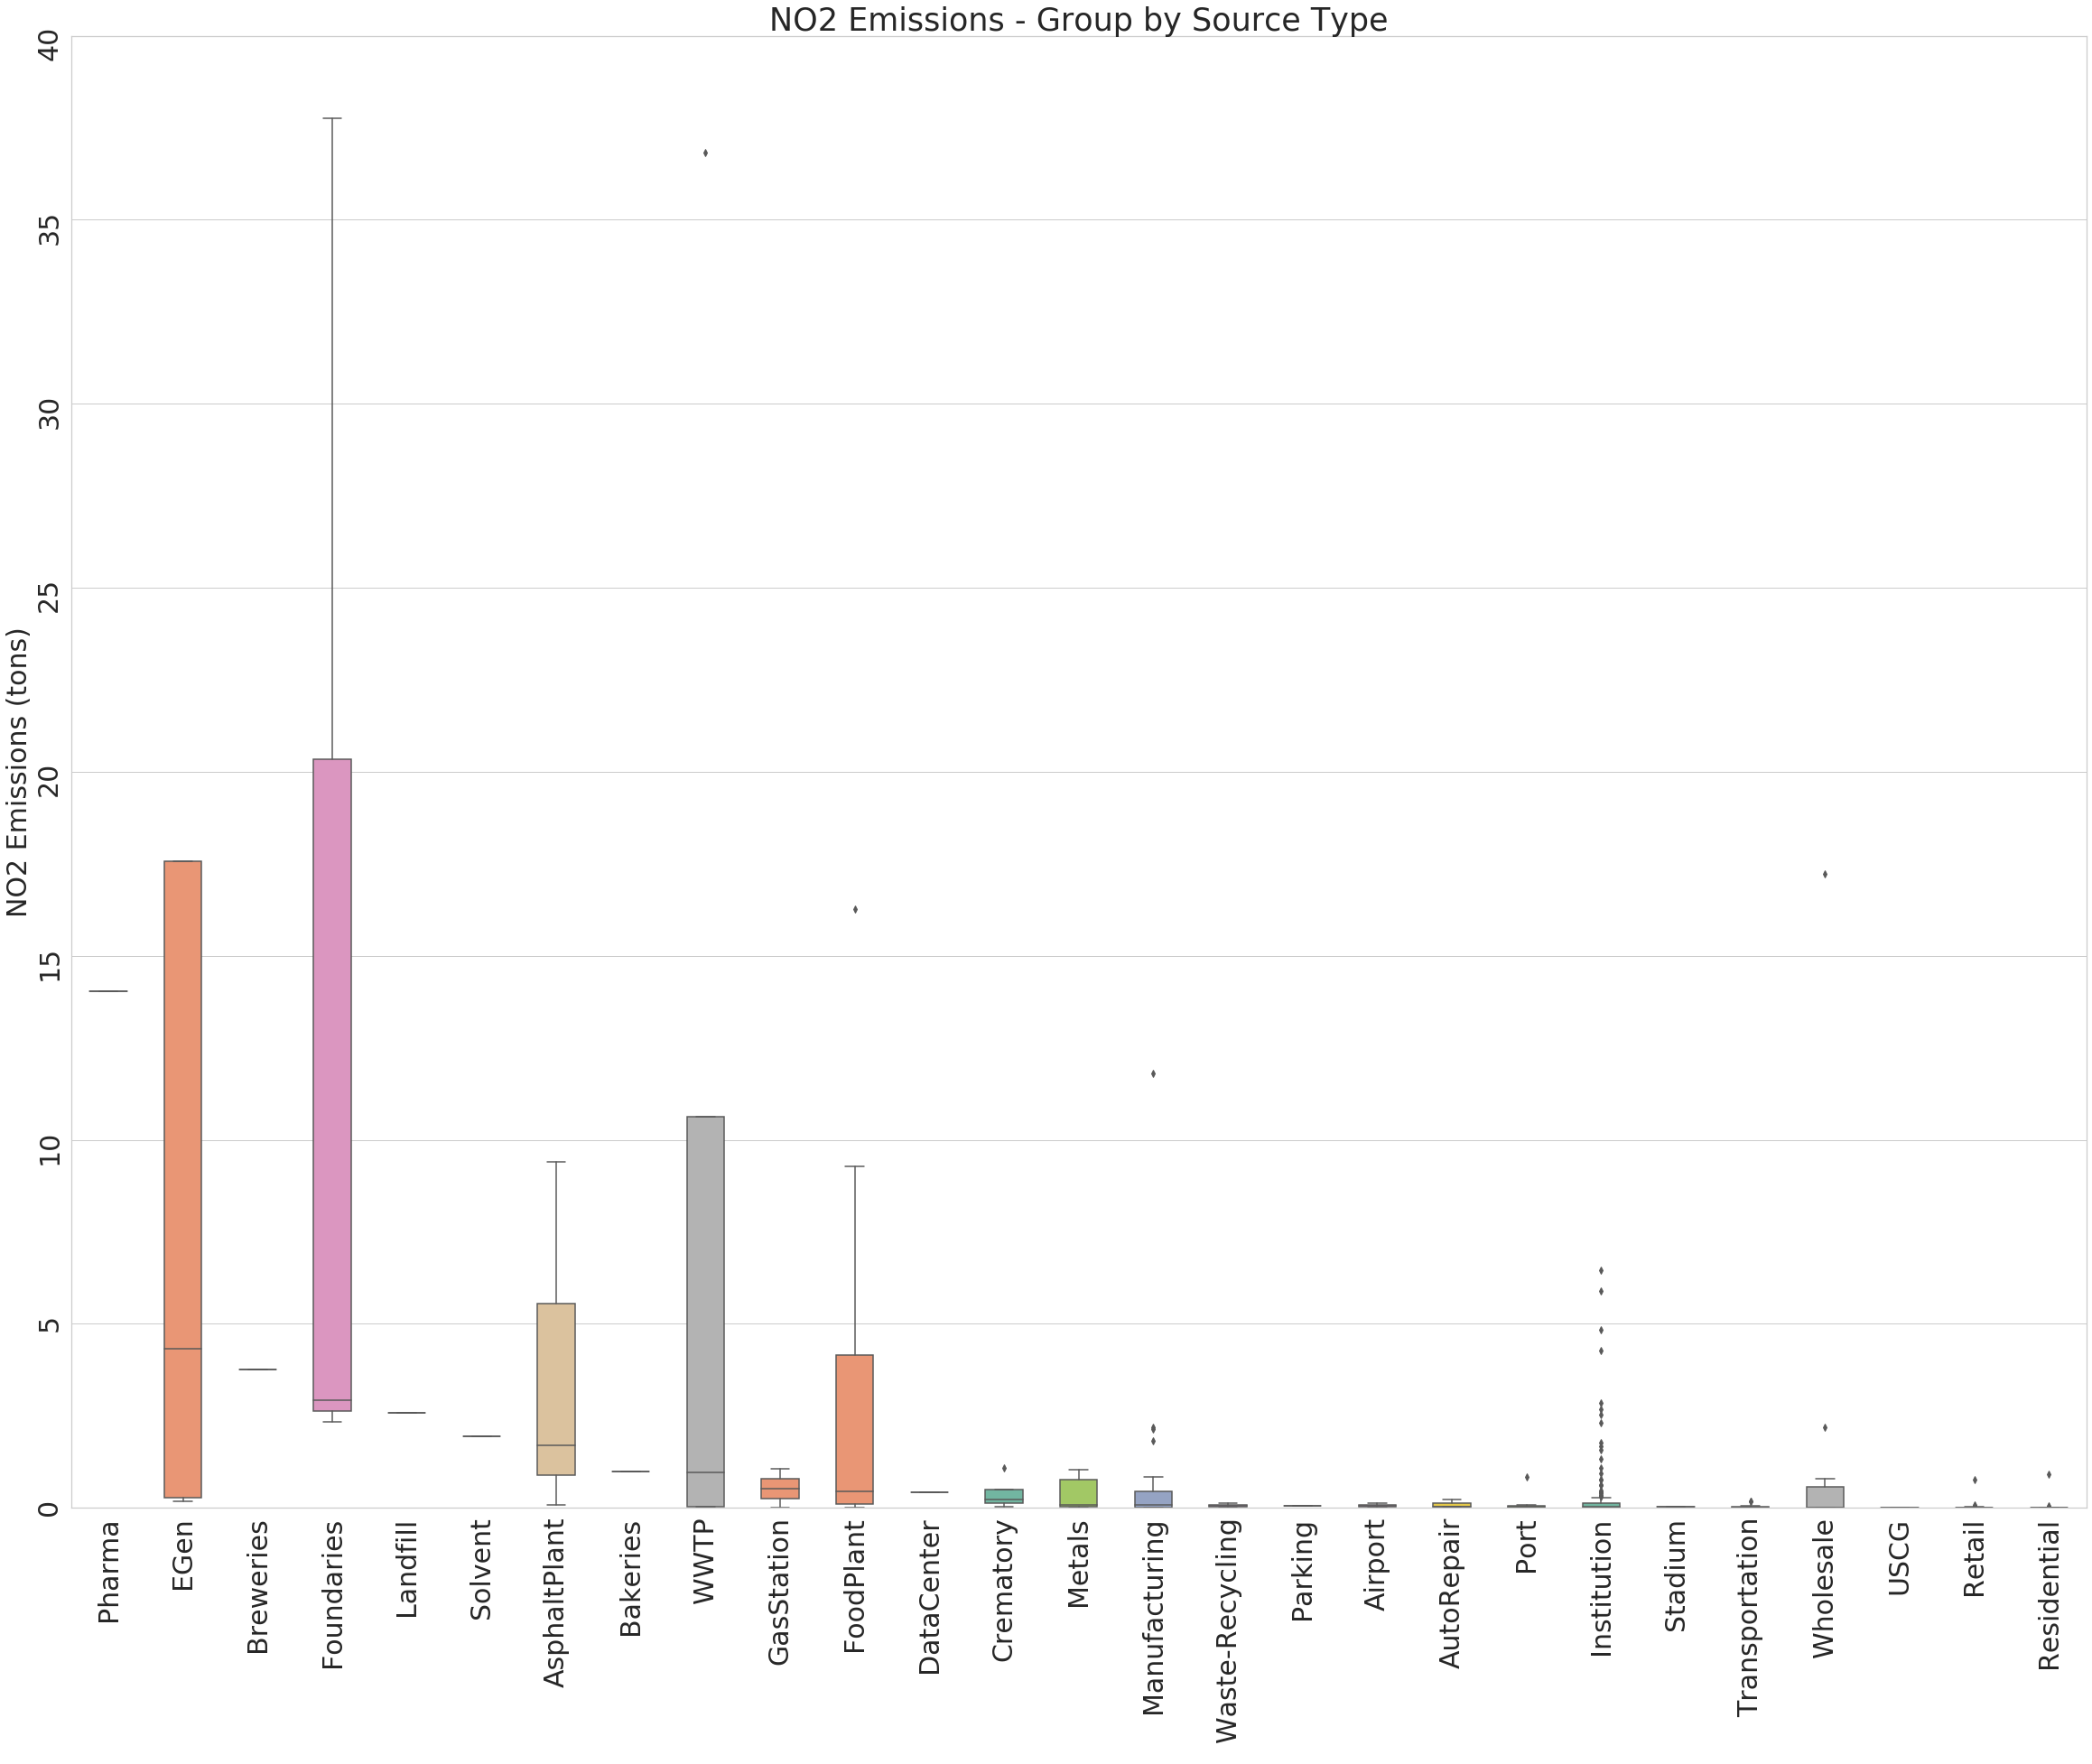

In [114]:
#### Box-plot of NO2 data by source type
sns.set(style = 'whitegrid')
sns.set_palette('bright')
fig, ax = plt.subplots(figsize=(40, 30))
sns.boxplot(x="source-type", hue="source-type", y="value", palette="Set2" ,data=Facility_NO2_long, width = 0.5, dodge = False,
           order =median_Facility_NO2.index.values)
#ax.set_xlabel('Source-Type', fontsize = 18, rotation = 4
ax.set_title('NO2 Emissions - Group by Source Type', fontsize = 35)
ax.tick_params(labelsize=30, rotation = 90)
ax.legend_.remove()
ax.set_ylim(0,40)
ax.set_ylabel('NO2 Emissions (tons)', fontsize = 30)
ax.set_xlabel(' ')


 -  From the above plot, we see that there are some very large sources of emissions (electricity generating units, asphalt plant, food plants, foundaries, and wholesale). All other sources of emissions are relatively small and can be combined into groups

#### <font color='red'> Combining Source Types to Reduce Number of Distinct Sources </font>


In [115]:
# The following sources can be combined into one single source group
# Transportation <--> Port, Airport, Transportation, Parking, USCG
# Manufacturing <--> Pharma, Manufacturing, FiberGlass, Metals, Solvent, PipePlant
# Eateries <--> Breweries, Bakeries
# Retail-Res <--> Wholesale, retail, Residential
# Waste <--> Waste Recycling, Landfill
# Misc <--> Stadium, DataCenter, GasStation, Crematory


In [116]:
# Transportation <--> Port, Airport, Transportation, Parking, USCG
Facility_NO2.loc[(Facility_NO2['source-type'] == 'Port') | (Facility_NO2['source-type'] == 'Airport')|
                (Facility_NO2['source-type'] == 'Parking') | (Facility_NO2['source-type'] == 'USCG'),'source-type']='Transportation'


In [117]:
# Manufacturing <--> Pharma, Manufacturing, FiberGlass, Metals, Solvent, PipePlant
Facility_NO2.loc[(Facility_NO2['source-type'] == 'Pharma') | (Facility_NO2['source-type'] == 'Metals')| 
                (Facility_NO2['source-type'] == 'Solvent'),'source-type']='Manufacturing'


In [118]:
# Eateries <--> Breweries, Bakeries
Facility_NO2.loc[(Facility_NO2['source-type'] == 'Bakeries') | 
                (Facility_NO2['source-type'] == 'Breweries') ,'source-type']='Eateries'

In [119]:
# Retail-Res <--> Wholesale, retail, Residential, Institution
Facility_NO2.loc[(Facility_NO2['source-type'] == 'Residential') | (Facility_NO2['source-type'] == 'Retail') | 
                (Facility_NO2['source-type'] == 'Wholesale') | (Facility_NO2['source-type'] == 'Institution') ,'source-type']='Retail-Res'

In [120]:
# Waste <--> Waste Recycling, Landfill
Facility_NO2.loc[(Facility_NO2['source-type'] == 'Waste-Recycling') | 
                (Facility_NO2['source-type'] == 'Landfill') ,'source-type']='Waste'

In [121]:
# Misc <--> Stadium, DataCenter, GasStation, Crematory
Facility_NO2.loc[(Facility_NO2['source-type'] == 'Stadium') | (Facility_NO2['source-type'] == 'DataCenter') | 
                (Facility_NO2['source-type'] == 'Crematory') | (Facility_NO2['source-type'] == 'GasStation') ,'source-type']='Misc'


#### <font color='red'> Boxplot of NO2 Emissions with Combined Source Groups </font>


In [122]:
Facility_NO2_long = pd.melt(Facility_NO2, id_vars='source-type', value_vars = 'NO2')

In [123]:
Facility_NO2_long.head()

source-type variable     value
0  Retail-Res      NO2  0.054659
1  Retail-Res      NO2  0.162383
2  Retail-Res      NO2  0.619550
3  Retail-Res      NO2  0.052783
4  Retail-Res      NO2  0.116122

In [124]:
### Before creating box-plot, sort the index by descending order
median_Facility_NO2 = Facility_NO2_long.groupby('source-type').median()
median_Facility_NO2.sort_values(by = 'value', ascending=False, inplace=True)
median_Facility_NO2.index.values

array(['EGen', 'Foundaries', 'Eateries', 'AsphaltPlant', 'WWTP',
       'FoodPlant', 'Misc', 'Waste', 'Manufacturing', 'AutoRepair',
       'Transportation', 'Retail-Res'], dtype=object)

Text(0.5, 0, ' ')

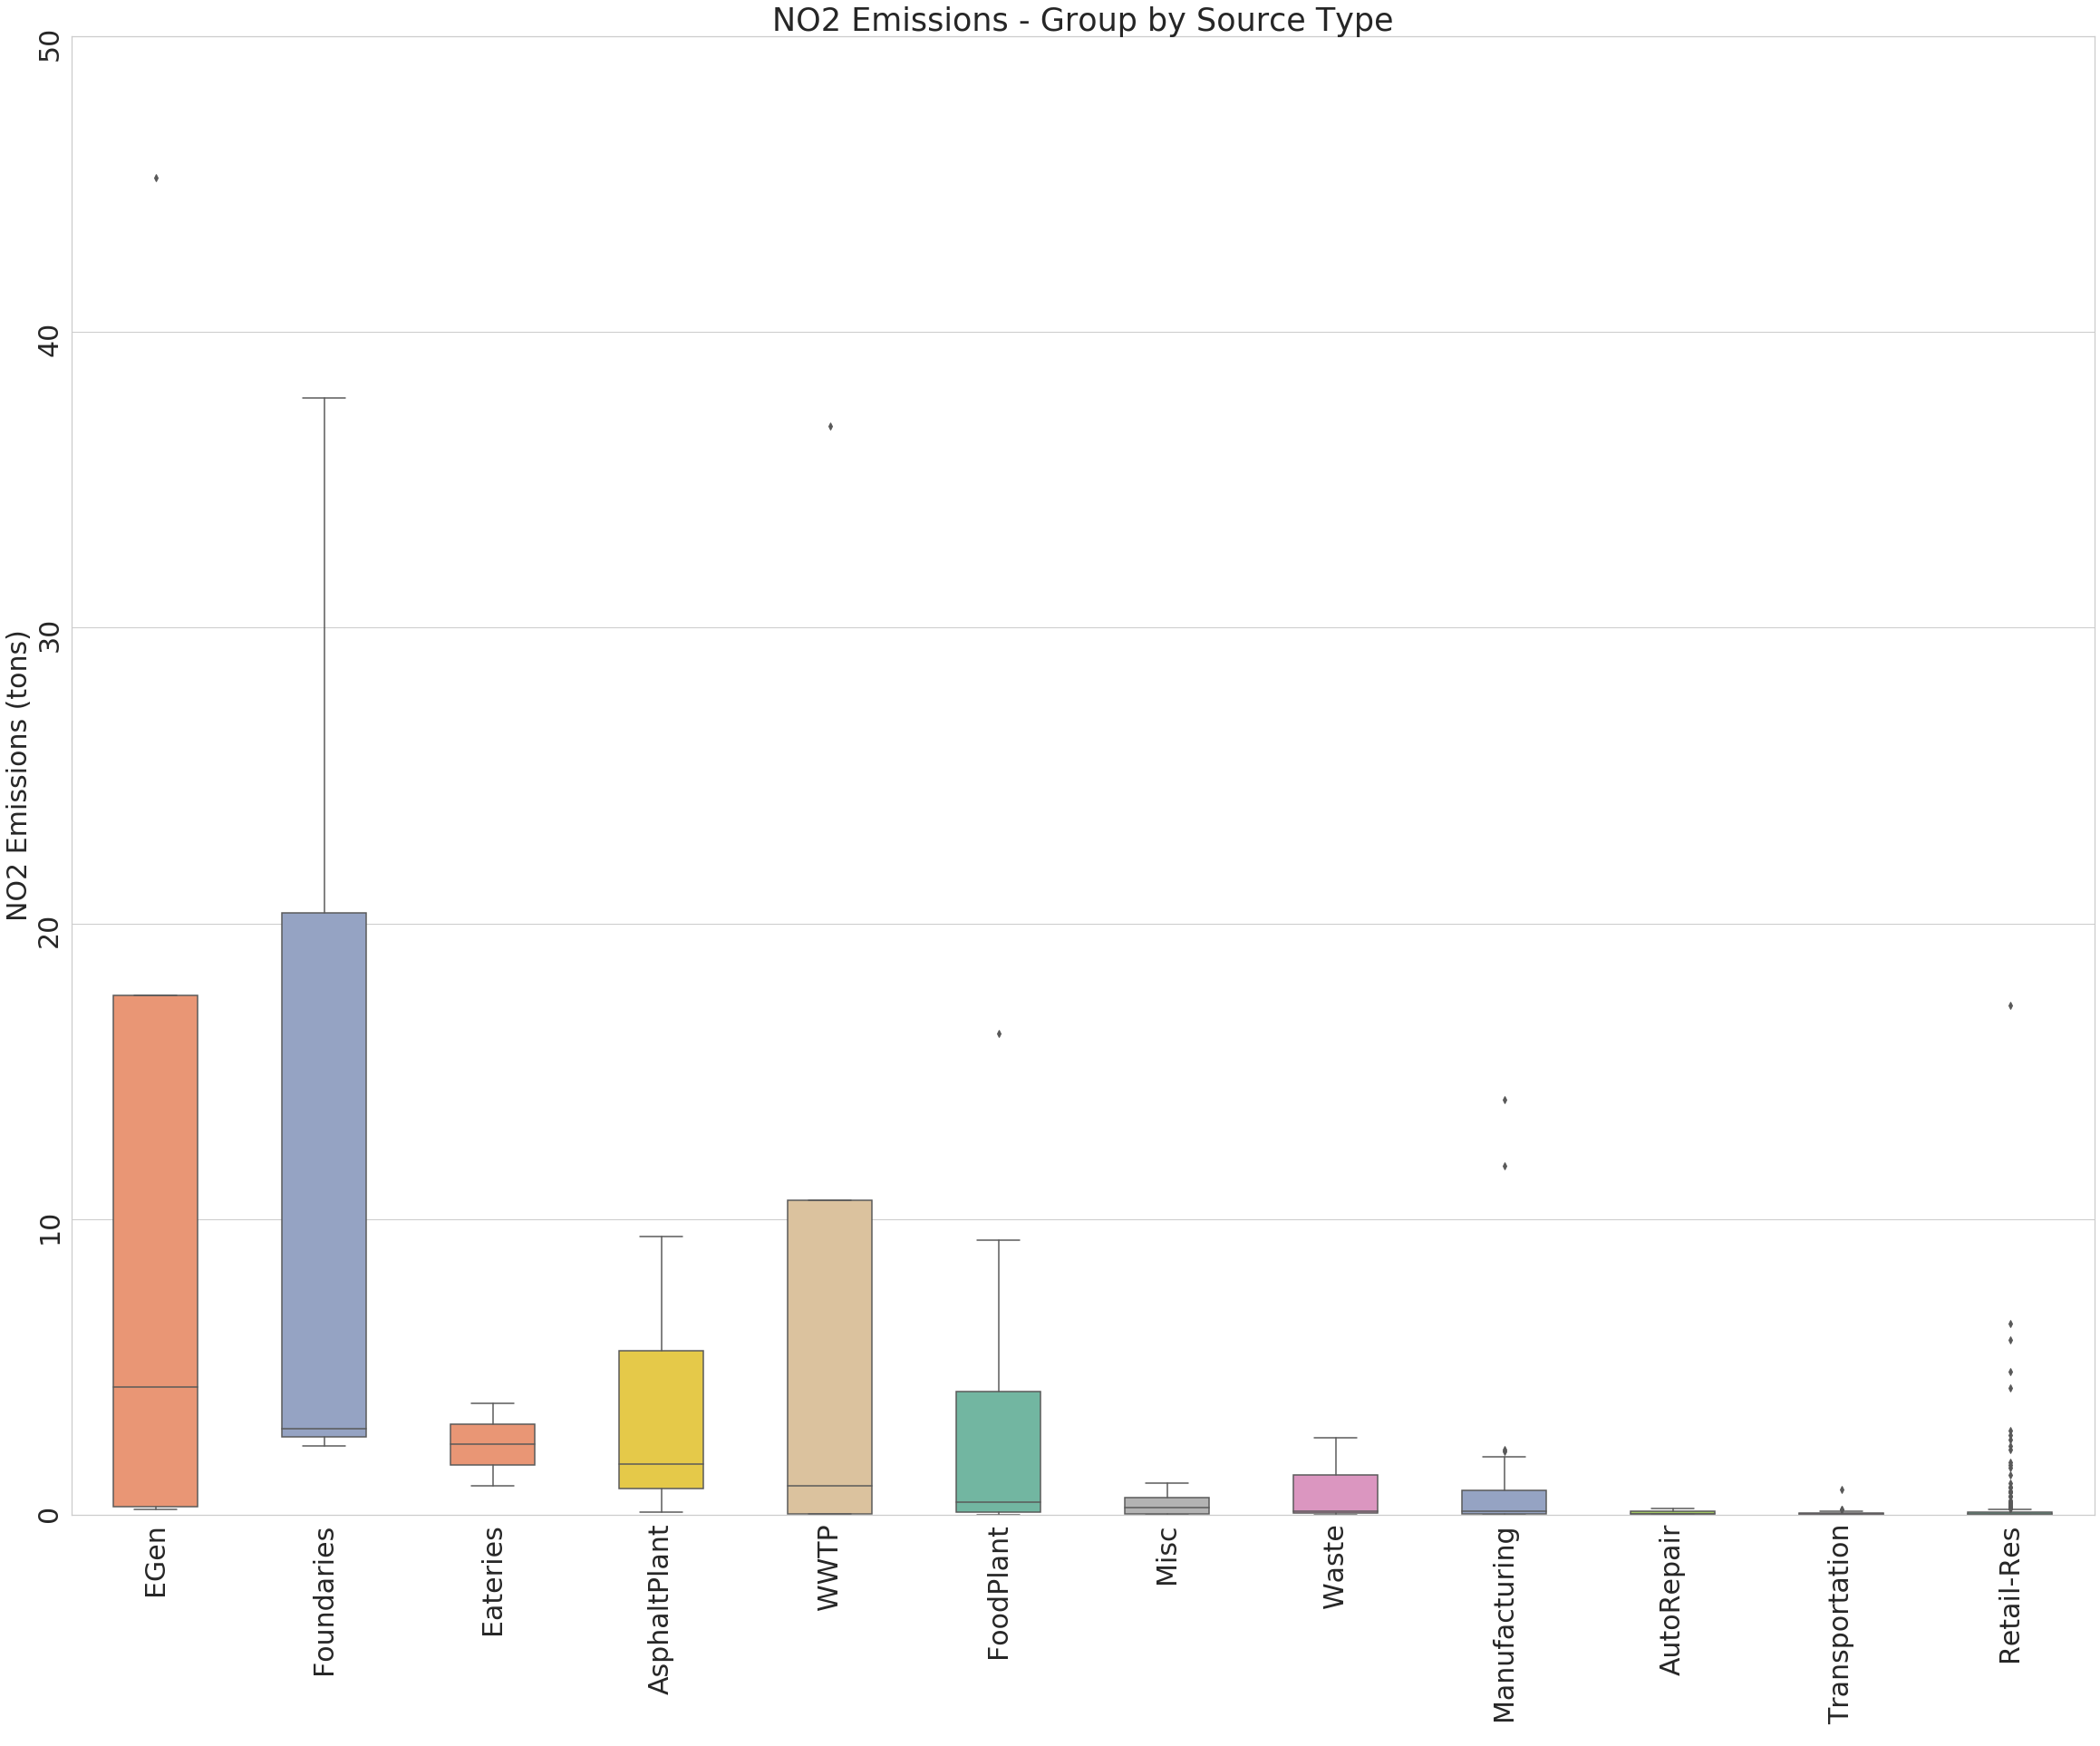

In [125]:
#### Box-plot of NO2 data by source type

fig, ax = plt.subplots(figsize=(40, 30))
sns.boxplot(x="source-type", hue="source-type", y="value", palette="Set2" ,data=Facility_NO2_long, width = 0.5, dodge = False,
           order =median_Facility_NO2.index.values)
#ax.set_xlabel('Source-Type', fontsize = 18, rotation = 4
ax.set_title('NO2 Emissions - Group by Source Type', fontsize = 35)
ax.tick_params(labelsize=30, rotation = 90)
ax.legend_.remove()
ax.set_ylim(0,50)
ax.set_ylabel('NO2 Emissions (tons)', fontsize = 30)
ax.set_xlabel(' ')


#### Next, categorize each facility as 'Small/Medium/Large' depending on the quantity of emissions. Facilities are classified based on the following categories:
    #### Emissions Lower than first quartile - Low
    #### Emissions Between first and 3rd quartile - Medium
    #### Emissions Above 3rd quartile - High

In [126]:
Facility_NO2.groupby('source-type').describe()['NO2'].sort_values('count')

count       mean        std       min       25%       50%  \
source-type                                                                 
Eateries          2.0   2.378789   1.971472  0.984748  1.681768  2.378789   
AsphaltPlant      3.0   3.728380   4.977064  0.082914  0.893208  1.703503   
AutoRepair        3.0   0.094665   0.109193  0.022717  0.031842  0.040967   
Foundaries        3.0  14.344039  20.288321  2.340315  2.631780  2.923244   
Waste             3.0   0.904388   1.458280  0.002815  0.063171  0.123527   
EGen              4.0  13.508670  21.479312  0.182181  0.269487  4.319000   
WWTP              4.0   9.691156  18.104890  0.021549  0.025621  0.963497   
Misc              8.0   0.385593   0.443128  0.000015  0.035418  0.235127   
FoodPlant        11.0   3.209890   5.266220  0.001549  0.095315  0.439633   
Transportation   26.0   0.069611   0.165525  0.000059  0.005728  0.019461   
Manufacturing    34.0   1.181012   3.064852  0.000270  0.012627  0.107076   
Retail-Res      216.0   0.594180   3.927850  0.000001  0.003711  0.012836   

                      75%        max  
source-type                           
Eateries         3.075810   3.772830  
AsphaltPlant     5.551113   9.398723  
AutoRepair       0.130639   0.220310  
Foundaries      20.345901  37.768557  
Waste            1.355175   2.586823  
EGen            17.558183  45.214501  
WWTP            10.629033  36.816083  
Misc             0.581989   1.075531  
FoodPlant        4.150409  16.273238  
Transportation   0.052352   0.846742  
Manufacturing    0.811003  14.049045  
Retail-Res       0.077945  54.110091

In [127]:
Facility_NO2.loc[:,'ems-type'] = pd.qcut(Facility_NO2['NO2'], q = [0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

### Eateries
Eateries = Facility_NO2[Facility_NO2['source-type'] == 'Eateries']
Eateries.loc[:,'ems-type'] = pd.qcut(Eateries['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

### AsphaltPlant
AsphaltPlant = Facility_NO2[Facility_NO2['source-type'] == 'AsphaltPlant']
AsphaltPlant.loc[:,'ems-type'] = pd.qcut(AsphaltPlant['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

### EGen
EGen = Facility_NO2[Facility_NO2['source-type'] == 'EGen']
EGen.loc[:,'ems-type'] = pd.qcut(EGen['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

### Foundaries
Foundaries = Facility_NO2[Facility_NO2['source-type'] == 'Foundaries']
Foundaries.loc[:,'ems-type'] = pd.qcut(Foundaries['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])

### WWTP
WWTP = Facility_NO2[Facility_NO2['source-type'] == 'WWTP']
WWTP.loc[:,'ems-type'] = pd.qcut(WWTP['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])



### AutoRepair
AutoRepair = Facility_NO2[Facility_NO2['source-type'] == 'AutoRepair']
AutoRepair.loc[:,'ems-type'] = pd.qcut(AutoRepair['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Waste
Waste = Facility_NO2[Facility_NO2['source-type'] == 'Waste']
Waste.loc[:,'ems-type'] = pd.qcut(Waste['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])



### Misc
Misc = Facility_NO2[Facility_NO2['source-type'] == 'Misc']
Misc.loc[:,'ems-type'] = pd.qcut(Misc['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### FoodPlant
FoodPlant = Facility_NO2[Facility_NO2['source-type'] == 'FoodPlant']
FoodPlant.loc[:,'ems-type'] = pd.qcut(FoodPlant['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Transportation
Transportation = Facility_NO2[Facility_NO2['source-type'] == 'Transportation']
Transportation.loc[:,'ems-type'] = pd.qcut(Transportation['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Manufacturing
Manufacturing = Facility_NO2[Facility_NO2['source-type'] == 'Manufacturing']
Manufacturing.loc[:,'ems-type'] = pd.qcut(Manufacturing['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])


### Retail - Residential Category
RetailRes = Facility_NO2[Facility_NO2['source-type'] == 'Retail-Res']
RetailRes.loc[:,'ems-type'] = pd.qcut(RetailRes['NO2'], q=[0, 0.25, 0.75, 1.0], labels=["low", "medium", "high"])




#### Combine all the dataframes back into one frame
Facility_NO2 = AsphaltPlant.append(AutoRepair).append(Eateries).append(EGen).append(FoodPlant).append(Foundaries).append(Manufacturing).append(Misc).append(RetailRes).append(Transportation).append(Waste).append(WWTP)

In [128]:
Facility_NO2.head(20)

eis facility id                    company name  \
0            126911                    PACIFIC-BELL   
1            127111                    PACIFIC-BELL   
2            127511                    PACIFIC-BELL   
3            127611                    PACIFIC-BELL   
4            127711                    PACIFIC-BELL   
5            127811                    PACIFIC-BELL   
6            128211                    PACIFIC-BELL   
7            130511               KAISER-PERMANENTE   
8            136511     NORTHERN-CALIF-POWER-AGENCY   
9            137211  KAISER-PERMANENTE-MEDICAL-CENT   
10           139211   AGRICULTURAL-RESEARCH-SERVICE   
11           140211   SVC-MANUFACTURING-INC-DBA-PEP   
12           141411     AC-TRANSIT-DISTRICT-CENTRAL   
13           168111  EAST-BAY-DISCHARGERS-AUTHORITY   
14           168411                        CASS-INC   
15           172211                    PACIFIC-BELL   
16           192811       NOR-CAL-METAL-FABRICATORS   
17           193011     HAWKINS-HAWKINS-COMPANY-INC   
18           194911             AC-TRANSIT-DISTRICT   
19           195711       CONSOLIDATED-PRINTERS-INC   

                          source-category  latitude  longitude         city  \
0                             Institution  37.76685 -122.24972      ALAMEDA   
1                             Institution  37.86771 -122.26784     BERKELEY   
2                             Institution  37.80603 -122.26946      OAKLAND   
3                             Institution  37.78422 -122.22241      OAKLAND   
4                             Institution  37.83336 -122.26307      OAKLAND   
5                             Institution  37.81186 -122.19840      OAKLAND   
6                             Institution  37.70014 -122.12997  SAN-LEANDRO   
7                             Institution  37.76053 -122.21067      OAKLAND   
8   Electricity-Generation-via-Combustion  37.78683 -122.29108      ALAMEDA   
9                             Institution  37.82269 -122.25757      OAKLAND   
10                            Institution  37.87779 -122.31000     BERKELEY   
11                          Manufacturing  37.76033 -122.20570      OAKLAND   
12                            Institution  37.73715 -122.16575      OAKLAND   
13                            Institution  37.71410 -122.19243  SAN-LEANDRO   
14                        Waste-Recycling  37.81793 -122.28460      OAKLAND   
15                            Institution  37.75042 -122.17325      OAKLAND   
16                                 Metals  37.79954 -122.28784      OAKLAND   
17                                 Metals  37.87748 -122.30593     BERKELEY   
18                            Institution  37.75871 -122.20440      OAKLAND   
19      Auto-Body-Painting-or-Repair-Shop  37.85638 -122.29149     BERKELEY   

         NO2    source-type  NO2-transform ems-type  
0   0.054659     Retail-Res      -2.906636   medium  
1   0.162383     Retail-Res      -1.817800   medium  
2   0.619550     Retail-Res      -0.478762     high  
3   0.052783     Retail-Res      -2.941574   medium  
4   0.116122     Retail-Res      -2.153117   medium  
5   0.025101     Retail-Res      -3.684846   medium  
6   0.064512     Retail-Res      -2.740904   medium  
7   0.018783     Retail-Res      -3.974794   medium  
8   0.298589           EGen      -1.208688     high  
9   1.680661     Retail-Res       0.519187     high  
10  0.146057     Retail-Res      -1.923761   medium  
11  0.847034  Manufacturing      -0.166015     high  
12  0.032243     Retail-Res      -3.434457   medium  
13  0.020837     Retail-Res      -3.871038   medium  
14  0.123527          Waste      -2.091296   medium  
15  0.077180     Retail-Res      -2.561617   medium  
16  0.018697  Manufacturing      -3.979367   medium  
17  0.019085  Manufacturing      -3.958865   medium  
18  0.004000     Retail-Res      -5.521407      low  
19  0.220310     AutoRepair      -1.512722     high

### Write into a dataframe
Facility_NO2.to_csv("Data/NO2_Facility_Data.csv")

#### <font color='red'> Plot of number of sources classified as low, medium and high - Divided by Soruce Group </font>


In [130]:
NO2_count_df = Facility_NO2.groupby(['ems-type','source-type'])['eis facility id'].count()

In [131]:
NO2_count_df = NO2_count_df.reset_index()

In [132]:
NO2_count_df = NO2_count_df.pivot(index = 'ems-type', columns = 'source-type', values = 'eis facility id')

In [133]:
NO2_count_df.fillna(0)

source-type  AsphaltPlant  AutoRepair  EGen  Eateries  FoodPlant  Foundaries  \
ems-type                                                                       
low                   0.0         0.0   0.0       0.0        2.0         0.0   
medium                1.0         2.0   1.0       0.0        2.0         0.0   
high                  2.0         1.0   3.0       2.0        7.0         3.0   

source-type  Manufacturing  Misc  Retail-Res  Transportation  WWTP  Waste  
ems-type                                                                   
low                    6.0   1.0        64.0             6.0   0.0    1.0  
medium                13.0   3.0       114.0            19.0   2.0    1.0  
high                  15.0   4.0        38.0             1.0   2.0    1.0

Text(0.5, 0, 'Emissions Type')

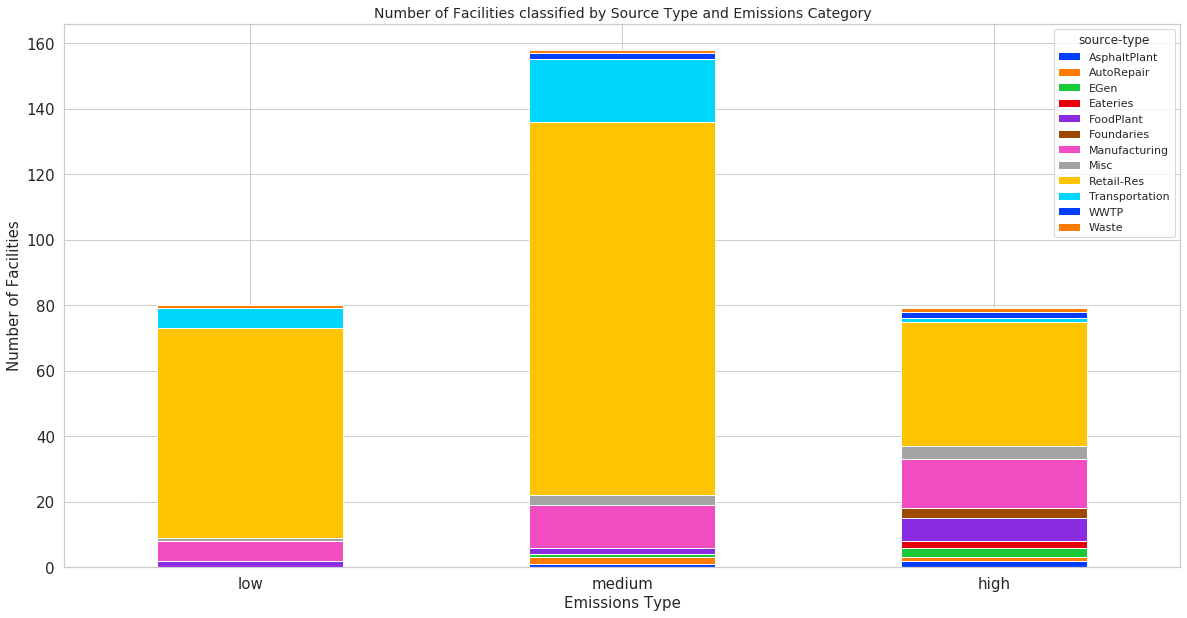

In [134]:
fig, ax = plt.subplots(figsize=(20, 10))
NO2_count_df.loc[:,['AsphaltPlant','AutoRepair', 'EGen', 'Eateries', 'FoodPlant', 'Foundaries',
                  'Manufacturing', 'Misc', 'Retail-Res', 'Transportation', 'WWTP', 'Waste']].plot.bar(stacked=True,  ax= ax)
ax.set_title('Number of Facilities classified by Source Type and Emissions Category', fontsize = 14)
ax.tick_params(labelsize=15, rotation = 0)
ax.set_ylabel('Number of Facilities', fontsize = 15)
ax.set_xlabel('Emissions Type', fontsize = 15)

### <font color='red'> Visualizing Facilities </font>

In [135]:
#### Load Basemap for Oakland
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [136]:
### Set the coordinate reference system
crs = {'init': 'epsg:4326'}

In [137]:
oakl.crs

{'init': 'epsg:4326'}

In [138]:
### Create a geopandas dataframe for NO2 data with coordinate reference system as epsg4326

# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility_NO2 = [Point(xy) for xy in zip(Facility_NO2['longitude'], Facility_NO2['latitude'])]

geo_df_facility_NO2 = gpd.GeoDataFrame(Facility_NO2, crs = crs, geometry = geometry_facility_NO2)

In [139]:
### Create a geopandas dataframe for PM data with coordinate reference system as epsg4326

# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility_PM = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]

geo_df_facility_PM = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility_PM)

### <font color='red'> Plotting NO2 source types on a map </font>

In [140]:
###### Can't figure out how to change the legend size!!

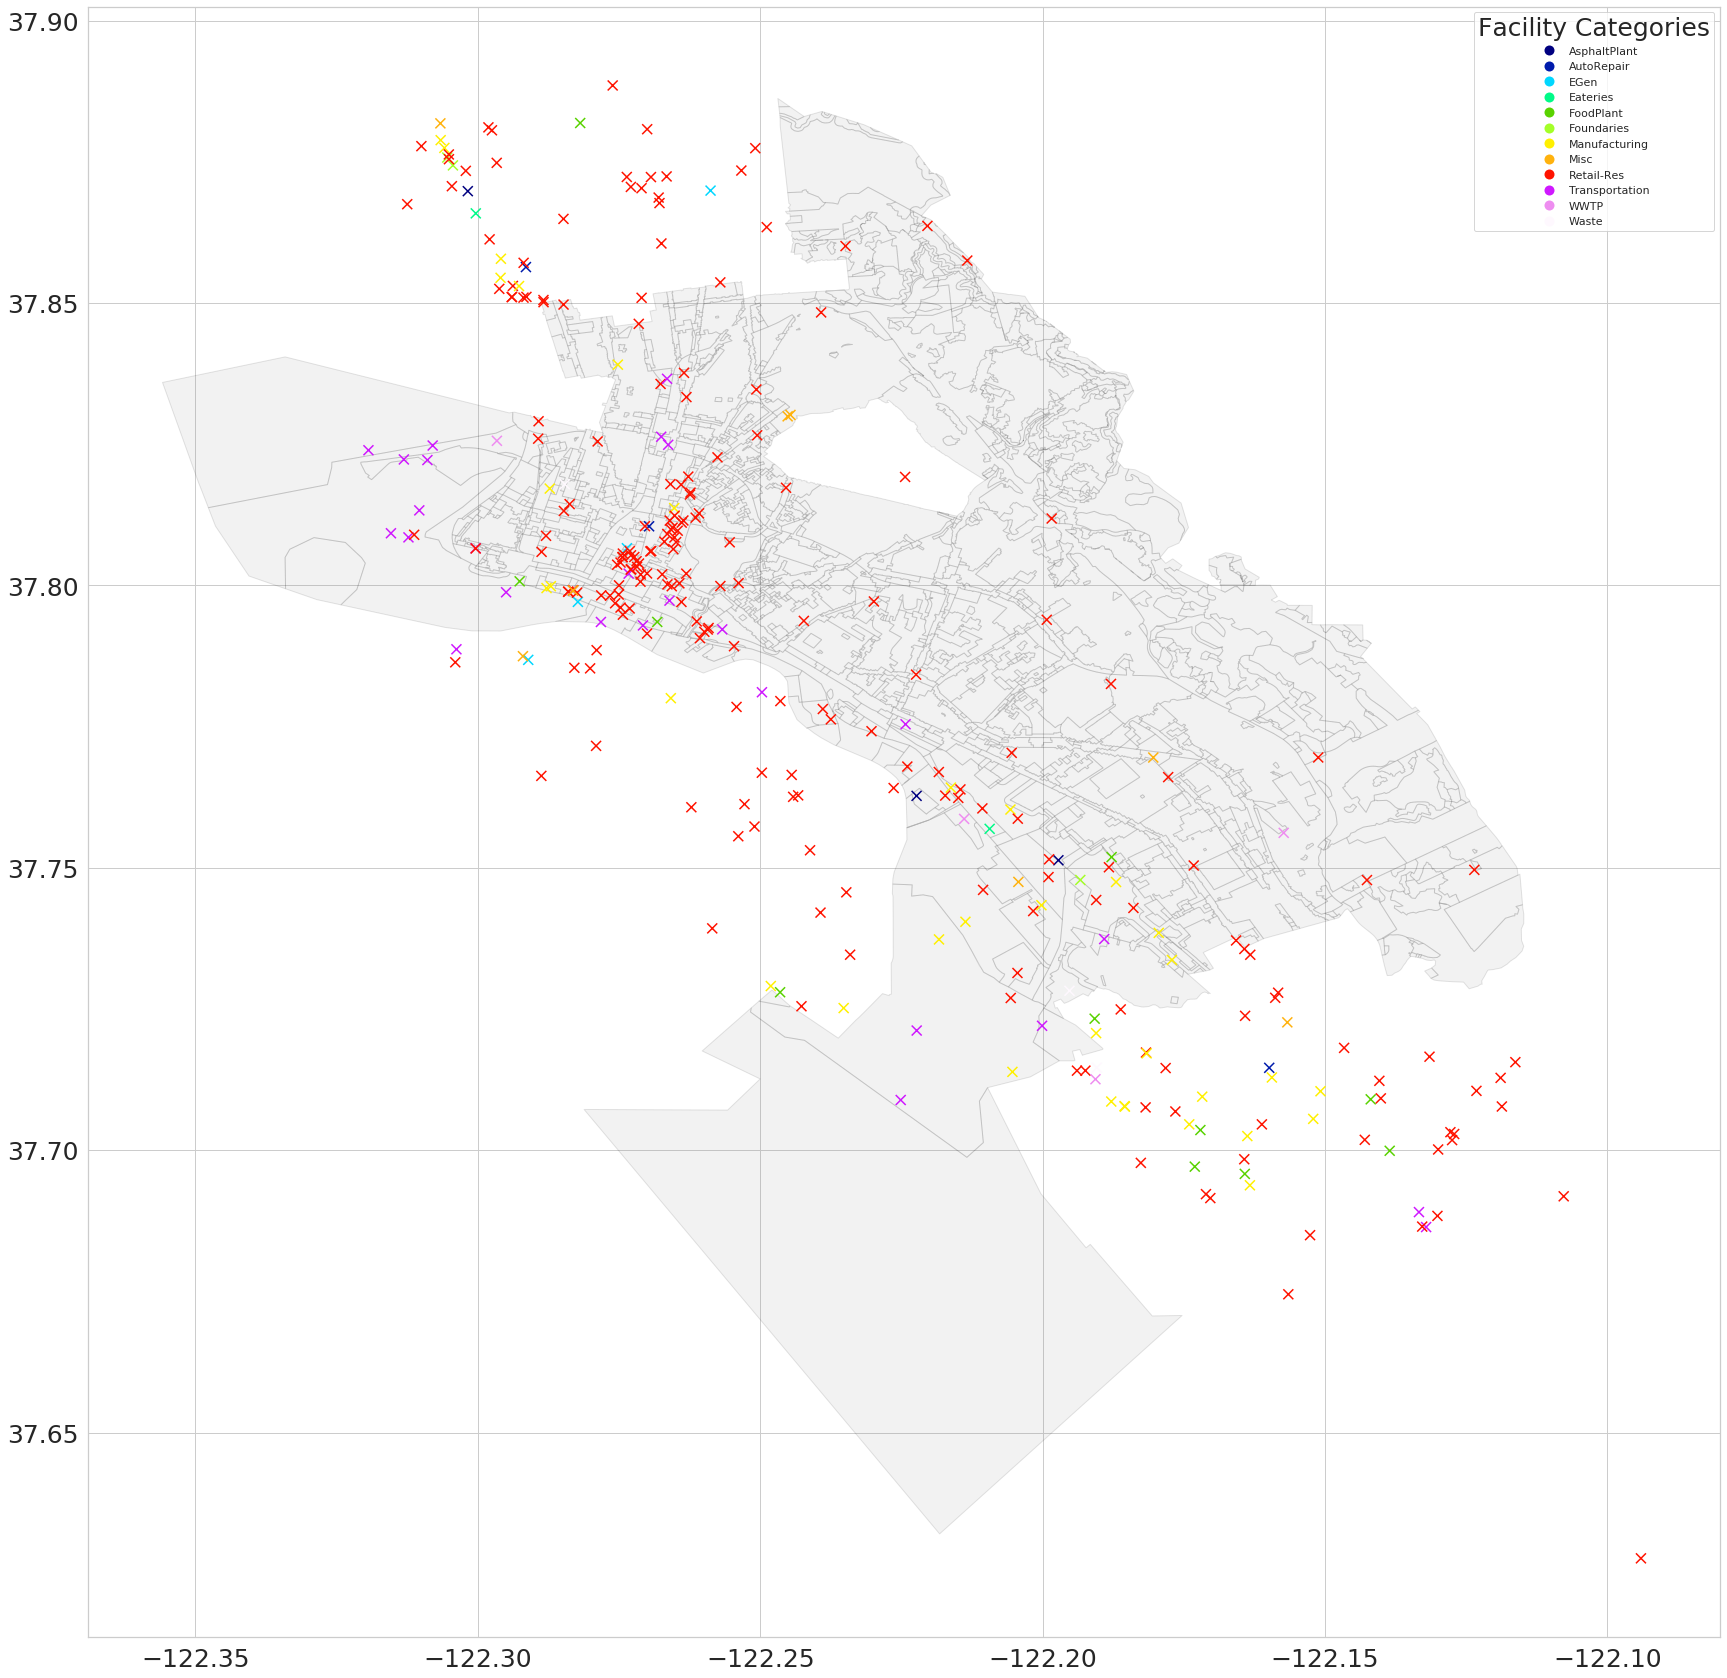

In [141]:
#### NO2 Plot - All Facilities


fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_NO2.plot(ax=ax, column = 'source-type', legend = True, markersize =100, marker = 'x', cmap = 'gist_ncar')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':25})
ax.tick_params(labelsize=25) 

plt.show()

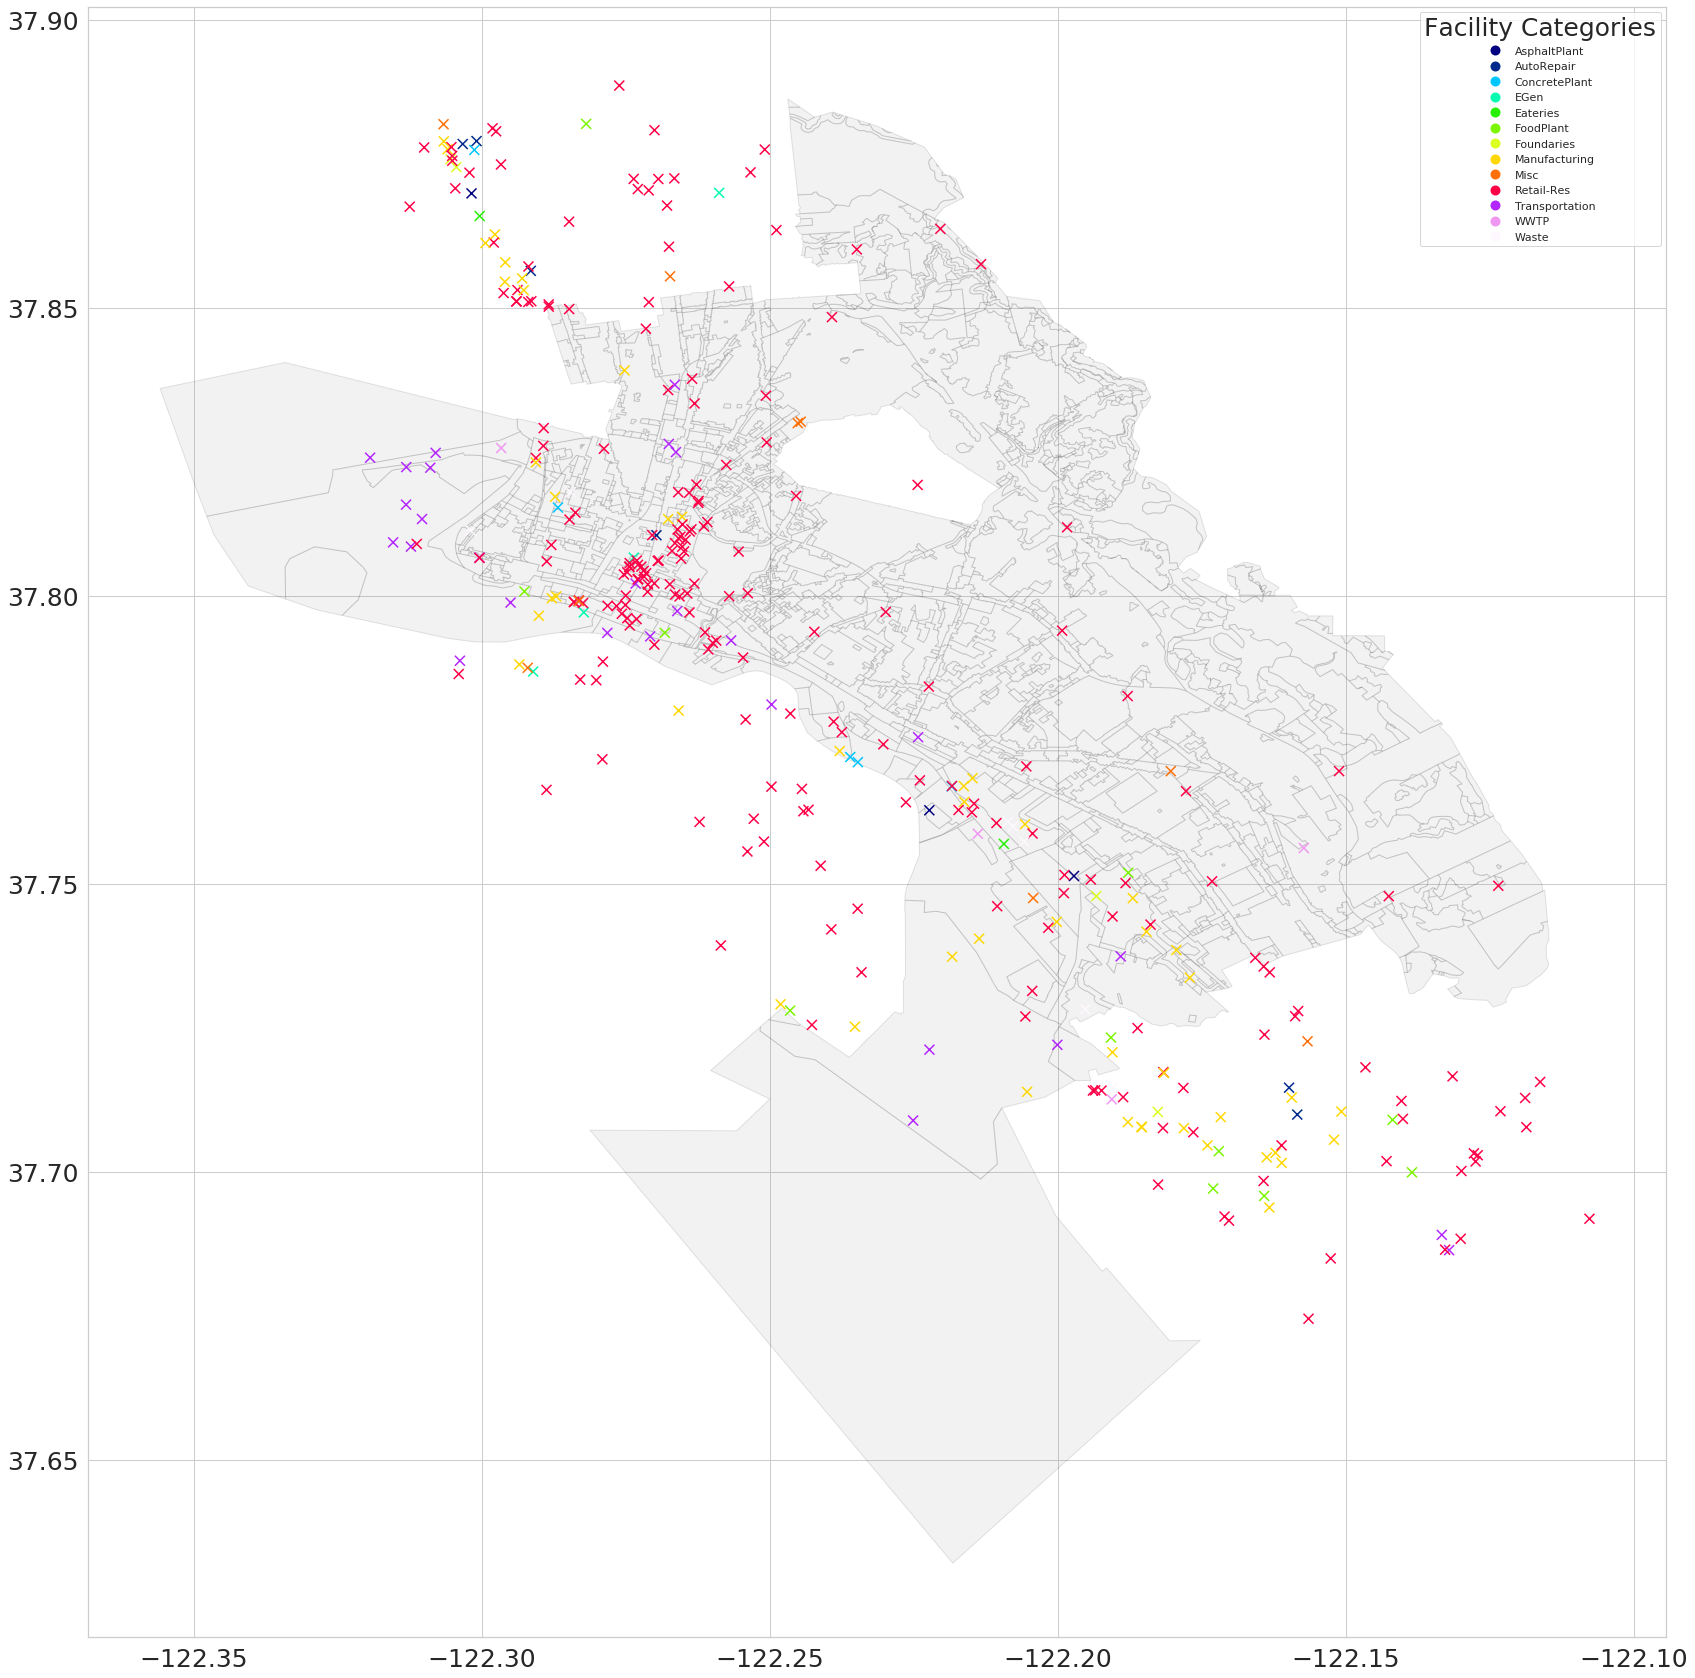

In [142]:
#### PM Plot - All Facilities


fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_PM.plot(ax=ax, column = 'source-type', legend = True, markersize =100, marker = 'x', cmap = 'gist_ncar')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':25})
ax.tick_params(labelsize=25) 
plt.show()

 -  Based on the above plot, there are several facilities that are of a similar source type located very close to each other. All these facilities can be combined into one source group in order to avoid highly correlated data

###  <font color='red'> Plot only points that are classified as high </font>

In [143]:
Facility_PM_med_high = Facility_PM[Facility_PM['ems-type'] == 'high']

In [144]:
Facility_NO2_med_high = Facility_NO2[Facility_NO2['ems-type'] == 'high']

In [145]:
Facility_NO2_med_high.shape

(79, 11)

In [146]:
### Creating a geodataframe for NO2 

# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility_NO2_h_m = [Point(xy) for xy in zip(Facility_NO2_med_high['longitude'], Facility_NO2_med_high['latitude'])]

geo_df_facility_NO2_h_m = gpd.GeoDataFrame(Facility_NO2_med_high, crs = crs, geometry = geometry_facility_NO2_h_m)

In [147]:
### Creating a geodataframe for PM 

# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility_PM_h_m = [Point(xy) for xy in zip(Facility_PM_med_high['longitude'], Facility_PM_med_high['latitude'])]

geo_df_facility_PM_h_m = gpd.GeoDataFrame(Facility_PM_med_high, crs = crs, geometry = geometry_facility_PM_h_m)

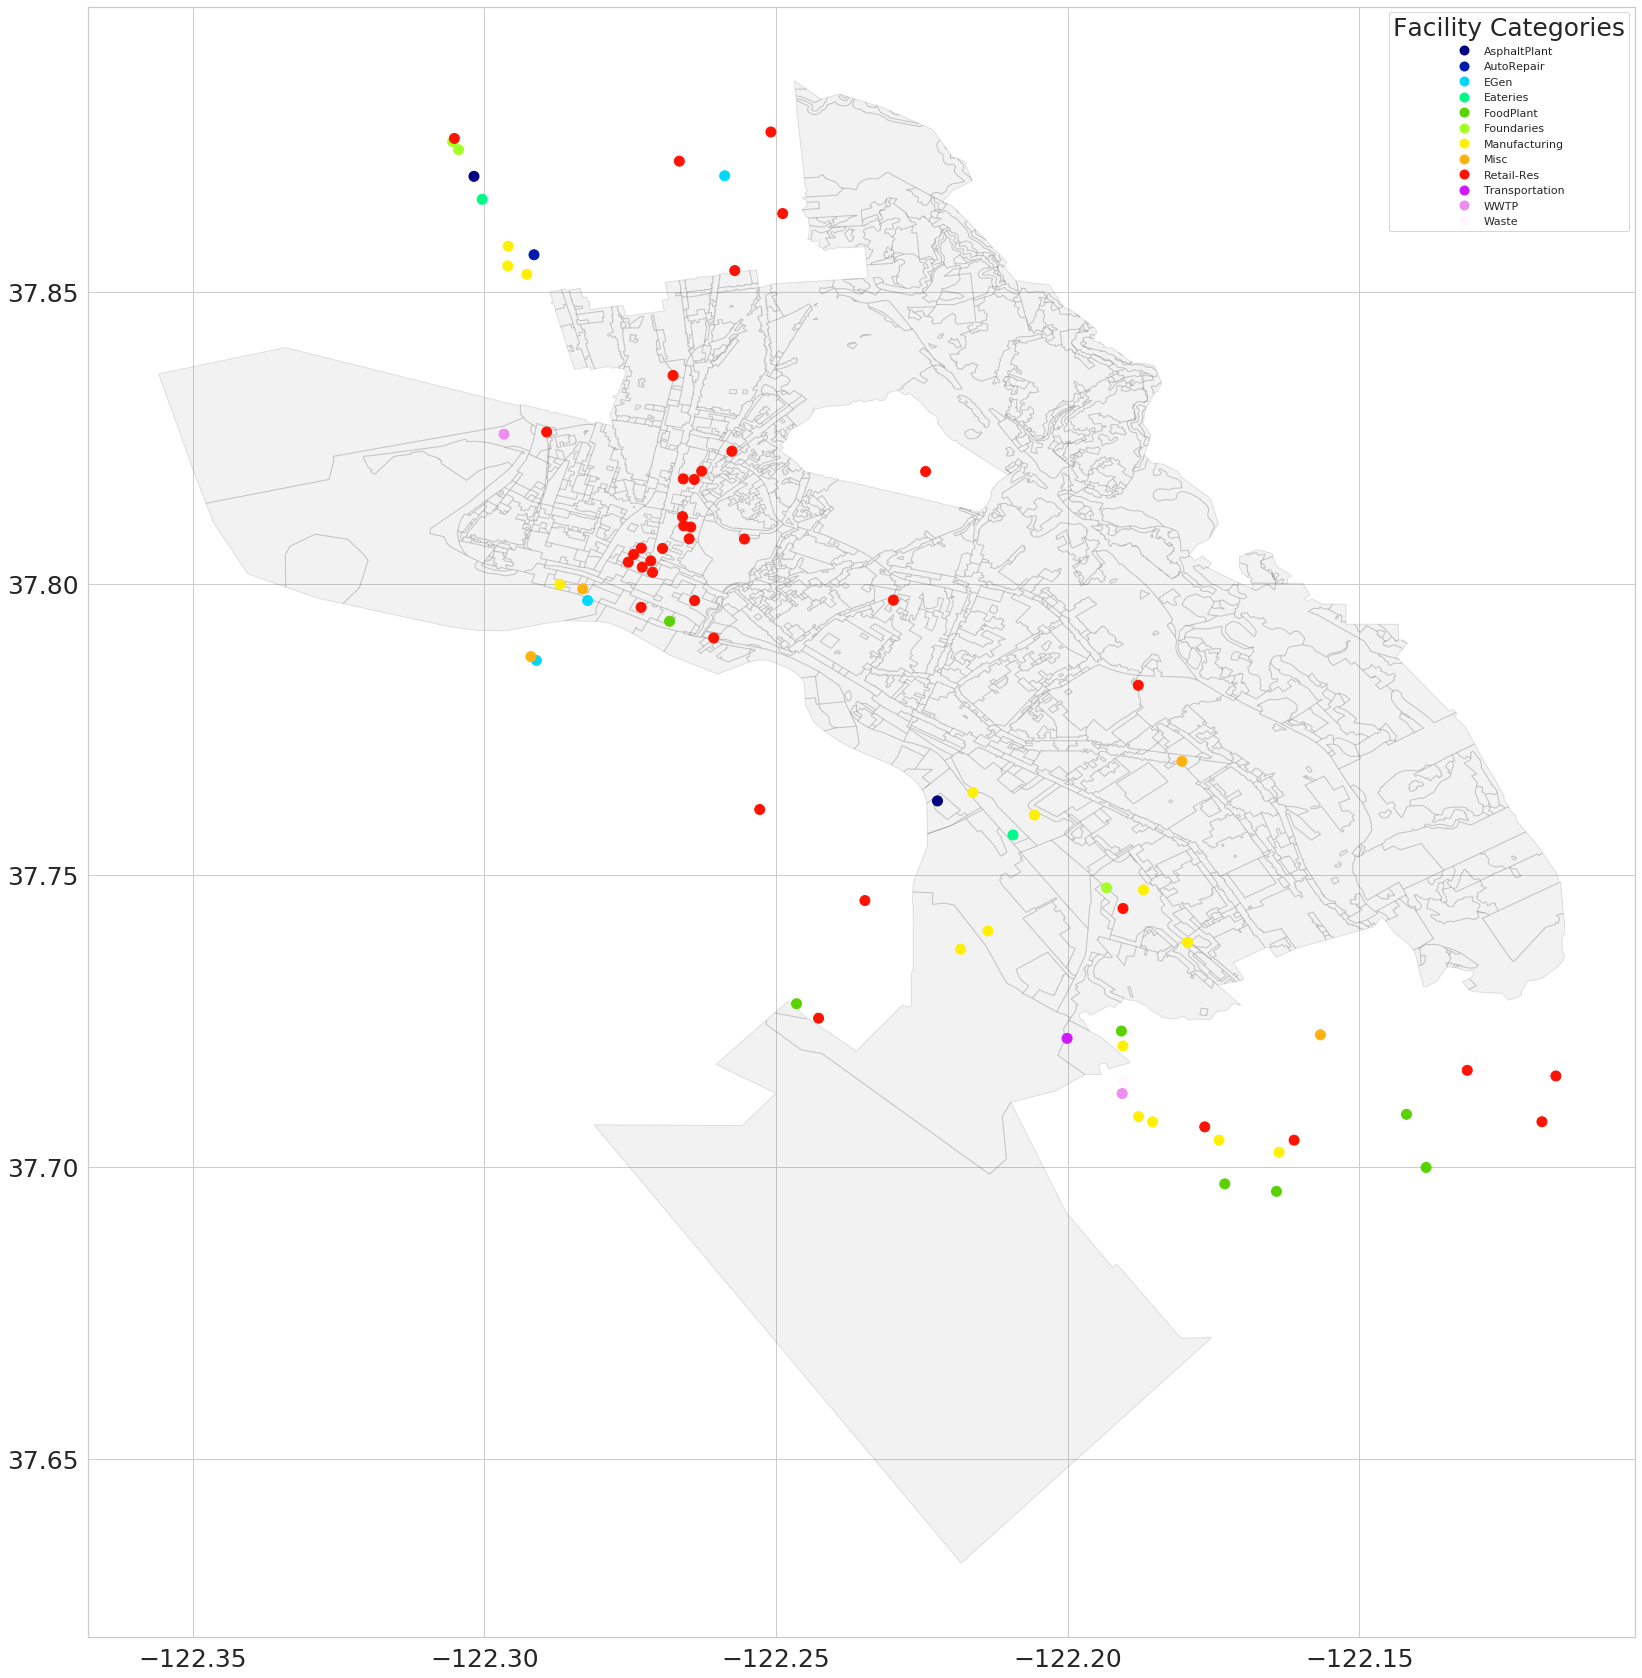

In [148]:
#### NO2 Plot - Facilities classified as high


fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_NO2_h_m.plot(ax=ax, column = 'source-type', legend = True, markersize =100, marker = 'o', cmap = 'gist_ncar')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':25})
ax.tick_params(labelsize=25) 

plt.show()

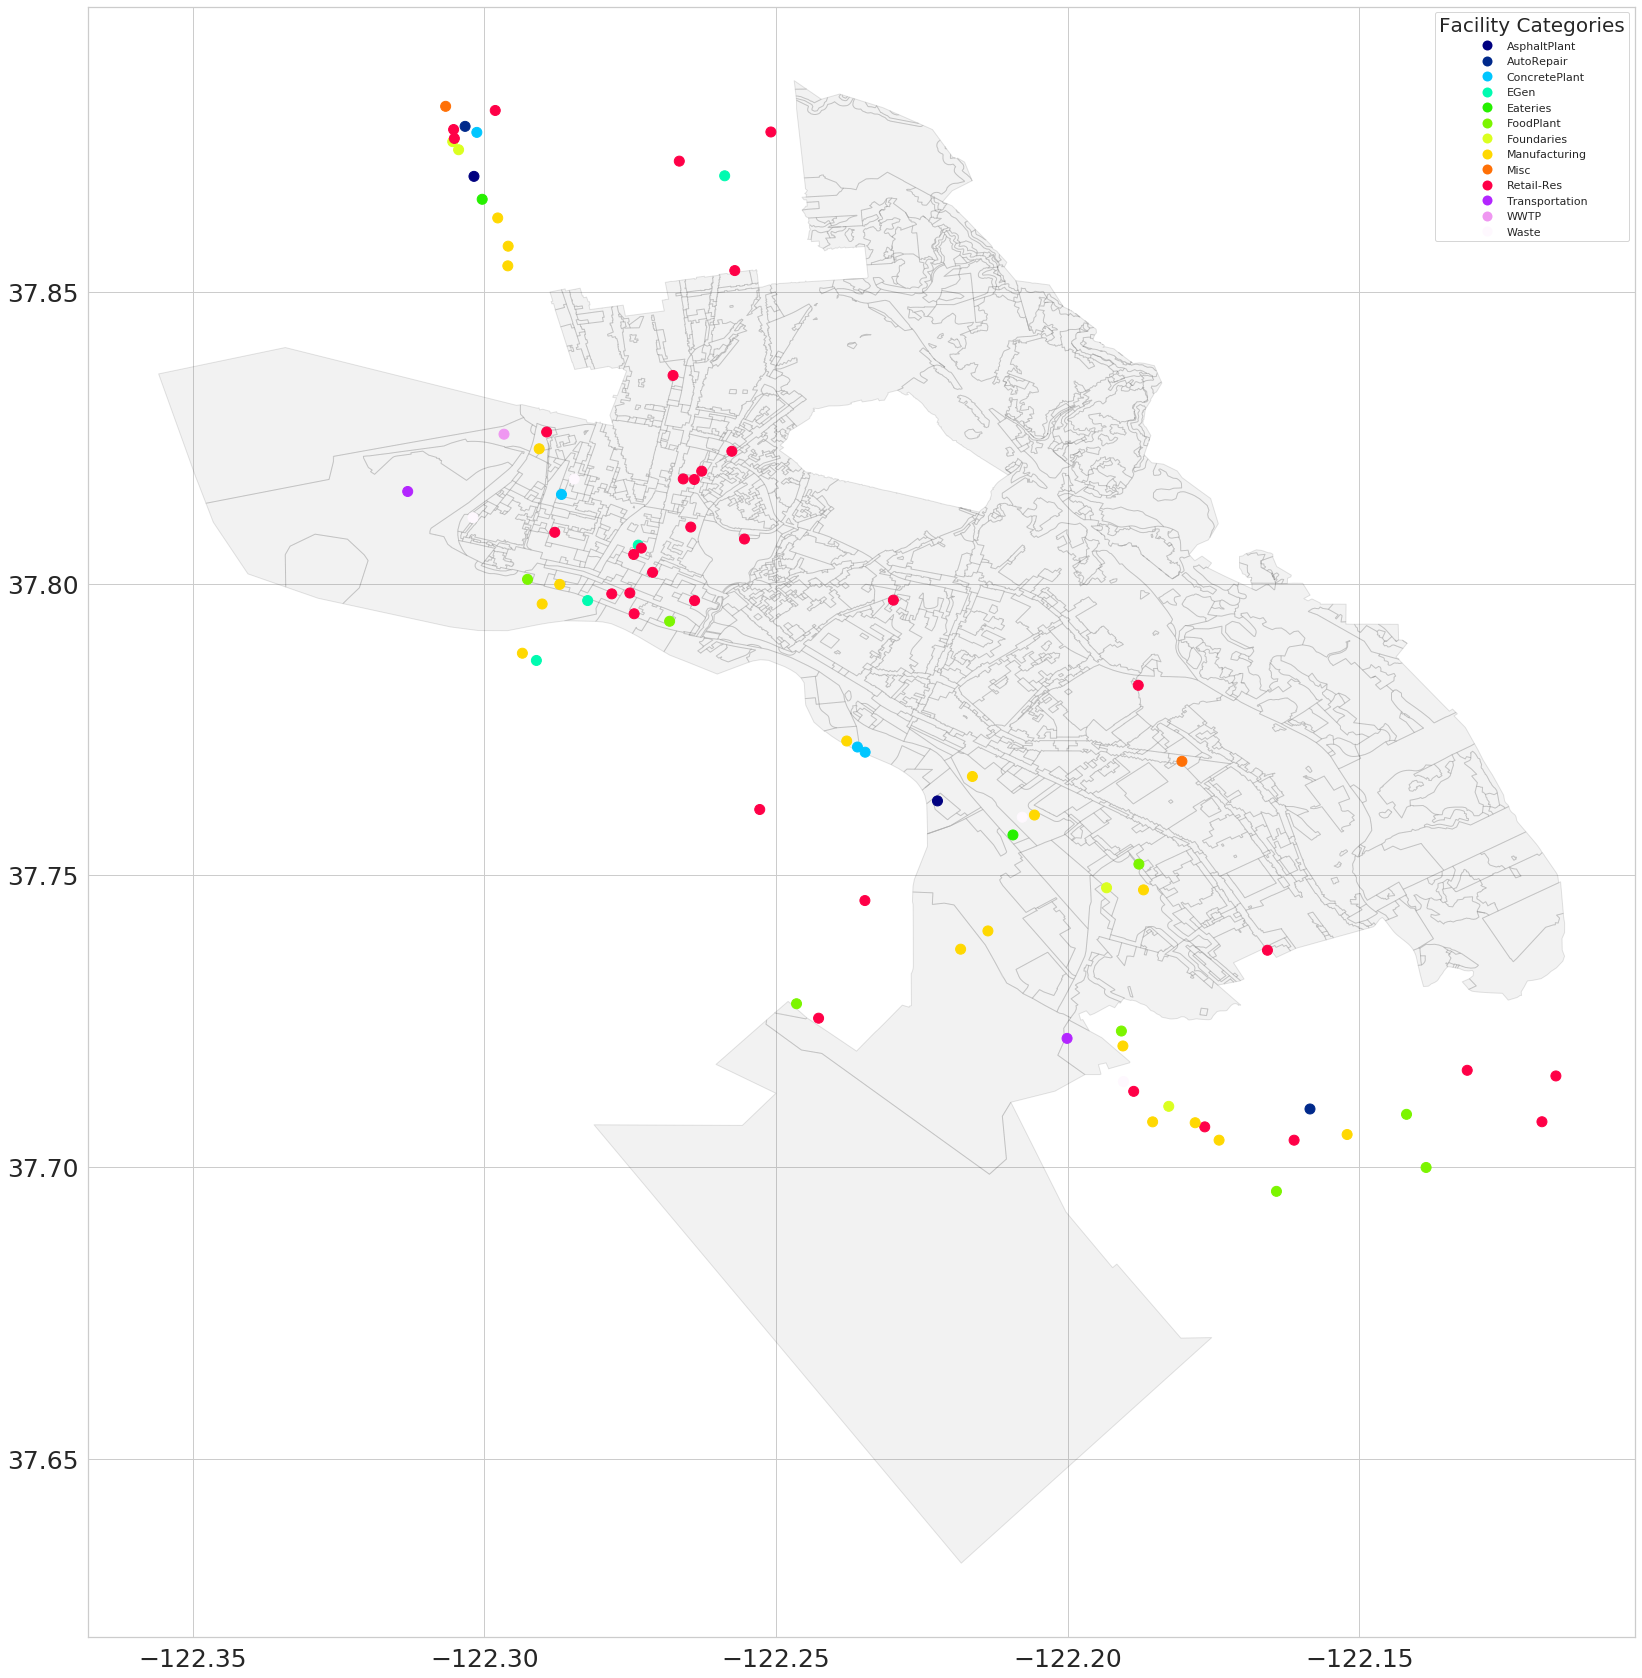

In [149]:
#### PM Plot - Facilities classified as high

fig, ax = plt.subplots(figsize = (30,30)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility_PM_h_m.plot(ax=ax, column = 'source-type', legend = True, markersize =100, marker = 'o', cmap = 'gist_ncar')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 1))
leg.set_title('Facility Categories', prop={'size':20})
ax.tick_params(labelsize=25) 
plt.show()

####  <font color='red'> Find the source which has highest emissions </font>

In [150]:
max_PM25 = Facility_PM_med_high['PM25'].max()

In [151]:
high = Facility_PM_med_high[Facility_PM_med_high['PM25'] == max_PM25]

In [152]:
high

eis facility id  company source-category  latitude  longitude  \
344         18778911  Unknown       Wholesale  37.71296 -122.18868   

            city       PM25       PM10 units source-type  PM25-transform  \
344  SAN-LEANDRO  22.124544  22.971518   TON  Retail-Res        3.096688   

    ems-type                     geometry  
344     high  POINT (-122.18868 37.71296)

In [153]:
max_NO2 = Facility_NO2_med_high['NO2'].max()

In [154]:
high_NO2 = Facility_NO2_med_high[Facility_NO2_med_high['NO2'] == max_NO2]

In [155]:
high_NO2

eis facility id                    company name source-category  latitude  \
65          7845611  CITY-OF-BERKELEY/ENGR-DIV/PUBL     Institution  37.87632   

    longitude      city        NO2 source-type  NO2-transform ems-type  \
65 -122.30514  BERKELEY  54.110091  Retail-Res       3.991021     high   

                       geometry  
65  POINT (-122.30514 37.87632)

###  <font color='red'> Load dataset of Facility vs Distance to monitoring data </font>

In [157]:
BC_Facility_Dist = pd.read_csv("Data/Combined_BC_Dist.csv")

In [158]:
BC_Facility_Dist.drop(columns = ['Unnamed: 0'], inplace=True)

In [159]:
NO2_Facility_Dist = pd.read_csv("Data/Combined_NO2_Dist.csv")

In [160]:
NO2_Facility_Dist.drop(columns = ['Unnamed: 0'], inplace=True)

####   <font color='red'> Melt BC dataset such that the value is the distance </font>

In [161]:
BC_Facility_melt = BC_Facility_Dist.melt(id_vars = ['BC Value'])

In [162]:
### Keep only rows that have '_dist' as variable
BC_Facility_melt = BC_Facility_melt[BC_Facility_melt['variable'].str.contains("_dist")]

In [163]:
BC_Facility_melt.head(10)

BC Value                         variable     value
64464  0.818032  10452611-Manufacturing-low_dist  3.030941
64465  0.551475  10452611-Manufacturing-low_dist  3.022442
64466  0.593712  10452611-Manufacturing-low_dist  3.018953
64467  0.489898  10452611-Manufacturing-low_dist  3.024943
64468  0.739341  10452611-Manufacturing-low_dist  3.014269
64469  0.701457  10452611-Manufacturing-low_dist  3.013655
64470  0.377171  10452611-Manufacturing-low_dist  3.025536
64471  0.562943  10452611-Manufacturing-low_dist  3.024957
64472  0.538130  10452611-Manufacturing-low_dist  3.008185
64473  0.753676  10452611-Manufacturing-low_dist  3.023083

In [164]:
BC_Facility_melt['value'].describe().astype(float)

count    7.477824e+06
mean     5.850475e+00
std      4.098359e+00
min      7.250174e-04
25%      2.626262e+00
50%      5.140731e+00
75%      8.194928e+00
max      2.673992e+01
Name: value, dtype: float64

####   <font color='red'> Melt NO2 dataset such that the value is the distance </font>

In [165]:
NO2_Facility_melt = NO2_Facility_Dist.melt(id_vars = ['NO2 Value'])

In [166]:
### Keep only rows that have '_dist' as variable
NO2_Facility_melt = NO2_Facility_melt[NO2_Facility_melt['variable'].str.contains("_dist")]

In [167]:
NO2_Facility_melt.head(10)

NO2 Value                       variable     value
64464  17.539762  10452911-Retail-Res-high_dist  6.386582
64465  19.956750  10452911-Retail-Res-high_dist  6.346233
64466  23.967768  10452911-Retail-Res-high_dist  6.358146
64467  18.435184  10452911-Retail-Res-high_dist  6.333521
64468  25.797037  10452911-Retail-Res-high_dist  6.369023
64469  25.946545  10452911-Retail-Res-high_dist  6.370210
64470  16.022539  10452911-Retail-Res-high_dist  6.319439
64471  15.401004  10452911-Retail-Res-high_dist  6.311514
64472  25.137483  10452911-Retail-Res-high_dist  6.376062
64473  15.694539  10452911-Retail-Res-high_dist  6.303514

In [168]:
NO2_Facility_melt['value'].describe()

count    6.811696e+06
mean     5.854315e+00
std      4.109304e+00
min      7.250174e-04
25%      2.599420e+00
50%      5.188645e+00
75%      8.172771e+00
max      2.673992e+01
Name: value, dtype: float64

#  <font color='red'> Exploratory Data Analysis </font>

### <font color='red'>  How does concentration vary with distance from facility for the largest source? </font>

In [169]:
high_PM25 = [col for col in BC_Facility_Dist.columns if '18778911' in col]

In [170]:
BC_high_PM25 = BC_Facility_Dist[high_PM25].join(BC_Facility_Dist['BC Value'])

In [171]:
BC_high_PM25.drop(BC_high_PM25.columns[[0,2,3]],axis=1,inplace=True)

In [172]:
BC_high_PM25.head()

18778911-Retail-Res-high_dist  BC Value
0                       9.768066  0.818032
1                       9.727634  0.551475
2                       9.739603  0.593712
3                       9.714858  0.489898
4                       9.750527  0.739341

In [173]:
covariance = pearsonr(BC_high_PM25['18778911-Retail-Res-high_dist'], BC_high_PM25['BC Value'])

Text(12, 8, 'Pearson R = 0.11')

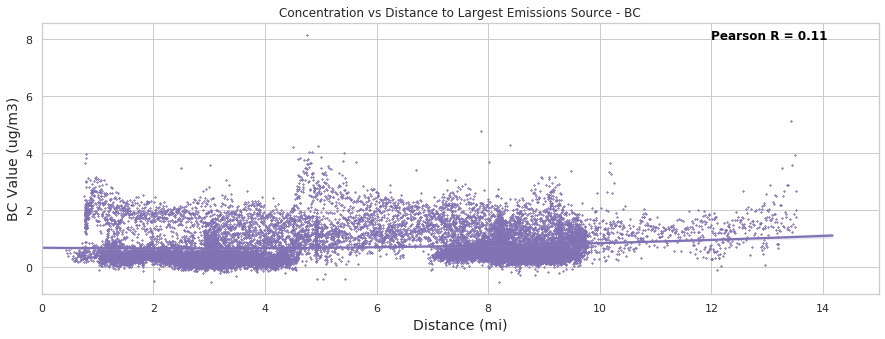

In [174]:
plt.figure(figsize = (15,5))
#ax = sns.scatterplot(x='18778911-Retail-Res-high_dist', y="BC Value", data=BC_high_PM25, 
#                     s=4, alpha = 0.4, marker = 'x', color='m')
sns.regplot(x='18778911-Retail-Res-high_dist', y="BC Value", data=BC_high_PM25, 
            marker = 'x', color='m',scatter_kws={'s':2},order = 2)
plt.xlabel('Distance (mi)', fontsize = 14)
plt.ylabel('BC Value (ug/m3)', fontsize = 14)
plt.xlim(0,15)
plt.title('Concentration vs Distance to Largest Emissions Source - BC')
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.text(12, 8, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')

  -  The above plot shows that there is a low correlation between concentration and distace to facility for the largest emitter

In [175]:
high_NO2 = [col for col in NO2_Facility_Dist.columns if '7845611' in col]

In [176]:
NO2_high_NO2 = NO2_Facility_Dist[high_NO2].join(NO2_Facility_Dist['NO2 Value'])

In [177]:
NO2_high_NO2.drop(NO2_high_NO2.columns[[0,2,3]],axis=1,inplace=True)

In [178]:
NO2_high_NO2.head()

7845611-Retail-Res-high_dist  NO2 Value
0                      4.895254  17.539762
1                      4.935025  19.956750
2                      4.916607  23.967768
3                      4.953222  18.435184
4                      4.898033  25.797037

In [179]:
covariance = pearsonr(NO2_high_NO2['7845611-Retail-Res-high_dist'], NO2_high_NO2['NO2 Value'])

Text(22, 60, 'Pearson R = 0.05')

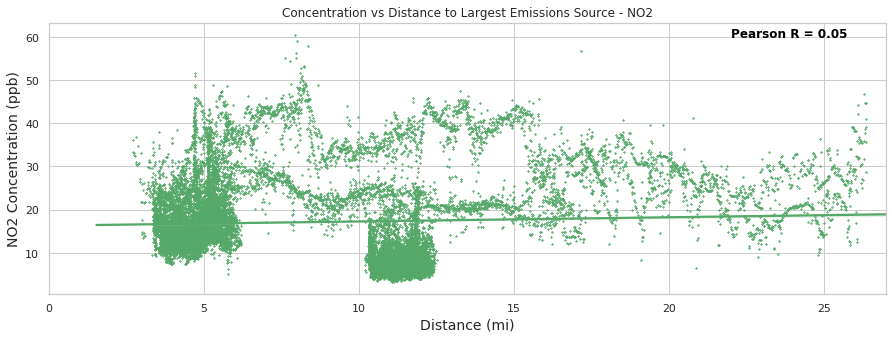

In [180]:
##ax = sns.scatterplot(x='7845611-Retail-Res-high_dist', y="NO2 Value", data=NO2_high_NO2, s=16)
plt.figure(figsize = (15,5))
sns.regplot(x='7845611-Retail-Res-high_dist', y="NO2 Value", data=NO2_high_NO2, 
            marker = 'x', color='g',scatter_kws={'s':2})
plt.xlabel('Distance (mi)', fontsize = 14)
plt.ylabel('NO2 Concentration (ppb)', fontsize = 14)
plt.xlim(0, 27)
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.title('Concentration vs Distance to Largest Emissions Source - NO2')
plt.text(22, 60, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')

  -  The above plot shows that there is a low correlation between concentration and distace to facility for the largest emitter

### <font color='red'>  How does concentration vary with distance^2 for largest source? </font>

In [181]:
BC_high_PM25['distance2'] = BC_high_PM25['18778911-Retail-Res-high_dist']**2

In [182]:
covariance = pearsonr(BC_high_PM25['distance2'], BC_high_PM25['BC Value'])

Text(158, 8, 'Pearson R = 0.11')

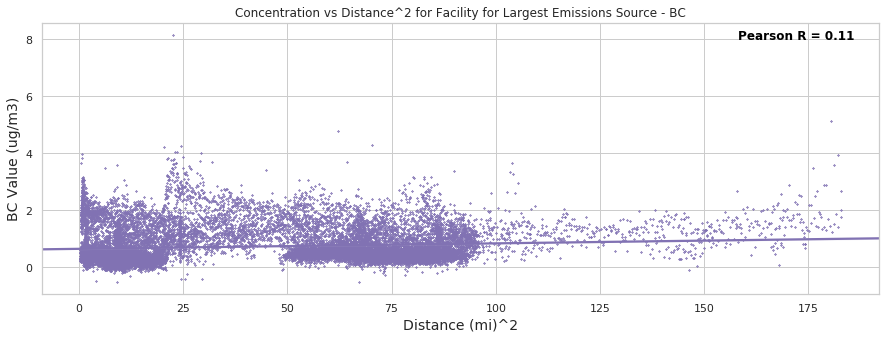

In [183]:
plt.figure(figsize = (15,5))
sns.regplot(x='distance2', y="BC Value", data=BC_high_PM25, 
            marker = 'x', color='m',scatter_kws={'s':2})
#ax = sns.scatterplot(x='distance2', y="BC Value", data=BC_high_PM25, s=16, color='green')
plt.xlabel('Distance (mi)^2', fontsize = 14)
plt.ylabel('BC Value (ug/m3)', fontsize = 14)
plt.title('Concentration vs Distance^2 for Facility for Largest Emissions Source - BC')
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.text(158, 8, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')

In [184]:
NO2_high_NO2['distance2'] = NO2_high_NO2['7845611-Retail-Res-high_dist']**2

In [185]:
covariance = pearsonr(NO2_high_NO2['distance2'], NO2_high_NO2['NO2 Value'])

Text(600, 60, 'Pearson R = 0.12')

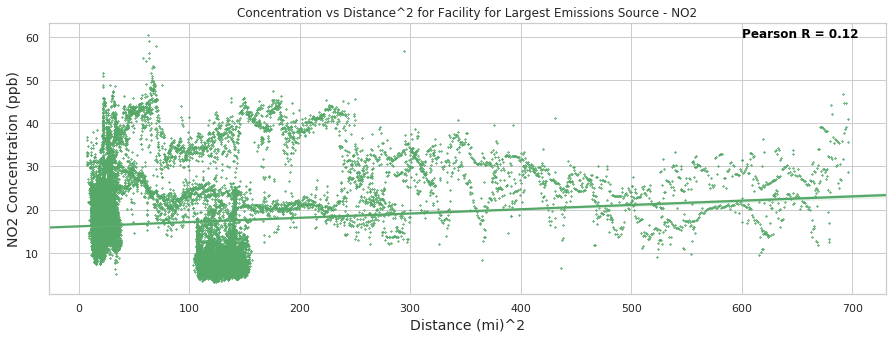

In [186]:
plt.figure(figsize = (15,5))
sns.regplot(x='distance2', y="NO2 Value", data=NO2_high_NO2, 
            marker = 'x', color='g',scatter_kws={'s':2})
plt.xlabel('Distance (mi)^2', fontsize = 14)
plt.ylabel('NO2 Concentration (ppb)', fontsize = 14)
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.title('Concentration vs Distance^2 for Facility for Largest Emissions Source - NO2')
plt.text(600, 60, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')
#ax = sns.scatterplot(x='distance2', y="NO2 Value", data=NO2_high_NO2, s=16, color='green')


### <font color='red'>  How does concentration vary with emission/distance for all the high emitting sources? </font>

In [187]:
BC_Facility_EmsDist = pd.read_csv("Data/Combined_BC_EmsDist.csv")

In [188]:
BC_Facility_EmsDist.drop(columns = ['Unnamed: 0'], inplace=True)

In [189]:
BC_Facility_EmsDist_melt = BC_Facility_EmsDist.melt(id_vars = ['BC Value'])

In [190]:
### Keep only rows that have '_emsdist' as variable
BC_Facility_EmsDist_melt = BC_Facility_EmsDist_melt[BC_Facility_EmsDist_melt['variable'].str.contains("_emsdist")]

In [191]:
BC_Facility_EmsDist_melt['value'].describe().astype(float)

count    7.477824e+06
mean     1.423644e-01
std      1.037258e+00
min      1.848236e-10
25%      2.806850e-05
50%      1.820210e-04
75%      4.707600e-03
max      3.292706e+02
Name: value, dtype: float64

In [192]:
covariance = pearsonr(BC_Facility_EmsDist_melt['value'], BC_Facility_EmsDist_melt['BC Value'])


Text(32, 8, 'Pearson R = 0.0047')

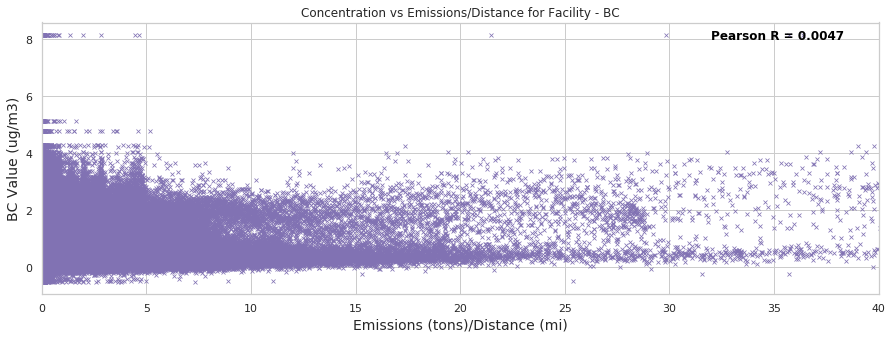

In [193]:
### Concentration vs Emissions/Distance for Black Carbon

plt.figure(figsize = (15,5))
#sns.regplot(x='value', y="BC Value", data=BC_Facility_EmsDist_melt, 
#            marker = 'x', color='m',scatter_kws={'s':2})
ax = sns.scatterplot(x='value', y="BC Value", data=BC_Facility_EmsDist_melt, s=16, marker = 'x', color='m')
plt.xlabel('Emissions (tons)/Distance (mi)', fontsize = 14)
plt.ylabel('BC Value (ug/m3)', fontsize = 14)
plt.xlim(0, 40)
plt.title('Concentration vs Emissions/Distance for Facility - BC')
str_cor = "Pearson R = "+ str(round(covariance[0],4))
plt.text(32, 8, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')







In [194]:
NO2_Facility_EmsDist = pd.read_csv("Data/Combined_NO2_EmsDist.csv")

In [195]:
NO2_Facility_EmsDist.drop(columns = ['Unnamed: 0'], inplace=True)

In [196]:
NO2_Facility_EmsDist_melt = NO2_Facility_EmsDist.melt(id_vars = ['NO2 Value'])

In [197]:
### Keep only rows that have '_emsdist' as variable
NO2_Facility_EmsDist_melt = NO2_Facility_EmsDist_melt[NO2_Facility_EmsDist_melt['variable'].str.contains("_emsdist")]

In [198]:
NO2_Facility_EmsDist_melt['value'].describe().astype(float)

count    6.811696e+06
mean     3.431567e-01
std      2.500127e+00
min      5.499867e-08
25%      9.550520e-04
50%      5.642318e-03
75%      5.524280e-02
max      4.073902e+02
Name: value, dtype: float64

In [199]:
NO2_Facility_EmsDist_melt.head()

NO2 Value                          variable     value
85952  17.539762  10452911-Retail-Res-high_emsdist  0.098589
85953  19.956750  10452911-Retail-Res-high_emsdist  0.099216
85954  23.967768  10452911-Retail-Res-high_emsdist  0.099030
85955  18.435184  10452911-Retail-Res-high_emsdist  0.099415
85956  25.797037  10452911-Retail-Res-high_emsdist  0.098861

In [200]:
covariance = pearsonr(NO2_Facility_EmsDist_melt['value'], NO2_Facility_EmsDist_melt['NO2 Value'])


Text(120, 60, 'Pearson R = -0.0032')

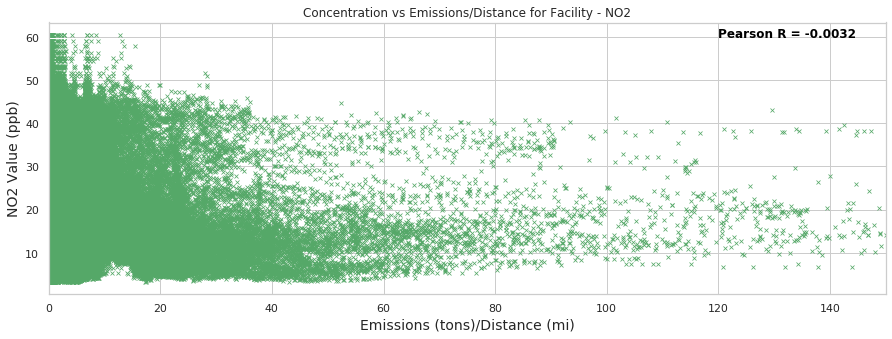

In [201]:
### Concentration vs Emissions/Distance for Nitrogen Dioxide
plt.figure(figsize = (15,5))
ax = sns.scatterplot(x='value', y="NO2 Value", data=NO2_Facility_EmsDist_melt, s=16, marker='x', color='g')
plt.xlabel('Emissions (tons)/Distance (mi)', fontsize = 14)
plt.ylabel('NO2 Value (ppb)', fontsize = 14)
plt.xlim(0, 150)
plt.title('Concentration vs Emissions/Distance for Facility - NO2')
str_cor = "Pearson R = "+ str(round(covariance[0],4))
plt.text(120, 60, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')



#sns.regplot(x='value', y="BC Value", data=BC_Facility_EmsDist_melt, 
#            marker = 'x', color='m',scatter_kws={'s':2})







### <font color='red'>  Histogram of 'Distance to Facility' - Black Carbon </font>

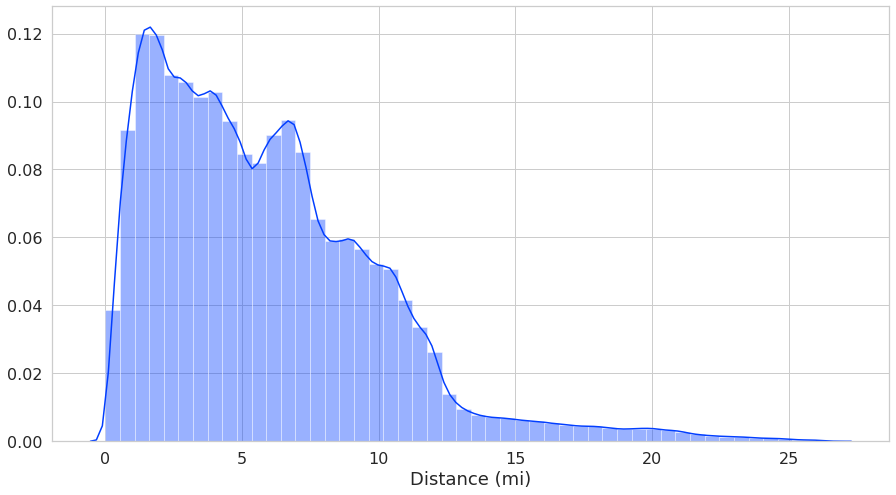

In [202]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(BC_Facility_melt['value'], ax = ax)
ax.set_xlabel('Distance (mi)', fontsize = 18)
ax.tick_params(labelsize=16)

In [203]:
BC_low = BC_Facility_melt[BC_Facility_melt['variable'].str.contains("-low")]
BC_medium = BC_Facility_melt[BC_Facility_melt['variable'].str.contains("-medium")]
BC_high = BC_Facility_melt[BC_Facility_melt['variable'].str.contains("-high")]

Text(0.5, 0, 'Distance (mi)')

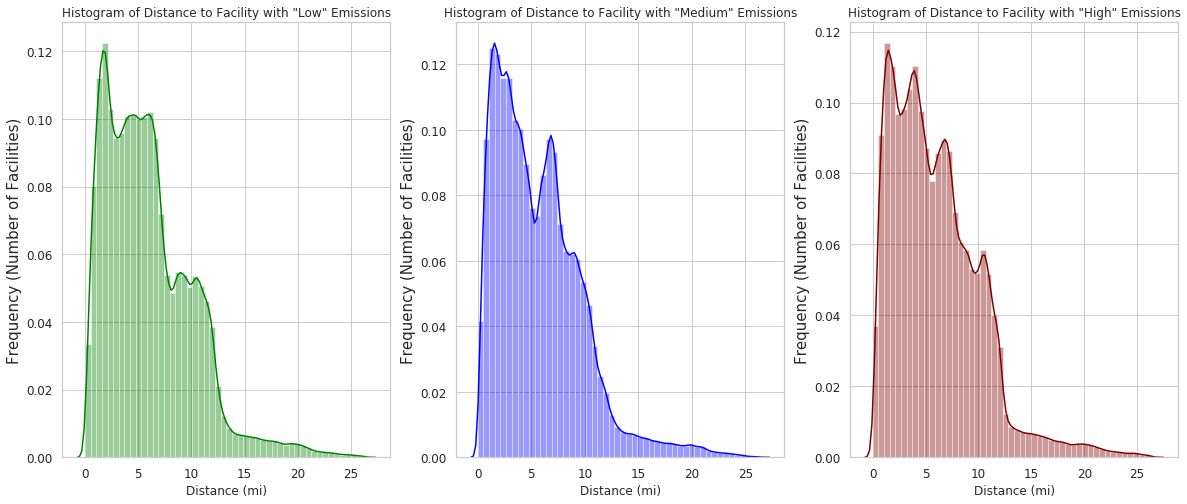

In [204]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,8))
sns.distplot(BC_low['value'], ax = ax1, color='green')
sns.distplot(BC_medium['value'], ax = ax2, color='blue')
sns.distplot(BC_high['value'], ax = ax3, color='maroon')
ax1.set_title('Histogram of Distance to Facility with "Low" Emissions')
ax2.set_title('Histogram of Distance to Facility with "Medium" Emissions')
ax3.set_title('Histogram of Distance to Facility with "High" Emissions')
ax1.tick_params(labelsize=12)
ax1.set_ylabel('Frequency (Number of Facilities)', fontsize = 15)
ax1.set_xlabel('Distance (mi)')

ax2.tick_params(labelsize=12)
ax2.set_ylabel('Frequency (Number of Facilities)', fontsize = 15)
ax2.set_xlabel('Distance (mi)')

ax3.tick_params(labelsize=12)
ax3.set_ylabel('Frequency (Number of Facilities)', fontsize = 15)
ax3.set_xlabel('Distance (mi)')

### <font color='red'>  Histogram of 'Distance to Facility' - NO2 </font>

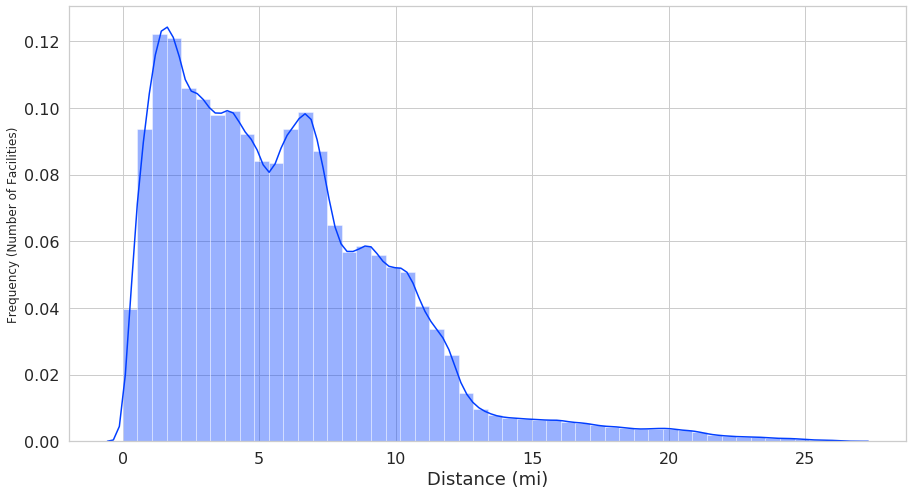

In [205]:
fig, ax = plt.subplots(figsize = (15,8))
sns.distplot(NO2_Facility_melt['value'], ax = ax)
ax.set_xlabel('Distance (mi)', fontsize = 18)
ax.set_ylabel('Frequency (Number of Facilities)')
ax.tick_params(labelsize=16)

In [206]:
NO2_low = NO2_Facility_melt[NO2_Facility_melt['variable'].str.contains("-low")]
NO2_medium = NO2_Facility_melt[NO2_Facility_melt['variable'].str.contains("-medium")]
NO2_high = NO2_Facility_melt[NO2_Facility_melt['variable'].str.contains("-high")]



Text(0.5, 0, 'Distance (mi)')

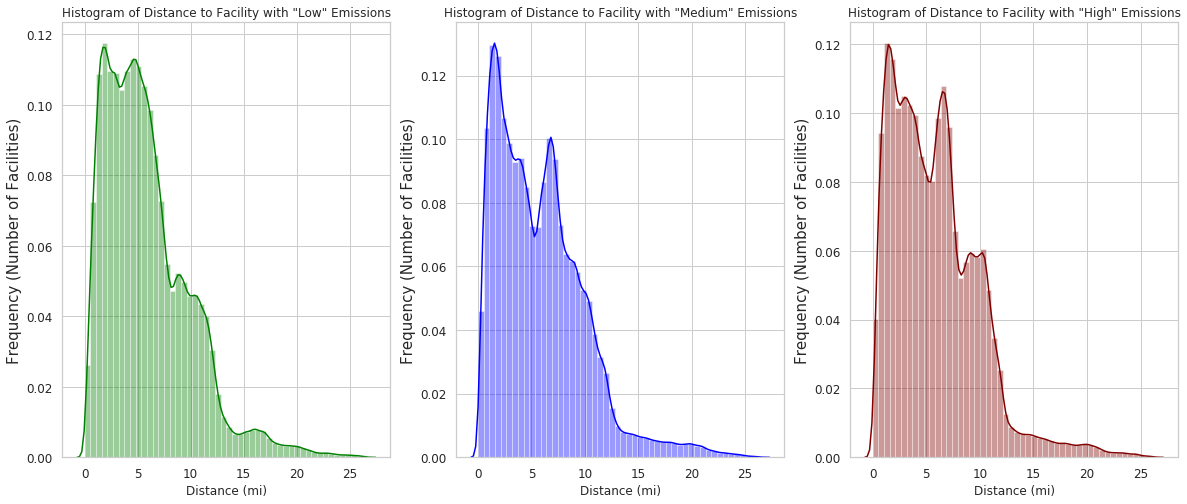

In [207]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,8))
sns.distplot(NO2_low['value'], ax = ax1, color='green')
sns.distplot(NO2_medium['value'], ax = ax2, color='blue')
sns.distplot(NO2_high['value'], ax = ax3, color='maroon')
ax1.set_title('Histogram of Distance to Facility with "Low" Emissions')
ax2.set_title('Histogram of Distance to Facility with "Medium" Emissions')
ax3.set_title('Histogram of Distance to Facility with "High" Emissions')
ax1.tick_params(labelsize=12)
ax1.set_ylabel('Frequency (Number of Facilities)', fontsize = 15)
ax1.set_xlabel('Distance (mi)')

ax2.tick_params(labelsize=12)
ax2.set_ylabel('Frequency (Number of Facilities)', fontsize = 15)
ax2.set_xlabel('Distance (mi)')

ax3.tick_params(labelsize=12)
ax3.set_ylabel('Frequency (Number of Facilities)', fontsize = 15)
ax3.set_xlabel('Distance (mi)')

### Plotting Traffic Score

In [217]:
traffic = pd.read_csv("Data/Traffic_score.csv")

In [218]:
traffic.drop(columns = ['Unnamed: 0'], inplace=True)

In [219]:
traffic.shape

(21488, 3)

In [220]:
traffic.describe()

Latitude     Longitude  number_intersections
count  21488.000000  21488.000000          21488.000000
mean      37.768860   -122.214966              7.056031
std        0.052732      0.065693              6.408622
min       37.559830   -122.322594              2.000000
25%       37.744525   -122.276182              2.000000
50%       37.773564   -122.198630              5.000000
75%       37.809764   -122.167735              9.000000
max       37.837491   -122.034503             35.000000

### Merge this with BC_df using lat,long

In [221]:
traffic_BC = traffic.join(BC_df, lsuffix = '_traf', rsuffix = '_BC')

In [222]:
traffic_BC.head()

Latitude_traf  Longitude_traf  number_intersections  Longitude_BC  \
0      37.806781     -122.322594                     3   -122.322594   
1      37.806150     -122.322310                     3   -122.322310   
2      37.806420     -122.322301                     3   -122.322301   
3      37.805880     -122.322299                     3   -122.322299   
4      37.806689     -122.322267                     3   -122.322267   

   Latitude_BC  BC Value       TimePeriod                     geometry  
0    37.806781  0.818032  Jun2015-May2016  POINT (-122.32259 37.80678)  
1    37.806150  0.551475  Jun2015-May2016  POINT (-122.32231 37.80615)  
2    37.806420  0.593712  Jun2015-May2016  POINT (-122.32230 37.80642)  
3    37.805880  0.489898  Jun2015-May2016  POINT (-122.32230 37.80588)  
4    37.806689  0.739341  Jun2015-May2016  POINT (-122.32227 37.80669)

In [223]:
traffic_BC.drop(columns = ['TimePeriod', 'Latitude_BC', 'Longitude_BC'], inplace=True)

In [224]:
traffic_BC.rename(columns = {'Latitude_traf':'Latitude', 'Longitude_traf':'Longitude'}, inplace=True)

In [225]:
covariance = pearsonr(traffic_BC['number_intersections'], traffic_BC['BC Value'])


Text(30, 8, 'Pearson R = -0.1')

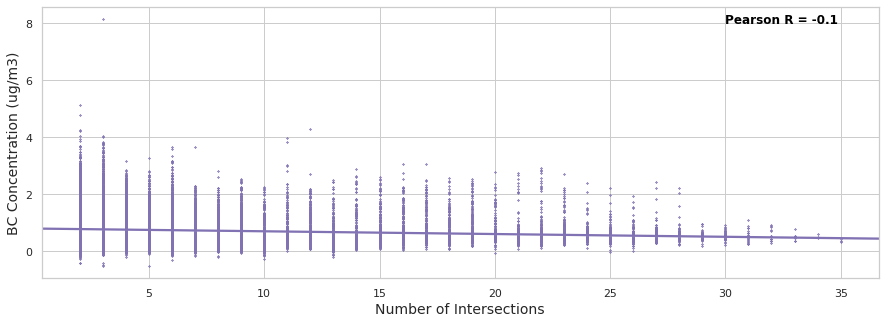

In [226]:
### Scatterplot of BC Value and number of traffic intersections
#ax = sns.scatterplot(x='number_intersections', y="BC Value", data=traffic_BC, s=16)
plt.figure(figsize = (15,5))

sns.regplot(x='number_intersections', y="BC Value", data=traffic_BC, 
            marker = 'x', color='m',scatter_kws={'s':2})
plt.xlabel('Number of Intersections', fontsize = 14)
plt.ylabel('BC Concentration (ug/m3)', fontsize = 14)
ax.set_ylim(0,4)
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.text(30, 8, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')




In [227]:
traffic_BC.head()

Latitude   Longitude  number_intersections  BC Value  \
0  37.806781 -122.322594                     3  0.818032   
1  37.806150 -122.322310                     3  0.551475   
2  37.806420 -122.322301                     3  0.593712   
3  37.805880 -122.322299                     3  0.489898   
4  37.806689 -122.322267                     3  0.739341   

                      geometry  
0  POINT (-122.32259 37.80678)  
1  POINT (-122.32231 37.80615)  
2  POINT (-122.32230 37.80642)  
3  POINT (-122.32230 37.80588)  
4  POINT (-122.32227 37.80669)

### Merge traffic with NO2_df using lat,long

In [228]:
traffic_NO2 = traffic.join(NO2_df, lsuffix = '_traf', rsuffix = '_NO2')

In [229]:
traffic_NO2.head()

Latitude_traf  Longitude_traf  number_intersections  Longitude_NO2  \
0      37.806781     -122.322594                     3    -122.322594   
1      37.806150     -122.322310                     3    -122.322310   
2      37.806420     -122.322301                     3    -122.322301   
3      37.805880     -122.322299                     3    -122.322299   
4      37.806689     -122.322267                     3    -122.322267   

   Latitude_NO2  NO2 Value       TimePeriod                     geometry  
0     37.806781  17.539762  Jun2015-May2016  POINT (-122.32259 37.80678)  
1     37.806150  19.956750  Jun2015-May2016  POINT (-122.32231 37.80615)  
2     37.806420  23.967768  Jun2015-May2016  POINT (-122.32230 37.80642)  
3     37.805880  18.435184  Jun2015-May2016  POINT (-122.32230 37.80588)  
4     37.806689  25.797037  Jun2015-May2016  POINT (-122.32227 37.80669)

In [230]:
traffic_NO2.drop(columns = ['TimePeriod', 'Latitude_NO2', 'Longitude_NO2'], inplace=True)

In [231]:
traffic_NO2.rename(columns = {'Latitude_traf':'Latitude', 'Longitude_traf':'Longitude'}, inplace=True)

In [232]:
covariance = pearsonr(traffic_NO2['number_intersections'], traffic_NO2['NO2 Value'])


Text(30, 8, 'Pearson R = 0.02')

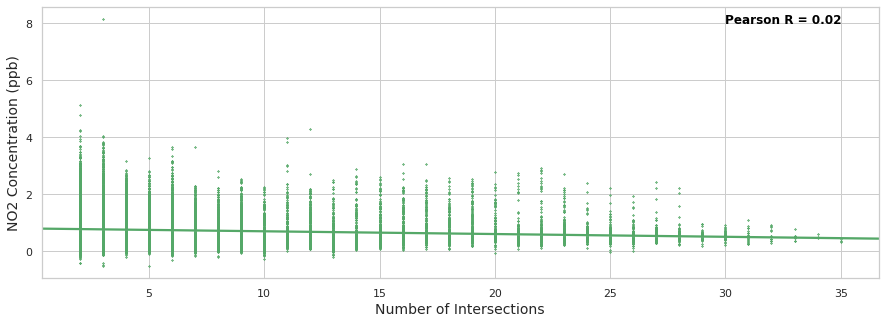

In [233]:
### Scatterplot of BC Value and number of traffic intersections
plt.figure(figsize = (15,5))
#ax = sns.scatterplot(x='number_intersections', y="NO2 Value", data=traffic_NO2, s=16)

sns.regplot(x='number_intersections', y="BC Value", data=traffic_BC, 
            marker = 'x', color='g',scatter_kws={'s':2})
plt.xlabel('Number of Intersections', fontsize = 14)
plt.ylabel('NO2 Concentration (ppb)', fontsize = 14)

ax.set_ylim(0,60)
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.text(30, 8, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')






#

## Loading data on Distance to Closest highway

In [319]:
BC_df_highway = pd.read_csv("Data/BC_dist_highway.csv")

In [320]:
BC_df_highway.drop(columns = ['Unnamed: 0'], inplace=True)

In [236]:
covariance = pearsonr(BC_df_highway['Dist'], BC_df_highway['BC Value'])


Text(14, 8, 'Pearson R = 0.07')

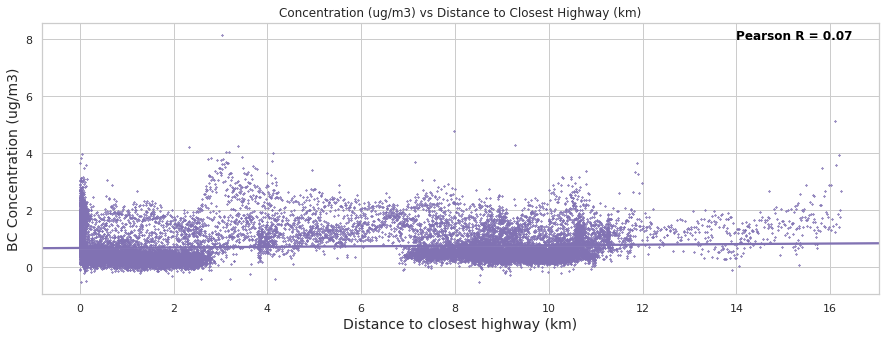

In [237]:
### Scatterplot of BC Value and distance to closest highway
plt.figure(figsize = (15,5))

sns.regplot(x='Dist', y="BC Value", data=BC_df_highway, 
            marker = 'x', color='m',scatter_kws={'s':2})

#ax = sns.scatterplot(x='Dist', y="BC Value", data=BC_df_highway, s=16)
plt.xlabel('Distance to closest highway (km)', fontsize = 14)
plt.ylabel('BC Concentration (ug/m3)', fontsize = 14)
plt.title('Concentration (ug/m3) vs Distance to Closest Highway (km)')

str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.text(14, 8, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')





In [321]:
NO2_df_highway = pd.read_csv("Data/NO2_dist_highway.csv")

In [322]:
NO2_df_highway.drop(columns = ['Unnamed: 0'], inplace=True)

In [240]:
covariance = pearsonr(NO2_df_highway['Dist'], NO2_df_highway['NO2 Value'])


Text(14, 60, 'Pearson R = 0.18')

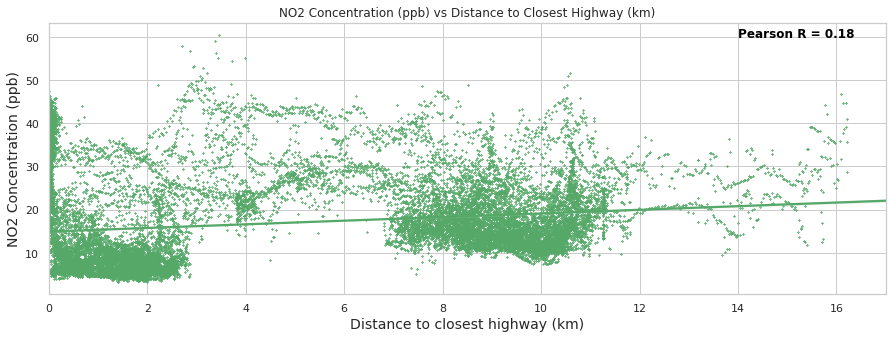

In [241]:
### Scatterplot of NO2 Value and distance to closest highway
plt.figure(figsize = (15,5))

sns.regplot(x='Dist', y="NO2 Value", data=NO2_df_highway, 
            marker = 'x', color='g',scatter_kws={'s':2})

#ax = sns.scatterplot(x='Dist', y="NO2 Value", data=NO2_df_highway, s=16)
plt.xlabel('Distance to closest highway (km)', fontsize = 14)
plt.ylabel('NO2 Concentration (ppb)', fontsize = 14)
plt.title('NO2 Concentration (ppb) vs Distance to Closest Highway (km)')
plt.xlim(0,17)
str_cor = "Pearson R = "+ str(round(covariance[0],2))
plt.text(14, 60, str_cor, horizontalalignment='left', size='medium', color='black', weight='semibold')





### Loading Met Data

In [242]:
met = pd.read_csv("Data/daymet_avg_15_16.csv")

In [243]:
met.drop(columns = ['Unnamed: 0'], inplace=True)

In [244]:
met.shape

(21488, 8)

In [245]:
met.head()

Daylen    Precip   Radiation    Maxtemp    Mintemp    Pressure  \
0  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   
1  43223.606557  1.573770  344.874317  21.258197  11.527322  919.453552   
2  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   
3  43223.606557  1.573770  344.874317  21.258197  11.527322  919.453552   
4  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   

    Latitude   Longitude  
0  37.806781 -122.322594  
1  37.806781 -122.322594  
2  37.806150 -122.322310  
3  37.806150 -122.322310  
4  37.806420 -122.322301

In [246]:
### Merge met data with Black Carbon data to see correlation
met_BC = BC_df.join(met, lsuffix = '_BC', rsuffix = '_met') 

In [247]:
met_BC.head()

Longitude_BC  Latitude_BC  BC Value       TimePeriod  \
0   -122.322594    37.806781  0.818032  Jun2015-May2016   
1   -122.322310    37.806150  0.551475  Jun2015-May2016   
2   -122.322301    37.806420  0.593712  Jun2015-May2016   
3   -122.322299    37.805880  0.489898  Jun2015-May2016   
4   -122.322267    37.806689  0.739341  Jun2015-May2016   

                      geometry        Daylen    Precip   Radiation    Maxtemp  \
0  POINT (-122.32259 37.80678)  43223.606557  1.650273  341.831694  20.744536   
1  POINT (-122.32231 37.80615)  43223.606557  1.573770  344.874317  21.258197   
2  POINT (-122.32230 37.80642)  43223.606557  1.650273  341.831694  20.744536   
3  POINT (-122.32230 37.80588)  43223.606557  1.573770  344.874317  21.258197   
4  POINT (-122.32227 37.80669)  43223.606557  1.650273  341.831694  20.744536   

     Mintemp    Pressure  Latitude_met  Longitude_met  
0  11.528689  922.076503     37.806781    -122.322594  
1  11.527322  919.453552     37.806781    -122.322594  
2  11.528689  922.076503     37.806150    -122.322310  
3  11.527322  919.453552     37.806150    -122.322310  
4  11.528689  922.076503     37.806420    -122.322301

In [248]:
met_BC.drop(columns = ['TimePeriod', 'Latitude_BC', 'Longitude_BC', 'Daylen'], inplace=True)
met_BC.rename(columns = {'Latitude_met':'Latitude', 'Longitude_met':'Longitude'}, inplace=True)

In [249]:
met_BC.shape

(21488, 9)

In [250]:
### Merge met data with NO2 data to see correlation
met_NO2 = NO2_df.join(met, lsuffix = '_NO2', rsuffix = '_met') 

In [251]:
met_NO2.head()

Longitude_NO2  Latitude_NO2  NO2 Value       TimePeriod  \
0    -122.322594     37.806781  17.539762  Jun2015-May2016   
1    -122.322310     37.806150  19.956750  Jun2015-May2016   
2    -122.322301     37.806420  23.967768  Jun2015-May2016   
3    -122.322299     37.805880  18.435184  Jun2015-May2016   
4    -122.322267     37.806689  25.797037  Jun2015-May2016   

                      geometry        Daylen    Precip   Radiation    Maxtemp  \
0  POINT (-122.32259 37.80678)  43223.606557  1.650273  341.831694  20.744536   
1  POINT (-122.32231 37.80615)  43223.606557  1.573770  344.874317  21.258197   
2  POINT (-122.32230 37.80642)  43223.606557  1.650273  341.831694  20.744536   
3  POINT (-122.32230 37.80588)  43223.606557  1.573770  344.874317  21.258197   
4  POINT (-122.32227 37.80669)  43223.606557  1.650273  341.831694  20.744536   

     Mintemp    Pressure  Latitude_met  Longitude_met  
0  11.528689  922.076503     37.806781    -122.322594  
1  11.527322  919.453552     37.806781    -122.322594  
2  11.528689  922.076503     37.806150    -122.322310  
3  11.527322  919.453552     37.806150    -122.322310  
4  11.528689  922.076503     37.806420    -122.322301

In [252]:
met_NO2.drop(columns = ['TimePeriod', 'Latitude_NO2', 'Longitude_NO2', 'Daylen'], inplace=True)
met_NO2.rename(columns = {'Latitude_met':'Latitude', 'Longitude_met':'Longitude'}, inplace=True)

In [253]:
met_NO2.shape

(21488, 9)

In [254]:
covariance1 = pearsonr(met_BC['Precip'], met_BC['BC Value'])
covariance2 = pearsonr(met_NO2['Precip'], met_NO2['NO2 Value'])


Text(1.5, 60, 'Pearson R = -0.31')

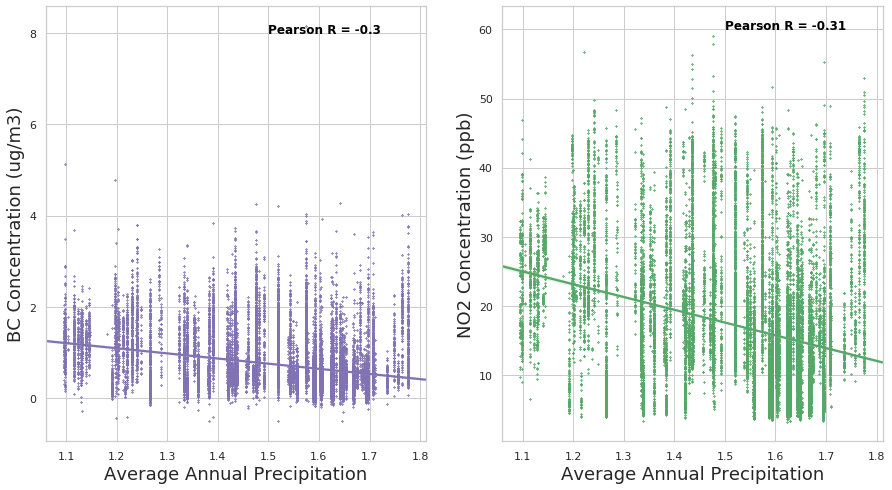

In [255]:
#Precipitation vs BC Value
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.regplot(x='Precip', y="BC Value", data=met_BC, 
            marker = 'x', color='m',scatter_kws={'s':2}, ax = ax1)
sns.regplot(x='Precip', y="NO2 Value", data=met_NO2, 
            marker = 'x', color='g',scatter_kws={'s':2}, ax = ax2)
#sns.scatterplot(x='Precip', y="BC Value", data=met_BC, s=16, ax = ax1)
#sns.scatterplot(x='Precip', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Average Annual Precipitation', fontsize = 18)
ax2.set_xlabel('Average Annual Precipitation', fontsize = 18)
str_cor1 = "Pearson R = "+ str(round(covariance1[0],2))
ax1.text(1.5, 8, str_cor1, horizontalalignment='left', size='medium', color='black', weight='semibold')
str_cor2 = "Pearson R = "+ str(round(covariance2[0],2))
ax2.text(1.5, 60, str_cor2, horizontalalignment='left', size='medium', color='black', weight='semibold')





In [256]:
covariance1 = pearsonr(met_BC['Radiation'], met_BC['BC Value'])
covariance2 = pearsonr(met_NO2['Radiation'], met_NO2['NO2 Value'])


Text(348, 60, 'Pearson R = 0.29')

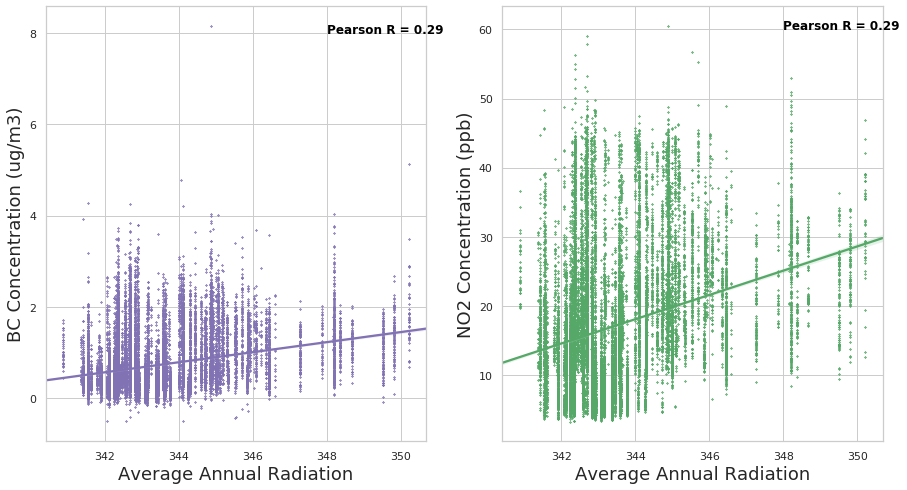

In [257]:
#Annual average Radiation vs BC Value
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.regplot(x='Radiation', y="BC Value", data=met_BC, 
            marker = 'x', color='m',scatter_kws={'s':2}, ax = ax1)
sns.regplot(x='Radiation', y="NO2 Value", data=met_NO2, 
            marker = 'x', color='g',scatter_kws={'s':2}, ax = ax2)
#sns.scatterplot(x='Precip', y="BC Value", data=met_BC, s=16, ax = ax1)
#sns.scatterplot(x='Precip', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Average Annual Radiation', fontsize = 18)
ax2.set_xlabel('Average Annual Radiation', fontsize = 18)
str_cor1 = "Pearson R = "+ str(round(covariance1[0],2))
ax1.text(348, 8, str_cor1, horizontalalignment='left', size='medium', color='black', weight='semibold')
str_cor2 = "Pearson R = "+ str(round(covariance2[0],2))
ax2.text(348, 60, str_cor2, horizontalalignment='left', size='medium', color='black', weight='semibold')





Text(0.5, 0, 'Average Annual Radiation')

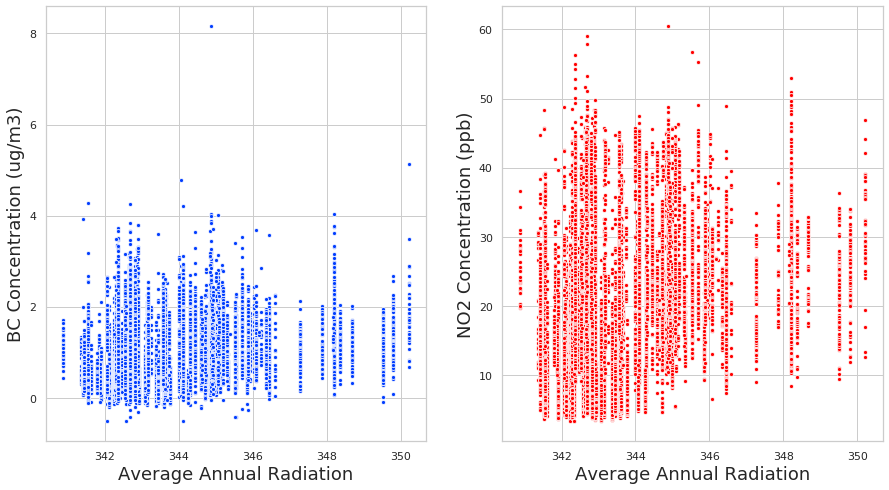

In [258]:
#Annual average Radiation vs BC Value
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.scatterplot(x='Radiation', y="BC Value", data=met_BC, s=16, ax = ax1)
sns.scatterplot(x='Radiation', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Average Annual Radiation', fontsize = 18)
ax2.set_xlabel('Average Annual Radiation', fontsize = 18)


In [259]:
covariance1 = pearsonr(met_BC['Maxtemp'], met_BC['BC Value'])
covariance2 = pearsonr(met_NO2['Maxtemp'], met_NO2['NO2 Value'])


Text(21.4, 60, 'Pearson R = 0.34')

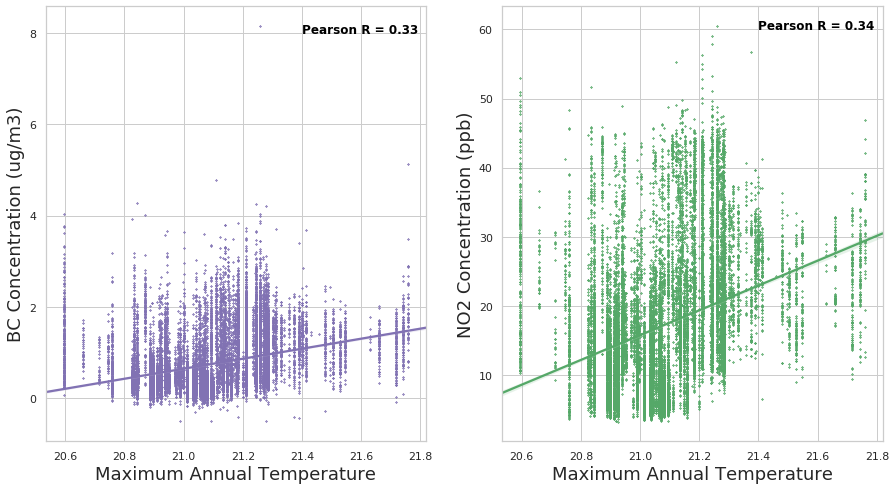

In [260]:
#Annual average Radiation vs BC Value
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.regplot(x='Maxtemp', y="BC Value", data=met_BC, 
            marker = 'x', color='m',scatter_kws={'s':2}, ax = ax1)
sns.regplot(x='Maxtemp', y="NO2 Value", data=met_NO2, 
            marker = 'x', color='g',scatter_kws={'s':2}, ax = ax2)
#sns.scatterplot(x='Precip', y="BC Value", data=met_BC, s=16, ax = ax1)
#sns.scatterplot(x='Precip', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Maximum Annual Temperature', fontsize = 18)
ax2.set_xlabel('Maximum Annual Temperature', fontsize = 18)
str_cor1 = "Pearson R = "+ str(round(covariance1[0],2))
ax1.text(21.4, 8, str_cor1, horizontalalignment='left', size='medium', color='black', weight='semibold')
str_cor2 = "Pearson R = "+ str(round(covariance2[0],2))
ax2.text(21.4, 60, str_cor2, horizontalalignment='left', size='medium', color='black', weight='semibold')





Text(0.5, 0, 'Maximum Annual Temperature')

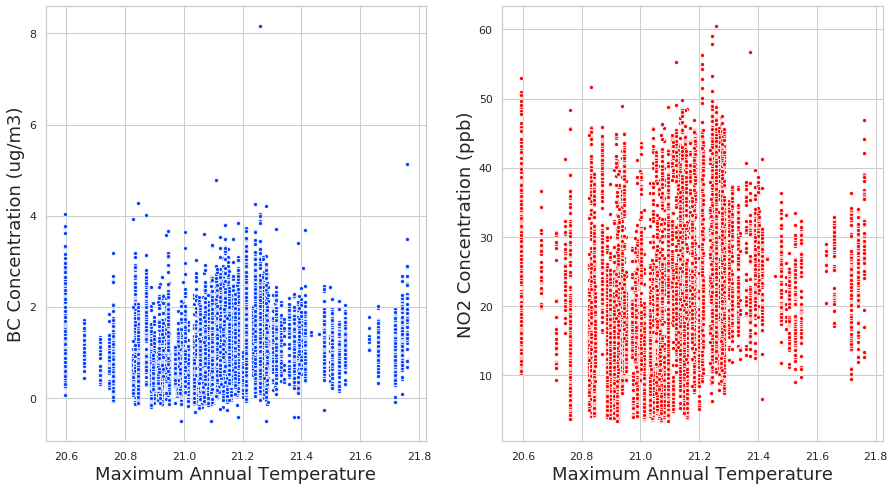

In [261]:
### Annual Max Temperature vs Black Carbon and NO2 concentrations
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.scatterplot(x='Maxtemp', y="BC Value", data=met_BC, s=16, ax = ax1)
sns.scatterplot(x='Maxtemp', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Maximum Annual Temperature', fontsize = 18)
ax2.set_xlabel('Maximum Annual Temperature', fontsize = 18)


In [262]:
covariance1 = pearsonr(met_BC['Mintemp'], met_BC['BC Value'])
covariance2 = pearsonr(met_NO2['Mintemp'], met_NO2['NO2 Value'])


Text(11.5, 60, 'Pearson R = -0.16')

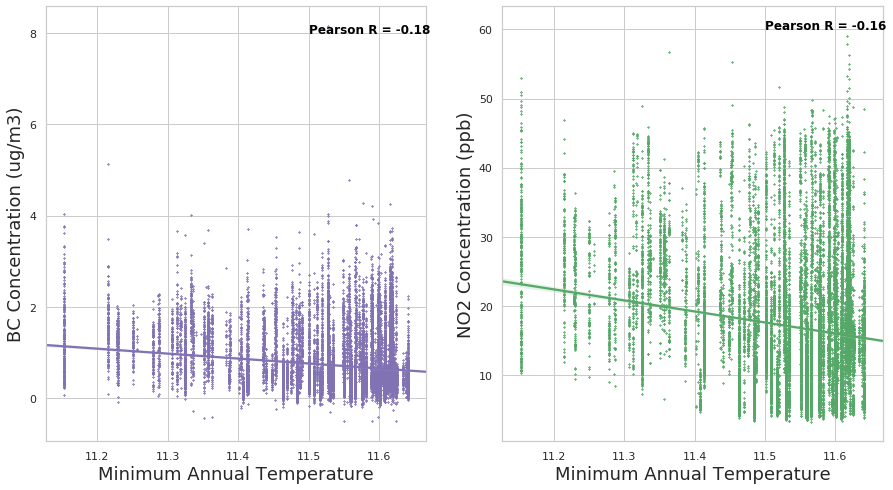

In [263]:
#Annual average Radiation vs BC Value
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.regplot(x='Mintemp', y="BC Value", data=met_BC, 
            marker = 'x', color='m',scatter_kws={'s':2}, ax = ax1)
sns.regplot(x='Mintemp', y="NO2 Value", data=met_NO2, 
            marker = 'x', color='g',scatter_kws={'s':2}, ax = ax2)
#sns.scatterplot(x='Precip', y="BC Value", data=met_BC, s=16, ax = ax1)
#sns.scatterplot(x='Precip', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Minimum Annual Temperature', fontsize = 18)
ax2.set_xlabel('Minimum Annual Temperature', fontsize = 18)
str_cor1 = "Pearson R = "+ str(round(covariance1[0],2))
ax1.text(11.5, 8, str_cor1, horizontalalignment='left', size='medium', color='black', weight='semibold')
str_cor2 = "Pearson R = "+ str(round(covariance2[0],2))
ax2.text(11.5, 60, str_cor2, horizontalalignment='left', size='medium', color='black', weight='semibold')





Text(0.5, 0, 'Minimum Annual Temperature')

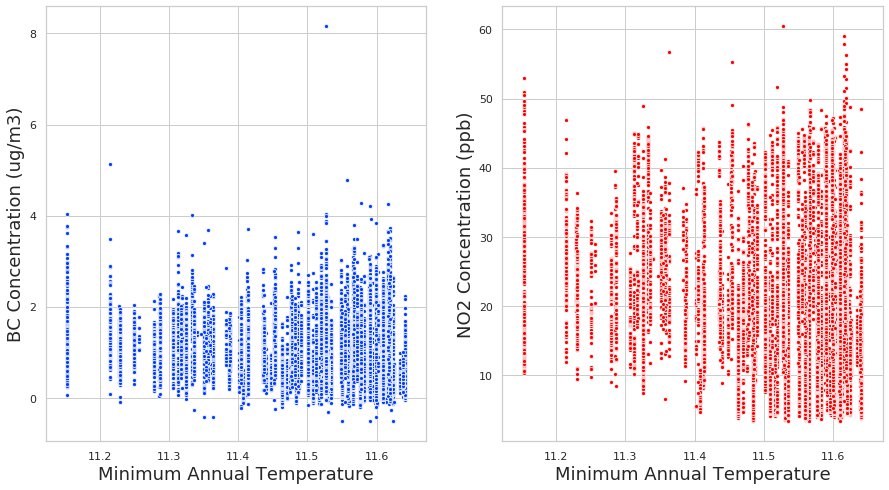

In [264]:
### Annual Min Temperature vs Black Carbon and NO2 concentrations
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.scatterplot(x='Mintemp', y="BC Value", data=met_BC, s=16, ax = ax1)
sns.scatterplot(x='Mintemp', y="NO2 Value", data=met_NO2, s=16, color='red', ax = ax2)
ax1.set_ylabel('BC Concentration (ug/m3)', fontsize = 18)
ax2.set_ylabel('NO2 Concentration (ppb)', fontsize = 18)
ax1.set_xlabel('Minimum Annual Temperature', fontsize = 18)
ax2.set_xlabel('Minimum Annual Temperature', fontsize = 18)


# Combining different features into one single dataframe

## Load the black carbon dataset that contains only distances

In [265]:
BC_Facility = pd.read_csv("Data/BC_PM_Facilities_High_Dist.csv")
#BC_Facility = pd.read_csv("Data/Combined_BC_Dist.csv")

In [266]:
BC_Facility.drop(columns = ['Unnamed: 0'], inplace=True)

In [267]:
BC_Facility.head()

Longitude   Latitude  BC Value  10457411-Manufacturing-high_dist  \
0 -122.322594  37.806781  0.818032                          3.833478   
1 -122.322310  37.806150  0.551475                          3.868312   
2 -122.322301  37.806420  0.593712                          3.850748   
3 -122.322299  37.805880  0.489898                          3.885474   
4 -122.322267  37.806689  0.739341                          3.832796   

   10457411-Manufacturing-high_latitude  \
0                             37.858341   
1                             37.858341   
2                             37.858341   
3                             37.858341   
4                             37.858341   

   10457411-Manufacturing-high_longitude  10457711-Foundaries-high_dist  \
0                            -122.296536                      10.131771   
1                            -122.296536                      10.091528   
2                            -122.296536                      10.103376   
3                            -122.296536                      10.078866   
4                            -122.296536                      10.114173   

   10457711-Foundaries-high_latitude  10457711-Foundaries-high_longitude  \
0                           37.71039                          -122.18267   
1                           37.71039                          -122.18267   
2                           37.71039                          -122.18267   
3                           37.71039                          -122.18267   
4                           37.71039                          -122.18267   

   10460511-Retail-Res-high_dist  ...  771711-Eateries-high_longitude  \
0                       3.600953  ...                     -122.209381   
1                       3.612502  ...                     -122.209381   
2                       3.601578  ...                     -122.209381   
3                       3.622568  ...                     -122.209381   
4                       3.589663  ...                     -122.209381   

   772011-EGen-high_dist  772011-EGen-high_latitude  \
0               2.459386                   37.80185   
1               2.438376                   37.80185   
2               2.440217                   37.80185   
3               2.435573                   37.80185   
4               2.440861                   37.80185   

   772011-EGen-high_longitude  808611-AsphaltPlant-high_dist  \
0                  -122.27795                       4.498548   
1                  -122.27795                       4.536862   
2                  -122.27795                       4.518656   
3                  -122.27795                       4.554789   
4                  -122.27795                       4.500215   

   808611-AsphaltPlant-high_latitude  808611-AsphaltPlant-high_longitude  \
0                           37.86982                          -122.30178   
1                           37.86982                          -122.30178   
2                           37.86982                          -122.30178   
3                           37.86982                          -122.30178   
4                           37.86982                          -122.30178   

   808811-FoodPlant-high_dist  808811-FoodPlant-high_latitude  \
0                    3.103170                        37.79355   
1                    3.075784                        37.79355   
2                    3.080629                        37.79355   
3                    3.069979                        37.79355   
4                    3.084273                        37.79355   

   808811-FoodPlant-high_longitude  
0                       -122.26824  
1                       -122.26824  
2                       -122.26824  
3                       -122.26824  
4                       -122.26824  

[5 rows x 186 columns]

In [268]:
BC_Facility_df = BC_Facility.copy()

In [269]:
## Select only the facilities that are have 'high' emissions
#BC_Facility_df = BC_Facility[[col for col in BC_Facility_Dist.columns if "-high" in col]]

In [270]:
# Merge this dataset with Black Carbon value
#BC_Facility_df = BC_Facility_df.join(BC_Facility['BC Value'])

In [271]:
# Drop latitude, and longitude columns
BC_Facility_df.drop(BC_Facility_df.columns[BC_Facility_df.columns.str.contains('_latitude')], axis=1, inplace=True)
BC_Facility_df.drop(BC_Facility_df.columns[BC_Facility_df.columns.str.contains('_longitude')], axis=1, inplace=True)
#BC_Facility_df.drop(BC_Facility_df.columns[BC_Facility_df.columns.str.contains('_PM25')], axis=1, inplace=True)

In [272]:
BC_Facility_df.shape

(21488, 64)

## Load the NO2 datasets that contain only distances

In [273]:
NO2_Facility = pd.read_csv("Data/NO2_NO2_Facilities_High_Dist.csv")
#NO2_Facility = pd.read_csv("Data/Combined_NO2_Dist.csv")

In [274]:
NO2_Facility.drop(columns = ['Unnamed: 0'], inplace=True)

In [275]:
NO2_Facility.head()

Longitude   Latitude  NO2 Value  10457511-Manufacturing-high_dist  \
0 -122.322594  37.806781  17.539762                          1.995507   
1 -122.322310  37.806150  19.956750                          1.970443   
2 -122.322301  37.806420  23.967768                          1.974141   
3 -122.322299  37.805880  18.435184                          1.965829   
4 -122.322267  37.806689  25.797037                          1.976688   

   10457511-Manufacturing-high_latitude  \
0                              37.79987   
1                              37.79987   
2                              37.79987   
3                              37.79987   
4                              37.79987   

   10457511-Manufacturing-high_longitude  10460511-Retail-Res-high_dist  \
0                             -122.28708                       3.600953   
1                             -122.28708                       3.612502   
2                             -122.28708                       3.601578   
3                             -122.28708                       3.622568   
4                             -122.28708                       3.589663   

   10460511-Retail-Res-high_latitude  10460511-Retail-Res-high_longitude  \
0                           37.83569                          -122.26765   
1                           37.83569                          -122.26765   
2                           37.83569                          -122.26765   
3                           37.83569                          -122.26765   
4                           37.83569                          -122.26765   

   10510811-AsphaltPlant-high_dist  ...  7845611-Retail-Res-high_longitude  \
0                         6.260157  ...                         -122.30514   
1                         6.225561  ...                         -122.30514   
2                         6.234118  ...                         -122.30514   
3                         6.216077  ...                         -122.30514   
4                         6.241503  ...                         -122.30514   

   804911-FoodPlant-high_dist  804911-FoodPlant-high_latitude  \
0                   10.941845                       37.700845   
1                   10.901253                       37.700845   
2                   10.913324                       37.700845   
3                   10.888376                       37.700845   
4                   10.924355                       37.700845   

   804911-FoodPlant-high_longitude  808611-AsphaltPlant-high_dist  \
0                       -122.17355                       4.498548   
1                       -122.17355                       4.536862   
2                       -122.17355                       4.518656   
3                       -122.17355                       4.554789   
4                       -122.17355                       4.500215   

   808611-AsphaltPlant-high_latitude  808611-AsphaltPlant-high_longitude  \
0                           37.86982                          -122.30178   
1                           37.86982                          -122.30178   
2                           37.86982                          -122.30178   
3                           37.86982                          -122.30178   
4                           37.86982                          -122.30178   

   808811-FoodPlant-high_dist  808811-FoodPlant-high_latitude  \
0                    3.103170                        37.79355   
1                    3.075784                        37.79355   
2                    3.080629                        37.79355   
3                    3.069979                        37.79355   
4                    3.084273                        37.79355   

   808811-FoodPlant-high_longitude  
0                       -122.26824  
1                       -122.26824  
2                       -122.26824  
3                       -122.26824  
4                       -122.26824  

[5 rows x 159 columns]

In [276]:
NO2_Facility_df = NO2_Facility.copy()

In [277]:
## Select only the facilities that are have 'high' emissions
#NO2_Facility_df = NO2_Facility[[col for col in NO2_Facility.columns if "-high" in col]]

In [278]:
# Merge this dataset with Nitrogen Dioxide value
#NO2_Facility_df = NO2_Facility_df.join(NO2_Facility['NO2 Value'])

In [279]:
# Drop latitude, longitude and PM25 emissions columns
NO2_Facility_df.drop(NO2_Facility_df.columns[NO2_Facility_df.columns.str.contains('_latitude')], axis=1, inplace=True)
NO2_Facility_df.drop(NO2_Facility_df.columns[NO2_Facility_df.columns.str.contains('_longitude')], axis=1, inplace=True)
#NO2_Facility_df.drop(NO2_Facility_df.columns[NO2_Facility_df.columns.str.contains('_NO2')], axis=1, inplace=True)

In [280]:
NO2_Facility_df.shape

(21488, 55)

## Merge this with traffic score and met data

In [323]:
BC_df_highway.drop(columns = ['BC Value'], inplace=True)
NO2_df_highway.drop(columns = ['NO2 Value'], inplace=True)

In [331]:
# Merge facility data with met data first 
BC_Facility_Met = BC_Facility_df.merge(met, left_on = ['Latitude', 'Longitude'], right_on = ['Latitude', 'Longitude'])
BC_Facility_Met_Highway = BC_Facility_Met.merge(BC_df_highway, left_on = ['Latitude', 'Longitude'], right_on = ['Latitude_BC', 'Longitude_BC'])


NO2_Facility_Met = NO2_Facility_df.merge(met, left_on = ['Latitude', 'Longitude'], right_on = ['Latitude', 'Longitude'])
NO2_Facility_Met_Highway = NO2_Facility_Met.merge(NO2_df_highway, left_on = ['Latitude', 'Longitude'], right_on = ['Latitude_NO2', 'Longitude_NO2'])


In [334]:
## Drop columns
BC_Facility_Met_Highway.drop(columns = ['Longitude_BC', 'Latitude_BC', 'Latitude_highway', 'Longitude_highway', 'dist'], inplace=True)

NO2_Facility_Met_Highway.drop(columns = ['Longitude_NO2', 'Latitude_NO2', 'Latitude_highway', 'Longitude_highway'], inplace=True)

In [335]:
BC_Facility_Met_Highway.head()

Longitude   Latitude  BC Value  10457411-Manufacturing-high_dist  \
0 -122.322594  37.806781  0.818032                          3.833478   
1 -122.322594  37.806781  0.818032                          3.833478   
2 -122.322310  37.806150  0.551475                          3.868312   
3 -122.322310  37.806150  0.551475                          3.868312   
4 -122.322301  37.806420  0.593712                          3.850748   

   10457711-Foundaries-high_dist  10460511-Retail-Res-high_dist  \
0                      10.131771                       3.600953   
1                      10.131771                       3.600953   
2                      10.091528                       3.612502   
3                      10.091528                       3.612502   
4                      10.103376                       3.601578   

   10469511-Retail-Res-high_dist  10476711-Manufacturing-high_dist  \
0                       1.896254                          5.177325   
1                       1.896254                          5.177325   
2                       1.884551                          5.144002   
3                       1.884551                          5.144002   
4                       1.882327                          5.151872   

   10510811-AsphaltPlant-high_dist  10517111-Retail-Res-high_dist  ...  \
0                         6.260157                       5.466311  ...   
1                         6.260157                       5.466311  ...   
2                         6.225561                       5.493914  ...   
3                         6.225561                       5.493914  ...   
4                         6.234118                       5.478096  ...   

   772011-EGen-high_dist  808611-AsphaltPlant-high_dist  \
0               2.459386                       4.498548   
1               2.459386                       4.498548   
2               2.438376                       4.536862   
3               2.438376                       4.536862   
4               2.440217                       4.518656   

   808811-FoodPlant-high_dist        Daylen    Precip   Radiation    Maxtemp  \
0                    3.103170  43223.606557  1.650273  341.831694  20.744536   
1                    3.103170  43223.606557  1.573770  344.874317  21.258197   
2                    3.075784  43223.606557  1.650273  341.831694  20.744536   
3                    3.075784  43223.606557  1.573770  344.874317  21.258197   
4                    3.080629  43223.606557  1.650273  341.831694  20.744536   

     Mintemp    Pressure       Dist  
0  11.528689  922.076503  11.764838  
1  11.527322  919.453552  11.764838  
2  11.528689  922.076503  11.707821  
3  11.527322  919.453552  11.707821  
4  11.528689  922.076503  11.722318  

[5 rows x 71 columns]

In [336]:
NO2_Facility_Met_Highway.head()

Longitude   Latitude  NO2 Value  10457511-Manufacturing-high_dist  \
0 -122.322594  37.806781  17.539762                          1.995507   
1 -122.322594  37.806781  17.539762                          1.995507   
2 -122.322310  37.806150  19.956750                          1.970443   
3 -122.322310  37.806150  19.956750                          1.970443   
4 -122.322301  37.806420  23.967768                          1.974141   

   10460511-Retail-Res-high_dist  10510811-AsphaltPlant-high_dist  \
0                       3.600953                         6.260157   
1                       3.600953                         6.260157   
2                       3.612502                         6.225561   
3                       3.612502                         6.225561   
4                       3.601578                         6.234118   

   10517111-Retail-Res-high_dist  10707511-EGen-high_dist  \
0                       5.466311                 5.577767   
1                       5.466311                 5.577767   
2                       5.493914                 5.602305   
3                       5.493914                 5.602305   
4                       5.478096                 5.587334   

   10708011-Waste-high_dist  127511-Retail-Res-high_dist  ...  \
0                  9.620051                     3.282128  ...   
1                  9.620051                     3.282128  ...   
2                  9.579673                     3.267003  ...   
3                  9.579673                     3.267003  ...   
4                  9.591607                     3.266277  ...   

   804911-FoodPlant-high_dist  808611-AsphaltPlant-high_dist  \
0                   10.941845                       4.498548   
1                   10.941845                       4.498548   
2                   10.901253                       4.536862   
3                   10.901253                       4.536862   
4                   10.913324                       4.518656   

   808811-FoodPlant-high_dist        Daylen    Precip   Radiation    Maxtemp  \
0                    3.103170  43223.606557  1.650273  341.831694  20.744536   
1                    3.103170  43223.606557  1.573770  344.874317  21.258197   
2                    3.075784  43223.606557  1.650273  341.831694  20.744536   
3                    3.075784  43223.606557  1.573770  344.874317  21.258197   
4                    3.080629  43223.606557  1.650273  341.831694  20.744536   

     Mintemp    Pressure       Dist  
0  11.528689  922.076503  11.764838  
1  11.527322  919.453552  11.764838  
2  11.528689  922.076503  11.707821  
3  11.527322  919.453552  11.707821  
4  11.528689  922.076503  11.722318  

[5 rows x 62 columns]

In [337]:
# Merge with traffic
BC_Facility_Met_Highway_Traffic = BC_Facility_Met_Highway.merge(traffic, left_on = ['Latitude', 'Longitude'], right_on = ['Latitude', 'Longitude'])
NO2_Facility_Met_Highway_Traffic = NO2_Facility_Met_Highway.merge(traffic, left_on = ['Latitude', 'Longitude'], right_on = ['Latitude', 'Longitude'])

In [339]:
#Drop day length, latitude and longitude columns
BC_Facility_Met_Highway_Traffic.drop(columns = ['Latitude', 'Longitude', 'Daylen'], inplace=True)
NO2_Facility_Met_Highway_Traffic.drop(columns = ['Latitude', 'Longitude', 'Daylen'], inplace=True)


##### Move BC Value to the begining
cols = BC_Facility_df_met_traffic.columns.tolist()
cols.insert(0, cols.pop(cols.index('BC Value')))
BC_Facility_df_met_traffic = BC_Facility_df_met_traffic.reindex(columns= cols)

##### Move NO2 Value to the begining
cols = NO2_Facility_df_met_traffic.columns.tolist()
cols.insert(0, cols.pop(cols.index('NO2 Value')))
NO2_Facility_df_met_traffic = NO2_Facility_df_met_traffic.reindex(columns= cols)

In [341]:
BC_Facility_Met_Highway_Traffic['Dist'] = BC_Facility_Met_Highway_Traffic['Dist']*0.621371 
NO2_Facility_Met_Highway_Traffic['Dist'] = BC_Facility_Met_Highway_Traffic['Dist']*0.621371 

In [343]:
BC_Facility_Met_Highway_Traffic.to_csv("Data/BC_input_clustered.csv")
NO2_Facility_Met_Highway_Traffic.to_csv("Data/NO2_input_clustered.csv")